# Predicting Loan Creditworthiness

In finance, one of the biggest questions is: 'Can this person pay back a loan?' Lending decisions can make or break financial institutions, and the challenge of accurately assessing creditworthiness is at the core. This hackathon by Bluechip Technologies is an opportunity to dig into this challenge, leveraging AI to build a model that brings new insights into financial risk.



This project is about using data to give lenders the tools they need to make smarter, faster decisions, reducing the risk for both them and their clients.



My goal: Create a machine learning model that accurately flags creditworthy applicants. This model aims to balance identifying reliable borrowers and minimizing risk, which is key in a field where even small gains in accuracy can mean big differences in financial outcomes.

## 1. Set-up, Importing of Necessary Libraries and Loading of files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, iqr
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

## 2. Exploratory Data Analysis



### 2.1 Data Exploration



In this section, the first step was to load the datasets and conduct a general inspection to understand their structure and contents. Here’s a quick summary of what each dataset contains:



- **Training and Test Datasets:**



  - The training dataset has 14 columns and 5,898 entries.



  - The test dataset has 15 columns and 2,528 entries (missing the Loan_Status column I will predict).



This setup gives us approximately a 70:30 split between training and test data.



- **Sample Submission Dataset:**

  - The sample submission dataset has only 2 columns and matches the size of the test dataset. This file serves as a template for the expected submission format, showing just the `Loan_ID` and predicted `Loan_Status`.





- **Data Types Overview**





  1. Training Dataset:



   - 12 `int64` columns

   - 2 ` object` columns

   - 1 `float64` column





  2. Test Dataset:

   - 11 `int64` columns

   - 2 ` object` columns

   - 1 `float64` column







This initial inspection helps verify the structure and characteristics of our datasets, ensuring they align with the analysis requirements.







- **Feature Descriptions**



Let’s break down each column to understand its purpose and potential impact on the model:



  1. ID: A unique identifier for each observation.





  2. Loan_ID: A unique identifier for each loan.





  3. Gender: Applicant’s gender (encoded as 0 for male and 1 for female).





  4. Married: Marital status (0 = Not Married, 1 = Married).





  5. Dependents: Number of dependents relying on the applicant, ranging from 0, 1, 2, to 3+.





  6. Education: Education level of the applicant (0 = Undergraduate, 1 = Graduate).





  7. Self_Employed: Employment status of the applicant (0 = No, 1 = Yes).





  8. ApplicantIncome: Monthly income of the applicant, ranging from 0 to 80,000.





  9. CoapplicantIncome: Monthly income of the co-applicant, from 0 to 20,000.





  10. LoanAmount: Loan amount requested in thousands (range: 20 to 800).





  11. Loan_Amount_Term: Loan repayment term in months (range: 0 to 500).





  12. Credit_History: Indicates whether the applicant’s credit history meets certain guidelines (0 = No, 1 = Yes).





  13. Property_Area: Type of area where the applicant lives (encoded as 0 = Rural, 1 = Semi-Urban, 2 = Urban).





  14. Loan_Status: Whether the loan was approved (Y/N); present only in the training set, this is the target variable.





  15. Total_Income: Total income of the applicant and co-applicant, ranging from 0 to 20,000.







This structured description of each feature sets a foundation for further exploration, helping us assess which features might influence loan approval predictions.

In [2]:
# loading in the necessary files

train = pd.read_csv('/kaggle/input/bluechip-summit-credit-worthiness-prediction/Train.csv')
test = pd.read_csv('/kaggle/input/bluechip-summit-credit-worthiness-prediction/Test.csv')
sample_sub = pd.read_csv('/kaggle/input/bluechip-summit-credit-worthiness-prediction/Sample Submission.csv')

# Function to display the overview of the datasets (head, shape and info)
def display_data_overview(data, dataset_name="", head_rows=5):
    """
    Displays the head, information, and shape of a dataset.
    Parameters:
    data (pd.DataFrame): The dataset to display information for.
    head_rows (int): The number of rows to display in the head. Default is 5.
    """
    # Display the dataset name
    print(f"Overview of {dataset_name.capitalize()}:\n")
    # Display the first few rows of the dataset
    print(data.head(head_rows))
    print("\n" + "="*40 + "\n")
    # Display information about the dataset
    print("Dataset Information:")
    print(data.info())
    print("\n" + "="*40 + "\n")
    # Display the shape of the dataset
    print("Shape of the Dataset:")
    print(data.shape)
    print("\nNumber of Rows:", data.shape[0])
    print("Number of Columns:", data.shape[1])
# Displaying the overview of all the datasets
display_data_overview(train, dataset_name="Train")
display_data_overview(test, dataset_name="Test")
display_data_overview(sample_sub, dataset_name="Sample Submission")

Overview of Train:

      ID   Loan_ID  Gender  Married Dependents  Education  Self_Employed  \
0  74768  LP002231       1        1          0          1              0   
1  79428  LP001448       1        1          0          0              0   
2  70497  LP002231       0        0          0          0              0   
3  87480  LP001385       1        1          0          0              0   
4  33964  LP002231       1        1          1          0              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             8328           0.000000          17               363   
1              150        3857.458782         188               370   
2             4989         314.472511          17               348   
3              150           0.000000         232               359   
4             8059           0.000000          17               372   

   Credit_History  Property_Area  Loan_Status  Total_Income  
0               1              2  

### 2.2 Initial Data Inspection and Observations

Before diving deep into modeling, I started with a broad inspection of the datasets to ensure I understood their structure and contents. This involved several exploratory steps and a bit of tinkering to get a feel for the data. Here's a breakdown of my approach:

#### 2.2.1 Developing a Data Inspection Function



After playing around with the dataset for a bit, I noticed something unusual: the Loan_ID column, which should serve as a unique identifier, had multiple value counts. This prompted me to dig deeper and understand the extent of these duplicates. To streamline the inspection process and ensure systematic analysis, I defined a function that includes the following steps:



1. Displaying the shape of the dataset to get an overview of its size.





2. Checking for missing values (NaN) across all columns.





3. Determining the data types of each column for better understanding of the dataset structure.





4. Inspecting unique values and their frequencies using .value_counts() for relevant columns.





5. Checking for duplicate Loan_IDs, calculating their row count, and determining the percentage they account for in the total dataset.







This function not only allowed me to verify the issues I had noticed during my initial exploration but also ensured that I had a clear understanding of how much of the dataset was affected. For example, the function revealed that duplicated Loan_IDs accounted for a significant portion of both the train and test datasets, which needed to be addressed.

In [3]:
# Define the function to check for issues like duplicate loan IDs, unique values, and basic data exploration
def inspect_dataset(df, dataset_name="Dataset"):
    print(f"\n--- Inspection for {dataset_name} ---\n")
    # Check the shape of the dataset
    print(f"Shape of {dataset_name}: {df.shape}")

    # Check for duplicate Loan_IDs and display those with more than one occurrence
    loan_id_counts = df['Loan_ID'].value_counts()
    duplicated_loan_ids = loan_id_counts[loan_id_counts > 1].index.tolist()
    print(f"\nNumber of Loan_IDs with more than one occurrence in {dataset_name}: {len(duplicated_loan_ids)}")

    # Calculate and display the total number of repeated Loan_IDs and percentage of dataset affected
    duplicated_rows_count = sum(loan_id_counts[loan_id_counts > 1])
    duplicated_percentage = (duplicated_rows_count / df.shape[0]) * 100
    print(f"Total rows affected by duplicated Loan_IDs: {duplicated_rows_count} ({duplicated_percentage:.2f}% of {dataset_name})")

    # Get total number of unique Loan_IDs
    total_unique_loan_ids = df['Loan_ID'].nunique()
    print(f"Total number of unique Loan_IDs (including repeated and non-repeated): {total_unique_loan_ids}")

    # General overview of unique values in key columns
    unique_counts = df.nunique()
    print(f"\nNumber of unique values per column in {dataset_name}:\n{unique_counts}")

    # Summary statistics for numeric columns (excluding specific ones)
    excluded_columns = ['Gender', 'Married', 'Education', 'Self_Employed',
                        'Credit_History', 'Property_Area', 'Loan_Status',
                        'Loan_ID', 'Dependents']
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col not in excluded_columns]
    print(f"\nSummary statistics for numeric columns in {dataset_name} (excluding specified columns):\n")
    print(df[numeric_columns].describe())

    # Specific columns for value counts (including Loan_ID and Dependents)
    target_columns = ['Gender', 'Married', 'Education', 'Self_Employed',
                      'Credit_History', 'Property_Area', 'Loan_Status',
                      'Loan_ID', 'Dependents']
    for col in target_columns:
        if col in df.columns:
            print(f"\nValue counts for column '{col}' in {dataset_name}:\n")
            print(df[col].value_counts())

    # Display value counts for other non-numeric columns not in the target list
    print(f"\nValue counts for other non-numeric columns in {dataset_name}:\n")
    non_numeric_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns if col not in target_columns]
    for col in non_numeric_columns:
        print(f"\nColumn: {col}")
        print(df[col].value_counts())

    # Display any missing values per column
    missing_values = df.isnull().sum()
    print(f"\nMissing values in each column of {dataset_name}:\n{missing_values[missing_values > 0]}")
    # Return key information for further analysis
    return {
        "duplicated_loan_ids": duplicated_loan_ids,
        "unique_counts": unique_counts,
        "missing_values": missing_values[missing_values > 0],
        "duplicated_rows_count": duplicated_rows_count,
        "total_unique_loan_ids": total_unique_loan_ids
    }

# Run the inspection function on train and test datasets
train_summary = inspect_dataset(train, "Train Dataset")
test_summary = inspect_dataset(test, "Test Dataset")


--- Inspection for Train Dataset ---

Shape of Train Dataset: (5898, 15)

Number of Loan_IDs with more than one occurrence in Train Dataset: 343
Total rows affected by duplicated Loan_IDs: 5784 (98.07% of Train Dataset)
Total number of unique Loan_IDs (including repeated and non-repeated): 457

Number of unique values per column in Train Dataset:
ID                   5898
Loan_ID               457
Gender                  2
Married                 2
Dependents              4
Education               2
Self_Employed           2
ApplicantIncome      3708
CoapplicantIncome    3121
LoanAmount            343
Loan_Amount_Term      259
Credit_History          2
Property_Area           3
Loan_Status             2
Total_Income           29
dtype: int64

Summary statistics for numeric columns in Train Dataset (excluding specified columns):

                 ID  ApplicantIncome  CoapplicantIncome   LoanAmount  \
count   5898.000000      5898.000000        5898.000000  5898.000000   
mean   54964.1

### 2.3 Exploring Data Imbalance and Skewness



#### 2.3.1 Noticing Anomalies in Loan_ID



While exploring the dataset, I ran .value_counts() on several columns, including Loan_ID, to check for any anomalies. To my surprise, Loan_ID, which is meant to uniquely identify each row, had repeated values in both the training and test datasets. Here's what I found:



- Train Dataset: 343 out of 457 unique Loan_IDs were repeated, affecting 98.07% of the dataset.



Test Dataset: 169 out of 338 unique Loan_IDs were repeated, making up 93.31% of the dataset.





- The most frequently repeated Loan_ID in the training dataset was LP002585, which appeared 767 times. A similar pattern was found in the test dataset, where LP002187 also appeared 355

#### 2.3.2 Analyzing Repeated Loan IDs



To investigate further, I created a function to analyze the frequency and distribution of repeated Loan_IDs. The function did the following:



1. Identified all repeated Loan_IDs.



2. Counted the number of times each Loan_ID was repeated.



3. Displayed the frequency distribution of these repeated Loan_IDs.





**Key findings:**



- Train Dataset: LP002585 was the most repeated Loan_ID, appearing 767 times, with others repeating as few as two times.



- Test Dataset: LP002187 was the most repeated Loan_ID (355 occurrences), with several others repeating only twice.





This raised a red flag about the imbalance of repeated values across the datasets. Although the repeated Loan_IDs themselves didn’t necessarily indicate critical issues, they highlighted potential imbalances in how certain features, especially categorical ones, were distributed. The concentration of repeated Loan_IDs suggested that similar patterns might exist in the target variable or in categorical features, potentially leading to skewness when used for modeling.



By focusing on these patterns, I realized that these imbalances could negatively affect model performance—especially in predictive tasks, where balanced datasets are essential to avoid biased models.

In [4]:
def analyze_repeated_loan_ids(df, dataset_name="Dataset"):
    """
    Analyzes repeated Loan_IDs in the given dataframe.
    Parameters:
        df (pd.DataFrame): The input dataframe with a 'Loan_ID' column.
        dataset_name (str): Name of the dataset being analyzed (e.g., "Train Dataset" or "Test Dataset").
    Returns:
        dict: A dictionary containing statistics about repeated Loan_IDs, labeled by dataset.

    """
    # Step 1: Get value counts for each Loan_ID
    loan_id_counts = df['Loan_ID'].value_counts()
    # Step 2: Filter for Loan_IDs with more than one occurrence
    repeated_loan_ids = loan_id_counts[loan_id_counts > 1]
    # Step 3: Display all repeated Loan_IDs and their counts
    print(f"{dataset_name}: Loan_IDs with more than one occurrence and their counts:")
    print(repeated_loan_ids.to_string())  # `.to_string()` ensures all results print without truncation
    # Step 4: Find the minimum and maximum occurrences among repeated Loan_IDs
    min_occurrence = repeated_loan_ids.min()
    max_occurrence = repeated_loan_ids.max()
    print(f"\n{dataset_name}: Minimum occurrence for repeated Loan_IDs: {min_occurrence}")
    print(f"{dataset_name}: Maximum occurrence for repeated Loan_IDs: {max_occurrence}")
    # Step 5: Count how many Loan_IDs have more than one occurrence
    num_repeated_loan_ids = len(repeated_loan_ids)
    print(f"\n{dataset_name}: Total number of Loan_IDs with more than one occurrence: {num_repeated_loan_ids}")
    # Return the results as a dictionary
    return {
        "dataset_name": dataset_name,
        "repeated_loan_ids": repeated_loan_ids,
        "min_occurrence": min_occurrence,
        "max_occurrence": max_occurrence,
        "num_repeated_loan_ids": num_repeated_loan_ids
    }

# Usage:
train_results = analyze_repeated_loan_ids(train, "Train Dataset")
test_results = analyze_repeated_loan_ids(test, "Test Dataset")

Train Dataset: Loan_IDs with more than one occurrence and their counts:
Loan_ID
LP002585    767
LP002187    740
LP002231    718
LP002175    463
LP002224    364
LP002560    364
LP001790    107
LP002582    105
LP001385    105
LP002181     94
LP002571     75
LP001778     74
LP001369     74
LP002229     54
LP001844     52
LP002170     51
LP001448     51
LP002556     46
LP002180     41
LP001384     37
LP002226     34
LP002223     31
LP001431     30
LP002555     30
LP002219     23
LP001835     22
LP001788     20
LP002209     18
LP002531     18
LP002103     17
LP002487     17
LP002139     17
LP001776     15
LP001786     15
LP002161     15
LP001367     14
LP002158     14
LP002545     12
LP002600     10
LP001379     10
LP002043     10
LP001426     10
LP002472     10
LP002143      9
LP001421      9
LP002434      8
LP001693      8
LP001350      8
LP002130      8
LP001843      8
LP002225      7
LP001814      7
LP002537      7
LP002587      6
LP002530      6
LP002337      6
LP001443      6
LP001114

#### 2.3.3 Investigating Inconsistencies Across the Dataset



As I dug deeper into the repeated Loan_IDs, I created a function to check the consistency of key columns (like Gender, Married, and Dependents) for each repeated Loan_ID, excluding the Loan_ID and ID columns. This function would return a simple flag—True if the values for these columns were consistent across all rows for the same Loan_ID, and False if they weren’t.



What I found was telling: for most of the repeated Loan_IDs, the values for columns like Gender, Married, and Dependents were inconsistent. This wasn't a one-off issue—these discrepancies appeared across both the train and test datasets.



What this means is that these inconsistencies weren’t caused by data entry errors. If they had been, I would’ve expected small variations between rows with the same Loan_ID. Instead, what I found were completely different values for the same Loan_ID, suggesting that these repeated Loan_IDs referred to different loans altogether, rather than duplicates.

In [5]:
def check_column_consistency(df, loan_id, group_by_column):
    """
    Check if a specific column is consistent for a given Loan_ID while other columns vary.
    Parameters:
        df (pd.DataFrame): The DataFrame to check.
        loan_id (str): The Loan_ID to inspect.
        group_by_column (str): The column that should be consistent for the Loan_ID.

    Returns:
        dict: A dictionary with the status of consistency and details of inconsistencies.
    """
    # Filter the DataFrame for the given Loan_ID
    loan_data = df[df['Loan_ID'] == loan_id]
    # Check if the target column (group_by_column) is consistent
    unique_values = loan_data[group_by_column].unique()
    if len(unique_values) == 1:
        consistent = True
        consistent_value = unique_values[0]
    else:
        consistent = False
        consistent_value = unique_values

    # Check if all other columns have differences
    other_columns = [col for col in df.columns if col not in ['Loan_ID', group_by_column]]
    varying_columns = []
    for column in other_columns:
        if len(loan_data[column].unique()) > 1:
            varying_columns.append(column)
    return {
        "Loan_ID": loan_id,
        "Group_By_Column": group_by_column,
        "Is_Consistent": consistent,
        "Consistent_Value": consistent_value,
        "Varying_Columns": varying_columns
    }

# Updated loop to check multiple columns
def check_all_columns_consistency(df, loan_id, exclude_columns=None):
    """
    Check consistency for all columns except those in the exclude list for a given Loan_ID.
    Parameters:
        df (pd.DataFrame): The DataFrame to check.
        loan_id (str): The Loan_ID to inspect.
        exclude_columns (list): List of columns to exclude from consistency check.
    Returns:
        list: A list of dictionaries with consistency details for each column.

    """
    if exclude_columns is None:
        exclude_columns = ['Loan_ID', 'ID']  # Default columns to exclude
    results = []
    for column in df.columns:
        if column not in exclude_columns:
            result = check_column_consistency(df, loan_id, group_by_column=column)
            results.append(result)
    return results
    
# Usage:
all_results = check_all_columns_consistency(df=train, loan_id='LP002585', exclude_columns=['Loan_ID', 'ID'])
for res in all_results:
    print(res)
test_result = check_all_columns_consistency(df=test, loan_id='LP002187', exclude_columns=['Loan_ID', 'ID'])
print(test_result)

{'Loan_ID': 'LP002585', 'Group_By_Column': 'Gender', 'Is_Consistent': False, 'Consistent_Value': array([1, 0]), 'Varying_Columns': ['ID', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status', 'Total_Income']}
{'Loan_ID': 'LP002585', 'Group_By_Column': 'Married', 'Is_Consistent': False, 'Consistent_Value': array([1, 0]), 'Varying_Columns': ['ID', 'Gender', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status', 'Total_Income']}
{'Loan_ID': 'LP002585', 'Group_By_Column': 'Dependents', 'Is_Consistent': False, 'Consistent_Value': array(['1', '0', '3+', '2'], dtype=object), 'Varying_Columns': ['ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', '

#### 2.3.4. Drilling Into the Anomaly



While reviewing the dataset, I discovered an inconsistency related to the frequently appearing loan ID LP002585. A deeper inspection of the rows for this ID revealed significant skewness, which raised several concerns about the integrity of the data.



I decided to focus on this loan ID because it appeared frequently, and I suspected this might represent a larger issue.







- **Key Insights**



  - Income & Loan Amount Variability



   - `ApplicantIncome`: High mean (7,682) and large variability (9,025), indicating outliers and a likely right-skewed distribution.



   - `CoapplicantIncome`: Lower median (456) than mean (1,647), further suggesting right-skewness.



   - `LoanAmount`: Wide range (17 to 700), with a lower median (46) than mean (~98), indicating many small loans and a few large ones.





  - Loan Term & Credit History

   - `Loan_Amount_Term`: Ranges from 12 to 480 days, showing a variety of loan terms.



   - `Credit_History`: Mostly positive (mean ~0.92), with about 92% of applicants having a good credit history, which is strongly correlated with loan approval.





  - Dependents & Property Area



   - `Dependents`: Most applicants (65%) have no dependents, so rare categories (2 or more dependents) may need consolidation.



   - `Property_Area`: Urban (45%) and semi-urban (36%) areas dominate, while rural applicants make up just 18%. Rural representation may need adjustment.





**Categorical Observations**



- `Gender`: Overwhelmingly male (93%), suggesting a potential imbalance in the dataset.



- `Marital Status`: Majority are married (85%).



- `Education`: 90% are graduates, indicating a strong bias toward educated applicants.



- `Self_Employed`: Predominantly salaried applicants (89%).



- `Loan_Status`: 84% of applicants are approved, suggesting a lenient loan approval process.





**Summary**



The loan ID revealed significant imbalances and variability, such as the right-skewed distributions for income and loan amounts. These imbalances could introduce bias into the model. The observation that credit history is highly correlated with loan approval suggests that pre-processing steps like normalization or outlier detection will be critical. Additionally, the imbalance in features such as gender, education, and marital status may require careful handling to prevent bias in model predictions.



This exploration of loan ID LP002585 made me realize the necessity of pre-processing, so I decided to further investigate whether this pattern was consistent across other loan IDs by visualizing duplicate loan IDs and computing skewness.

In [6]:
# To understand the inconsistency in loan_ID LP002585
# Extract all rows for the specific Loan_ID
duplicate_rows = train[train['Loan_ID'] == 'LP002585']
# Display the rows for closer inspection
print(duplicate_rows)
# Generate summary statistics for numeric columns
numeric_summary = duplicate_rows.describe()
print(numeric_summary)

# Check value distributions for categorical columns
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed',
                       'Credit_History', 'Property_Area', 'Loan_Status', 'Dependents']
for col in categorical_columns:
    print(f"\nValue counts for {col}:\n{duplicate_rows[col].value_counts()}")

         ID   Loan_ID  Gender  Married Dependents  Education  Self_Employed  \
7     67110  LP002585       1        1          1          0              0   
11    54856  LP002585       1        1          1          0              0   
22    45519  LP002585       1        1          0          0              1   
32    74607  LP002585       1        1         3+          0              0   
41    40155  LP002585       0        1          0          0              1   
...     ...       ...     ...      ...        ...        ...            ...   
5853  24088  LP002585       0        1          0          0              1   
5856  48542  LP002585       1        1          1          0              0   
5874  17463  LP002585       1        1          0          0              0   
5890  36349  LP002585       1        1          1          0              1   
5894  86963  LP002585       1        1          0          0              0   

      ApplicantIncome  CoapplicantIncome  LoanAmoun

#### 2.3.5 Visualizing Duplicates and Checking for Patterns



Before proceeding with deciding on how to  handle the repeated and inconsistent rows in another way, I decided to visualize the data to better understand the patterns of duplication. To do this, I defined a function to plot and examine the similarities and differences across certain values, focusing on identifying duplicate patterns.



I limited the number of plots to 10, as allowing more would have led to excessive computation time due to the large number of columns with duplicate values. These plots helped reinforce something I had already suspected: **there’s a high level of imbalance in columns that have categorical values**. The visualizations provided a clearer picture of the extent of these imbalances, which will help inform my next steps in addressing the duplicated data.


--- Visualization for Loan_ID: LP002585 (Occurrences: 767) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


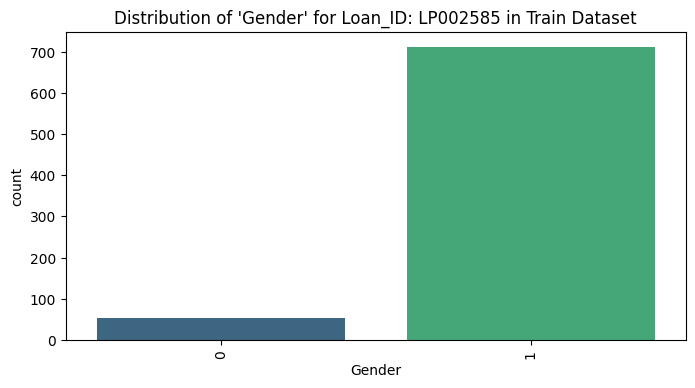

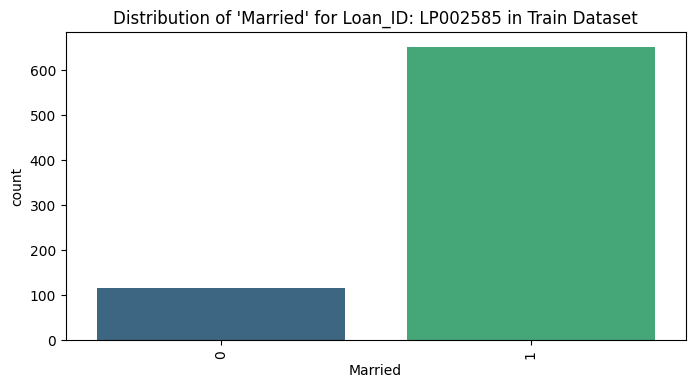

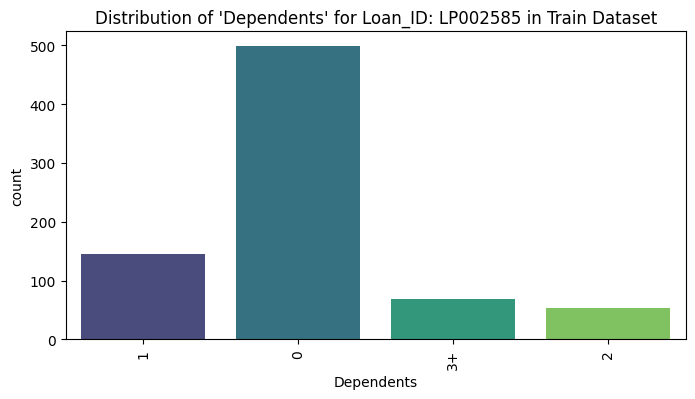

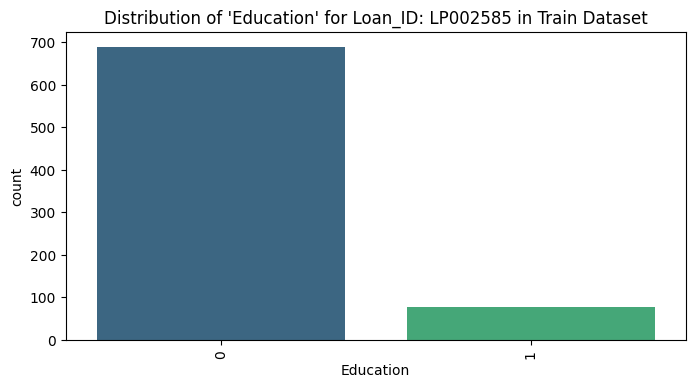

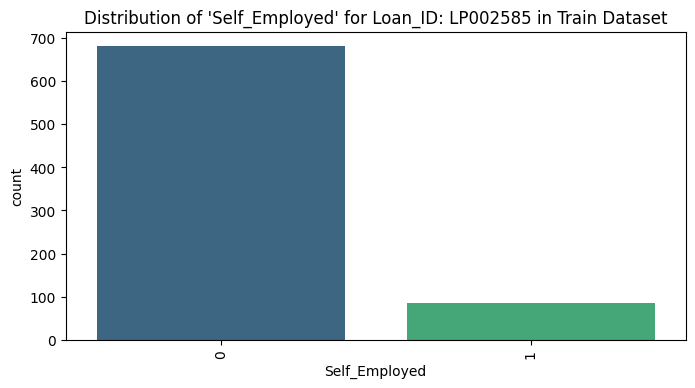

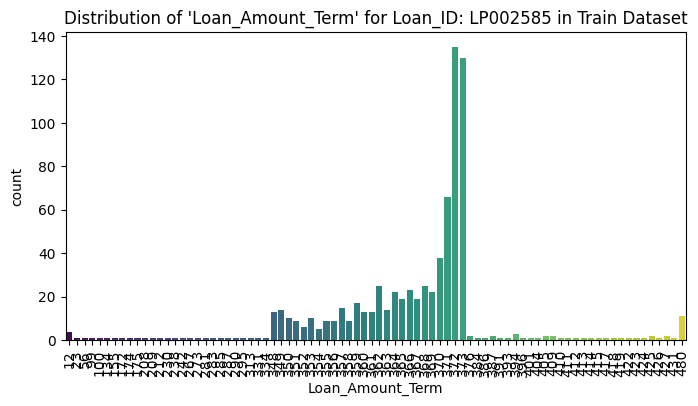

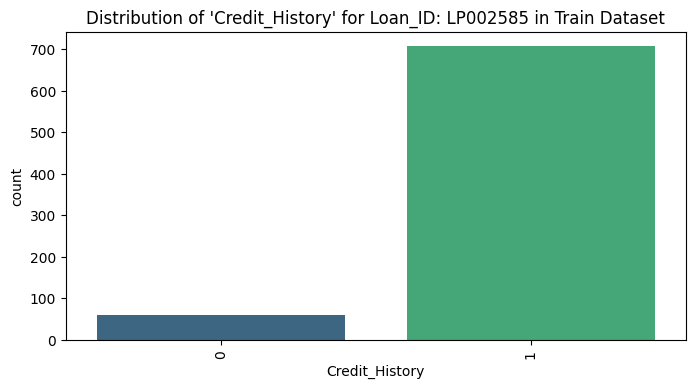

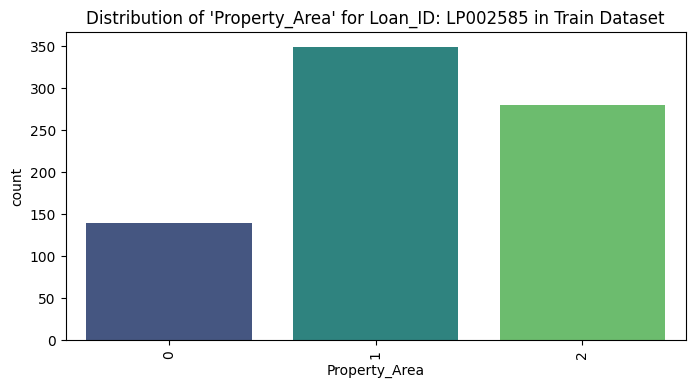

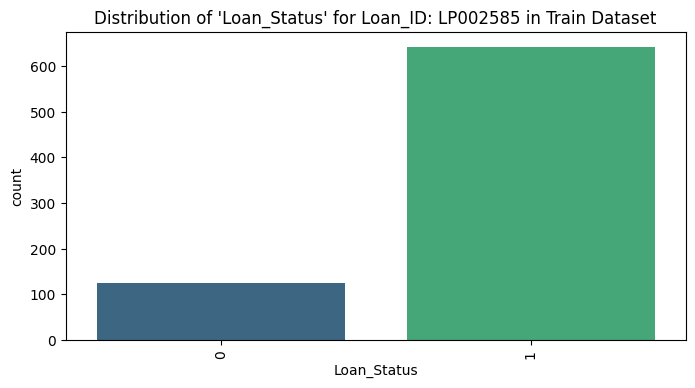

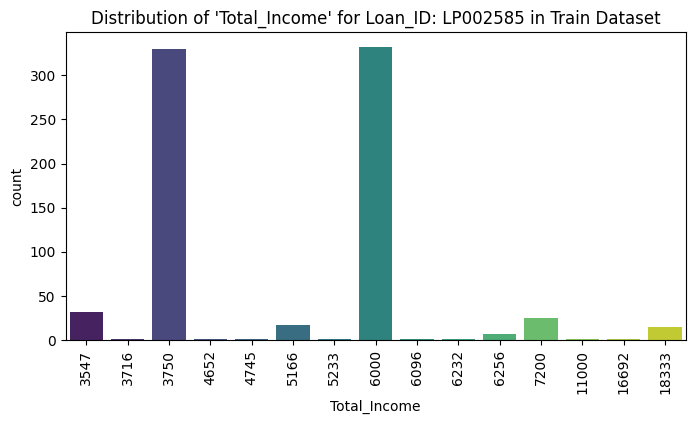


--- Visualization for Loan_ID: LP002187 (Occurrences: 740) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


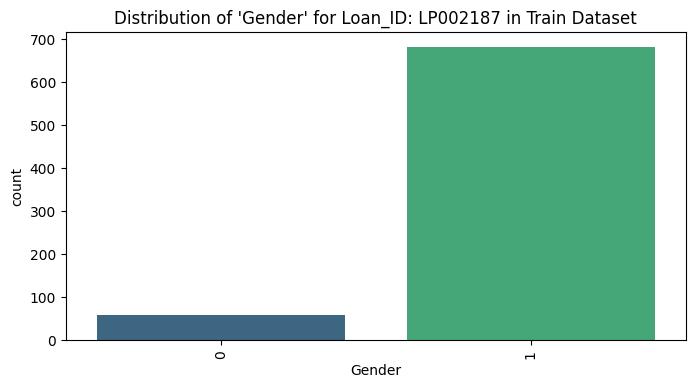

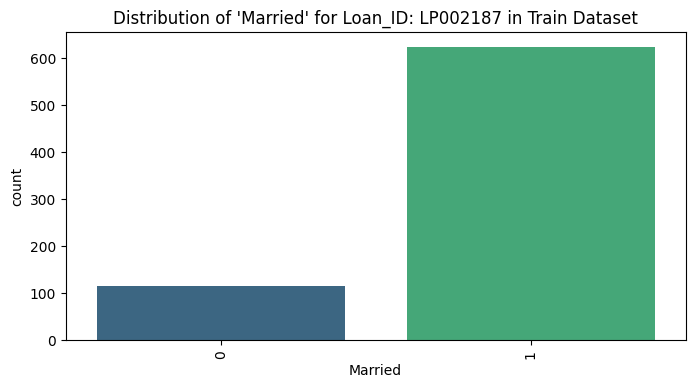

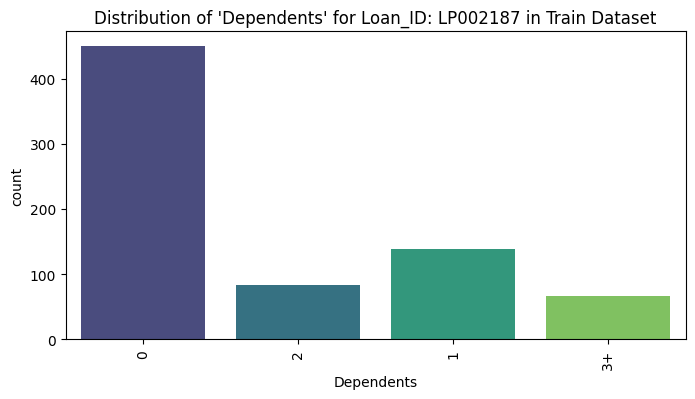

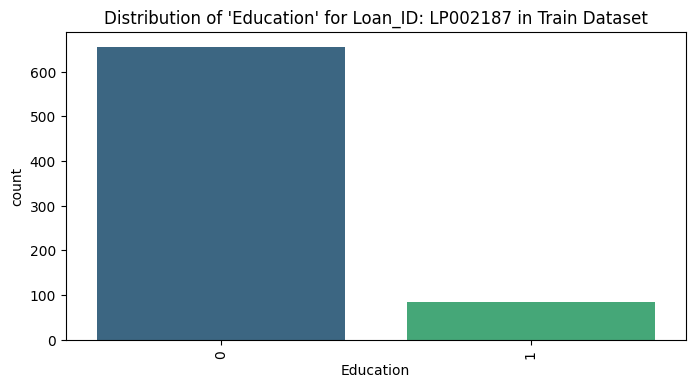

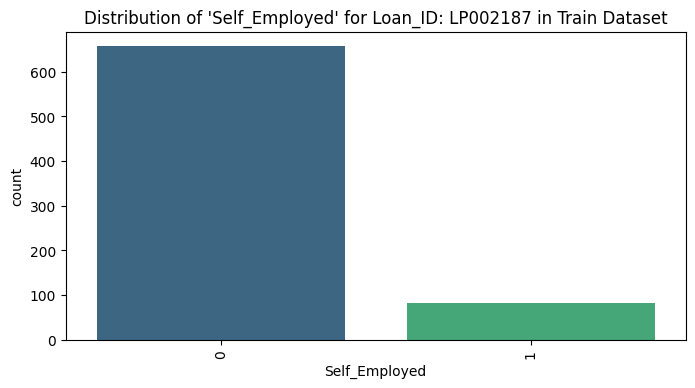

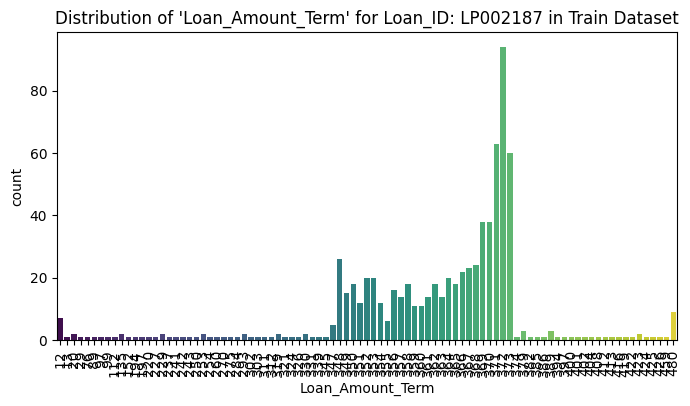

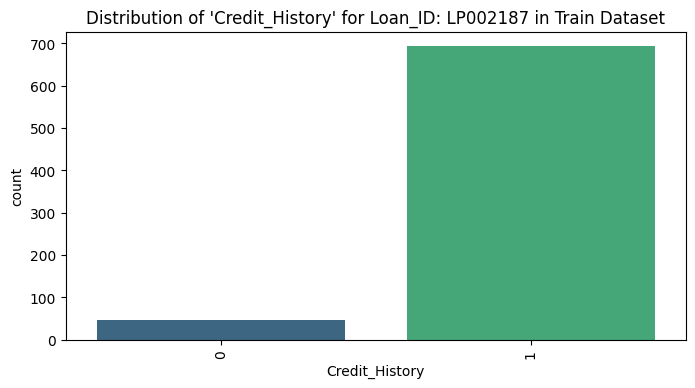

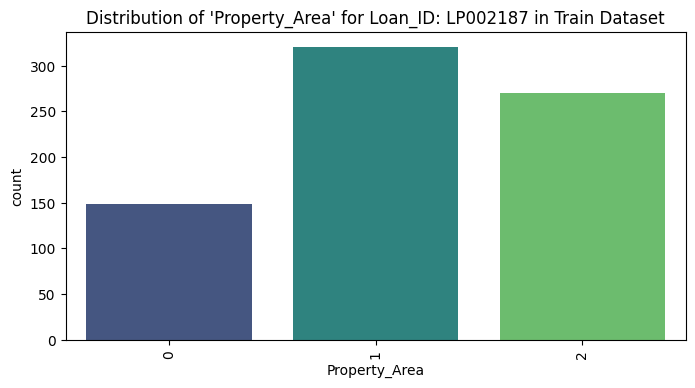

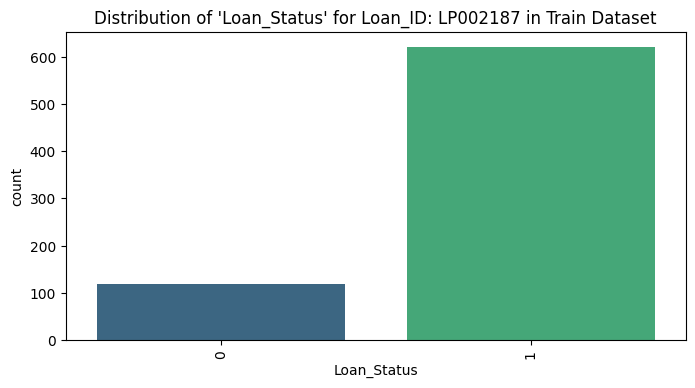

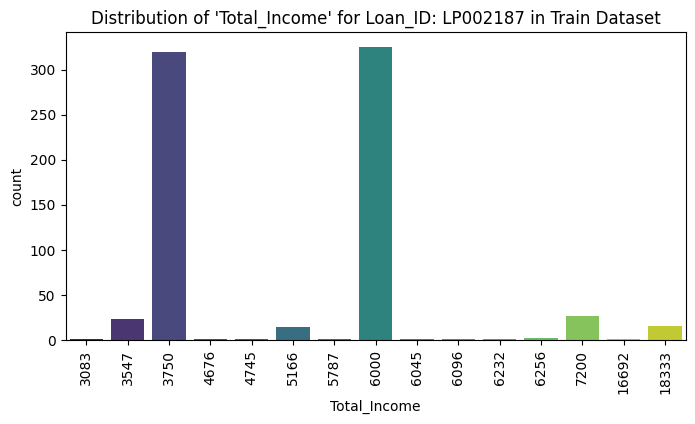


--- Visualization for Loan_ID: LP002231 (Occurrences: 718) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


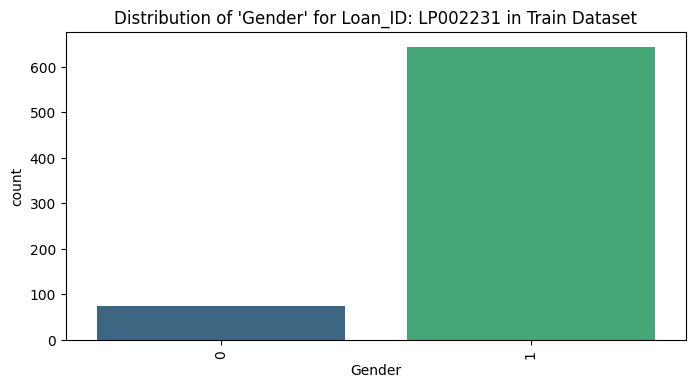

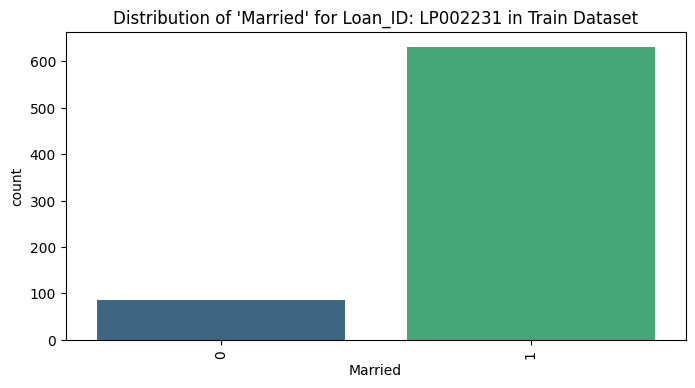

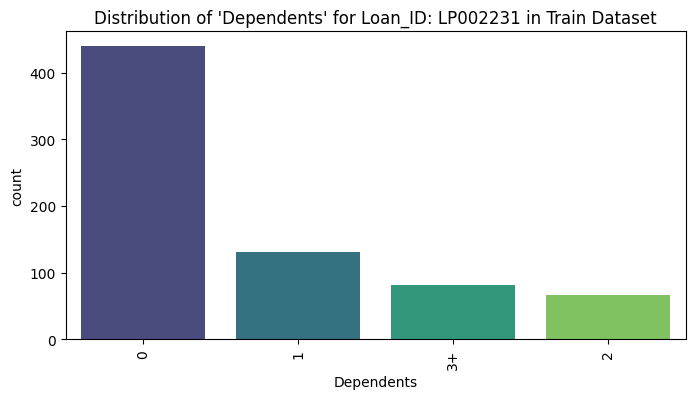

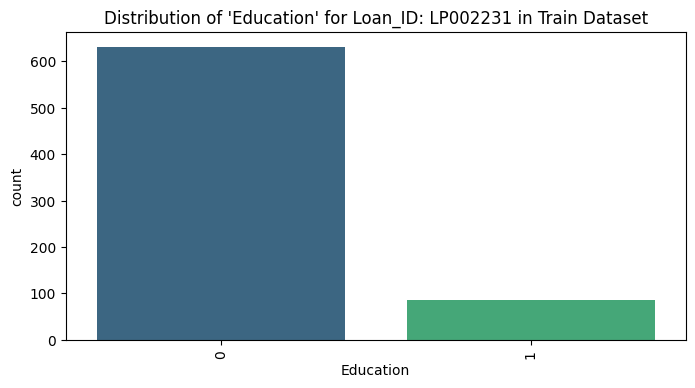

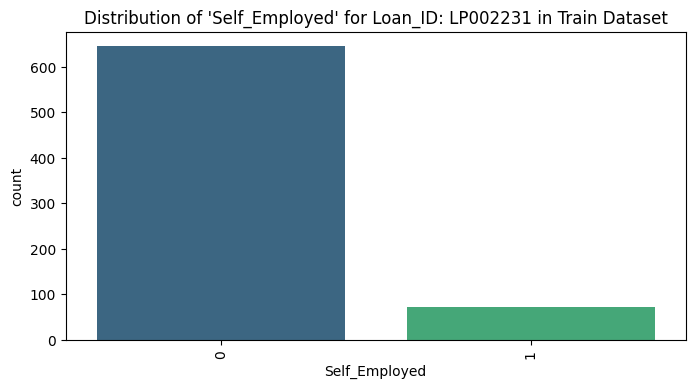

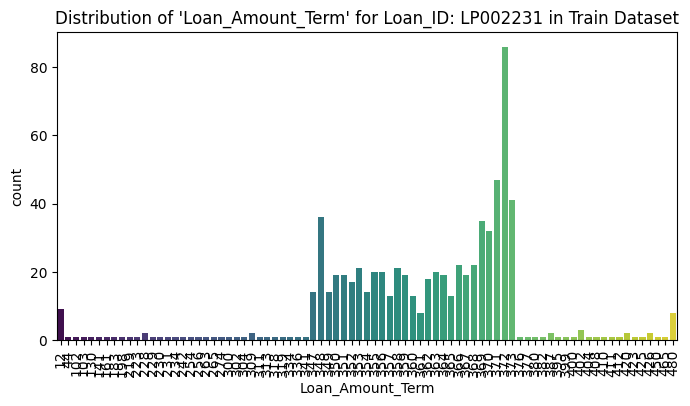

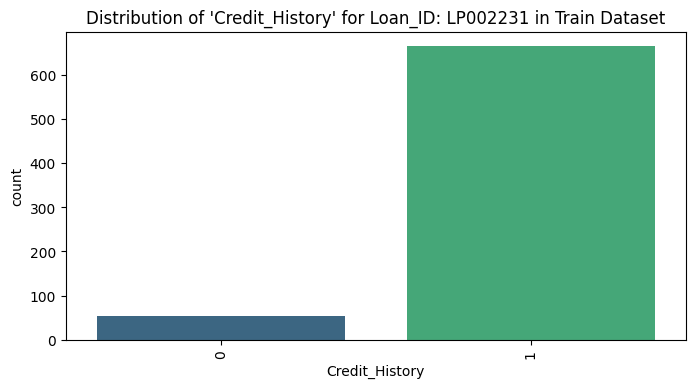

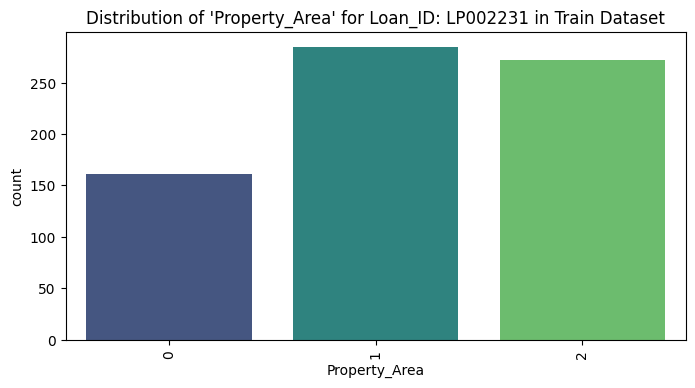

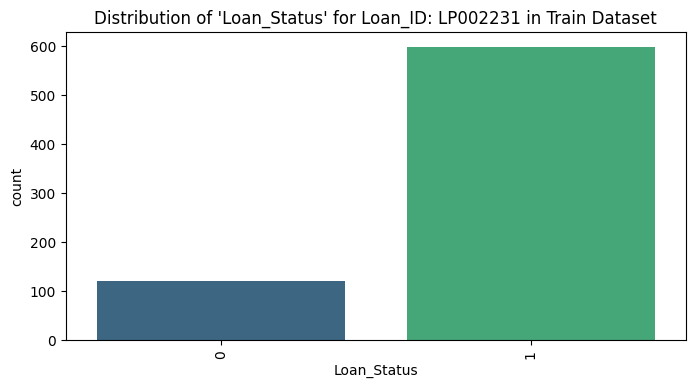

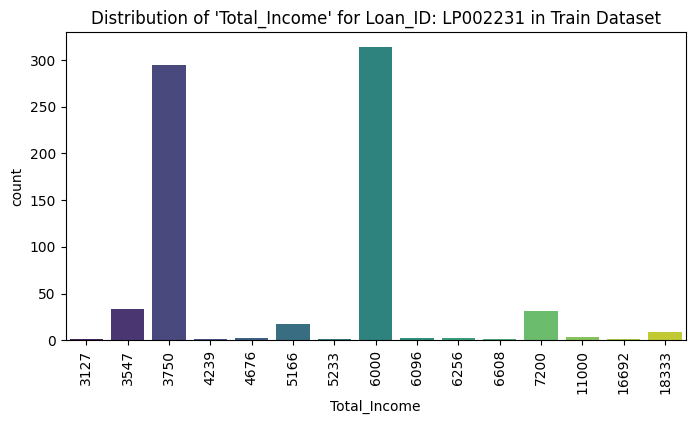


--- Visualization for Loan_ID: LP002175 (Occurrences: 463) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


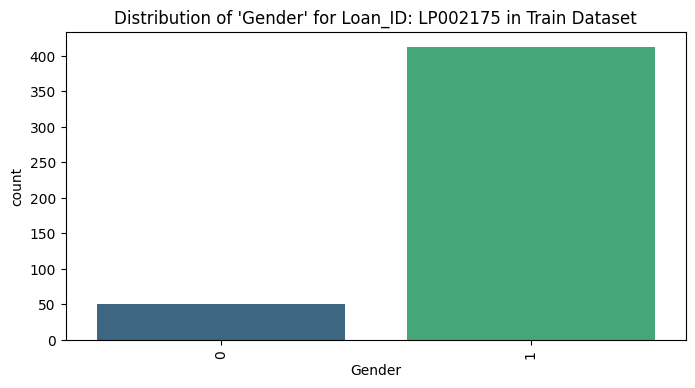

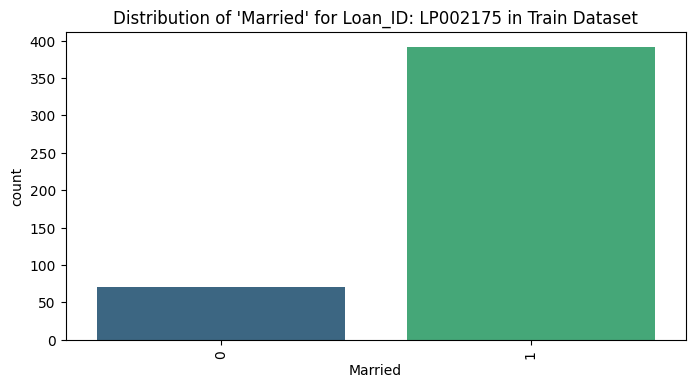

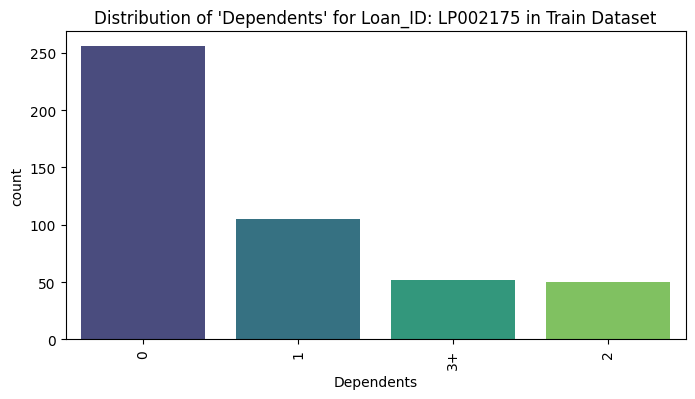

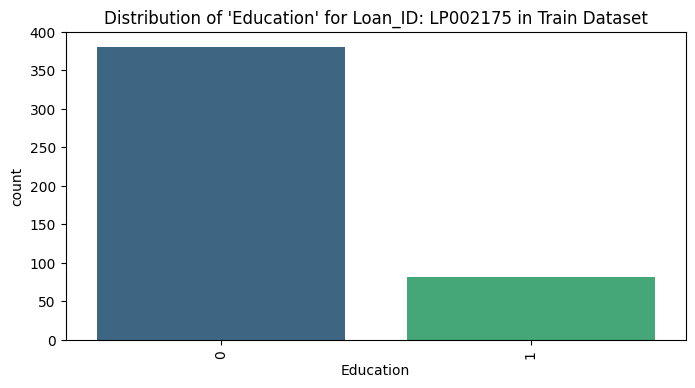

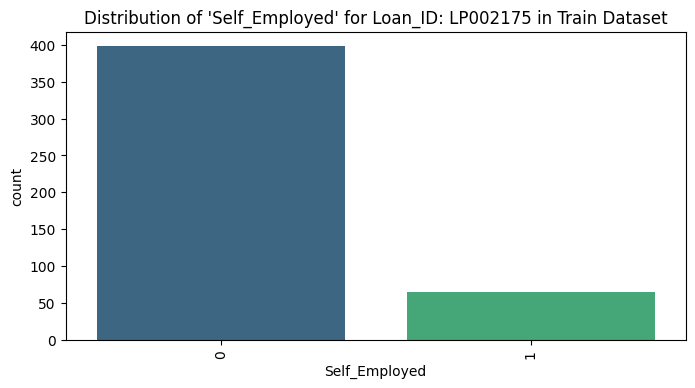

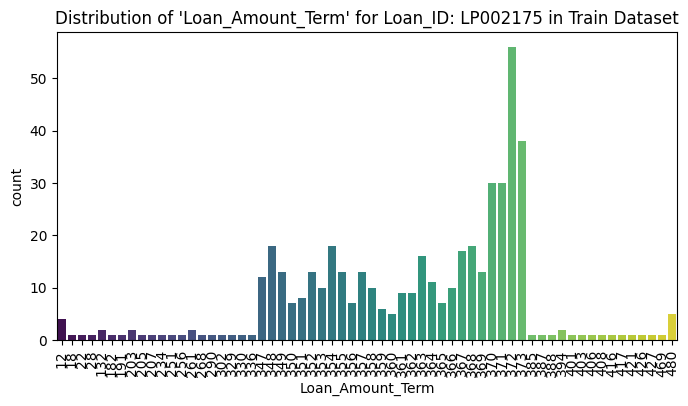

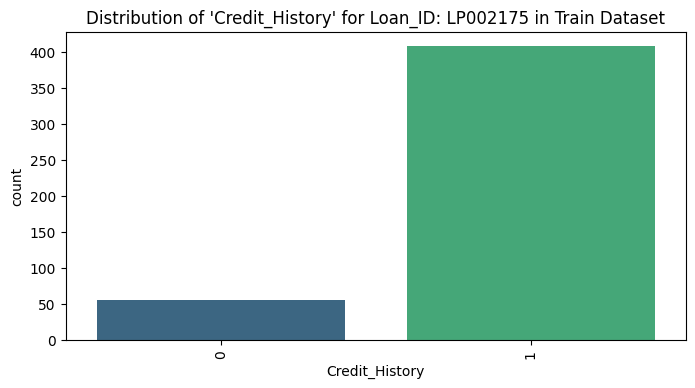

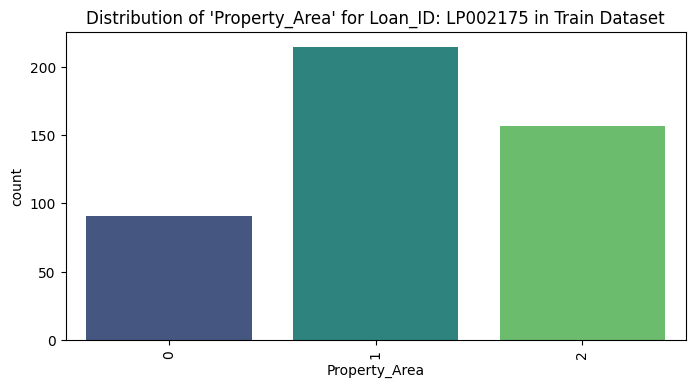

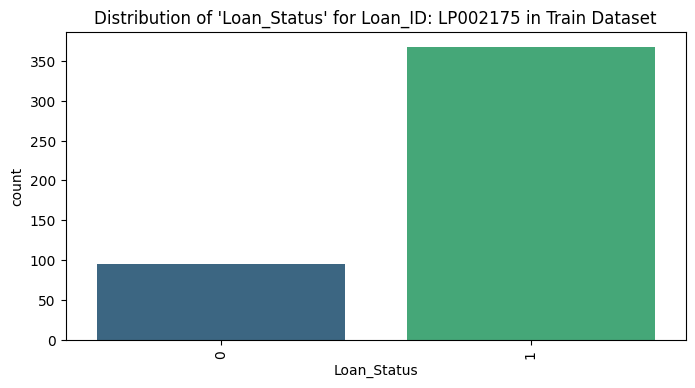

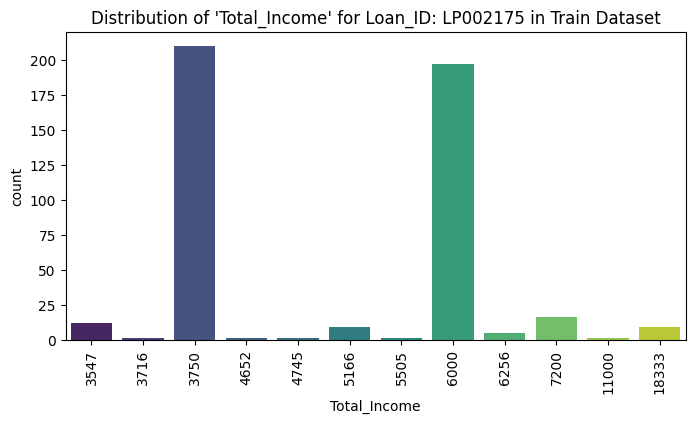


--- Visualization for Loan_ID: LP002224 (Occurrences: 364) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


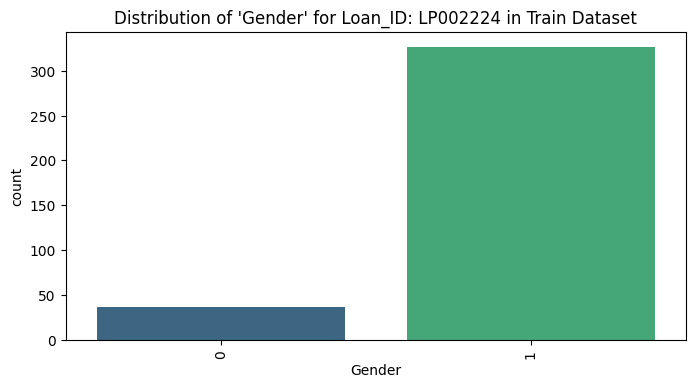

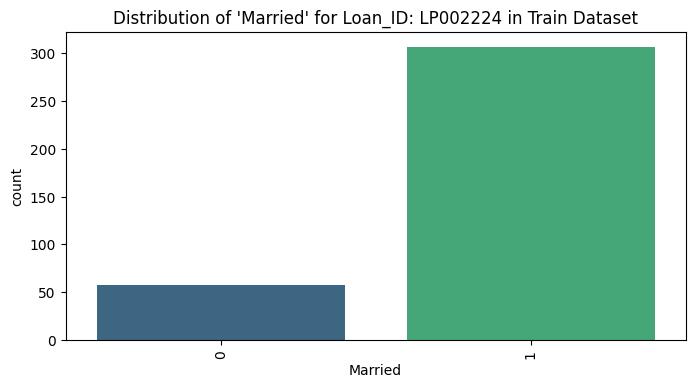

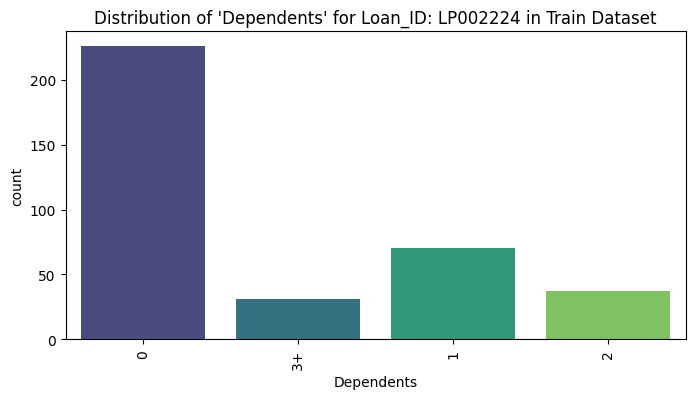

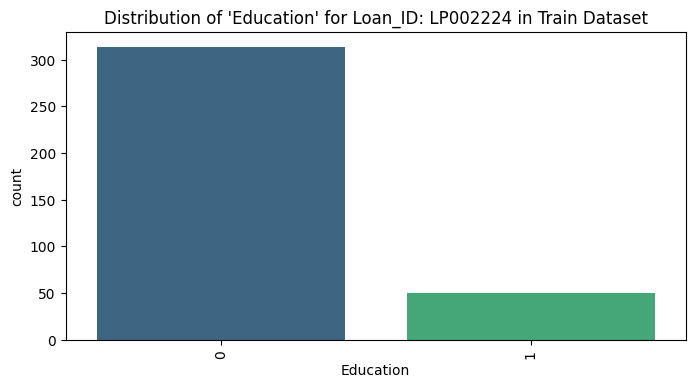

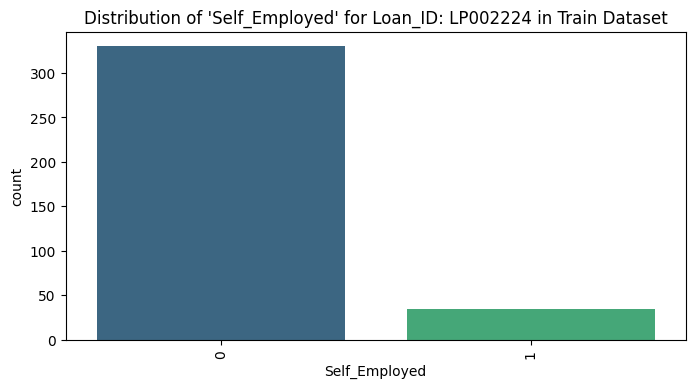

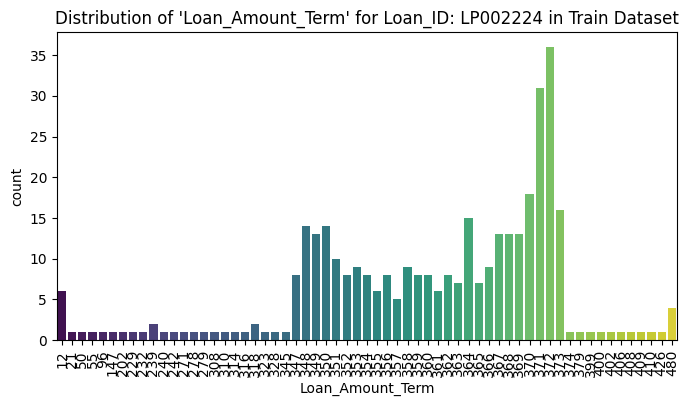

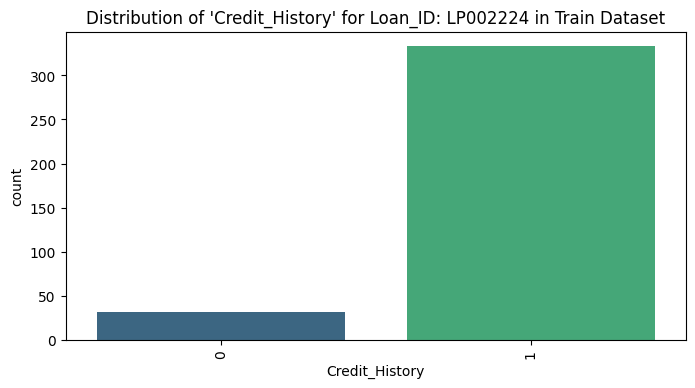

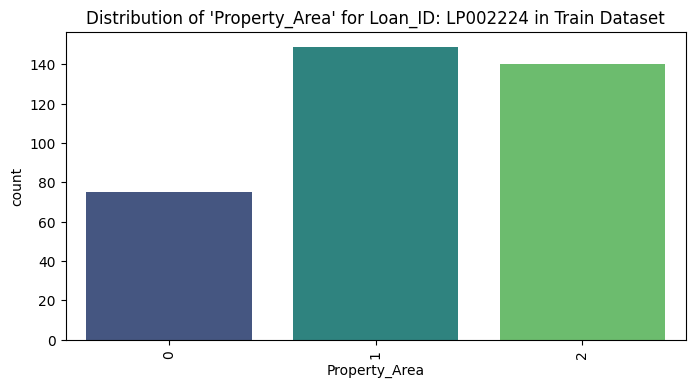

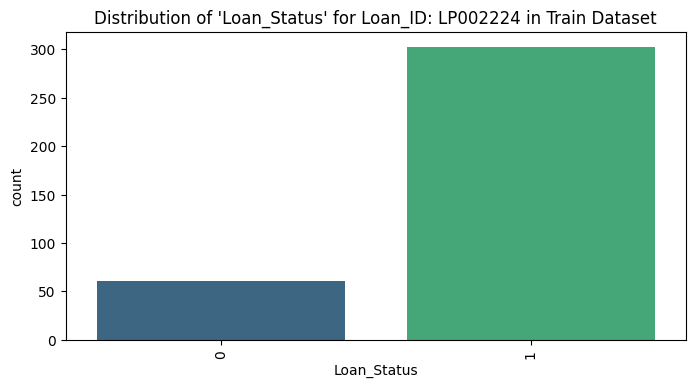

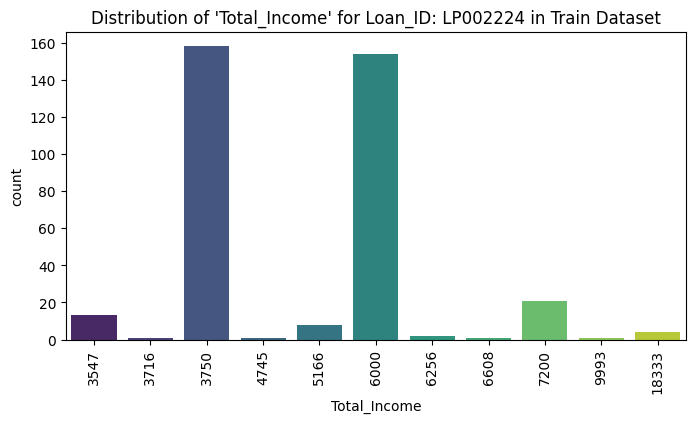


--- Visualization for Loan_ID: LP002560 (Occurrences: 364) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


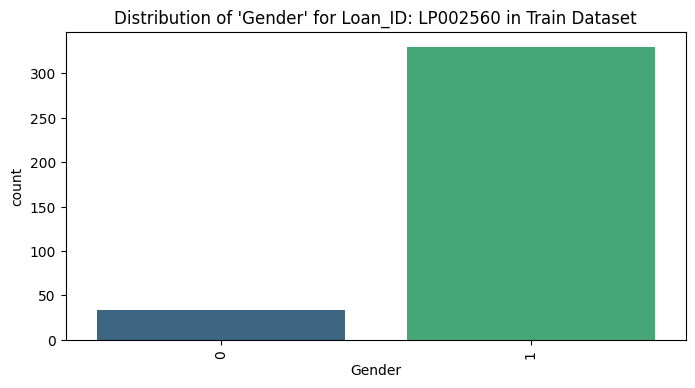

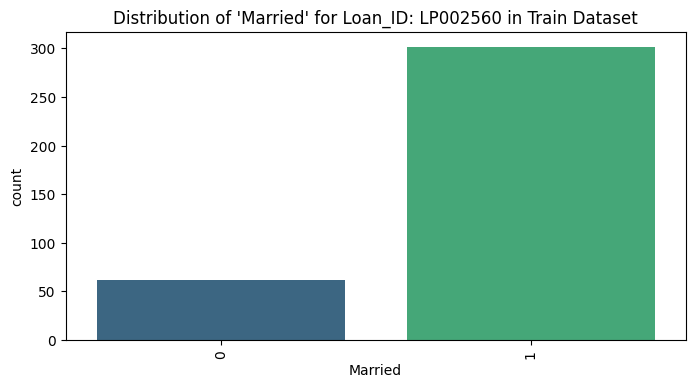

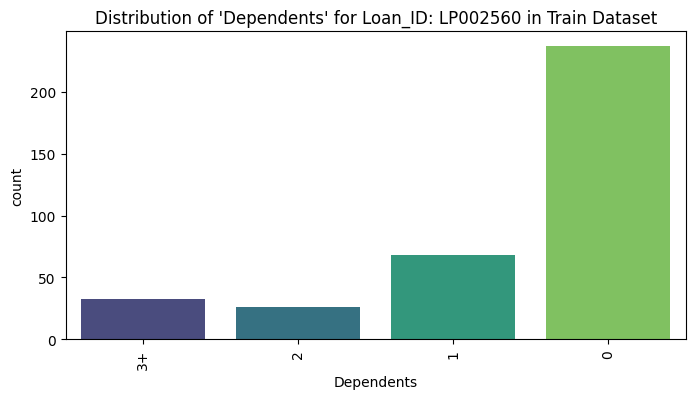

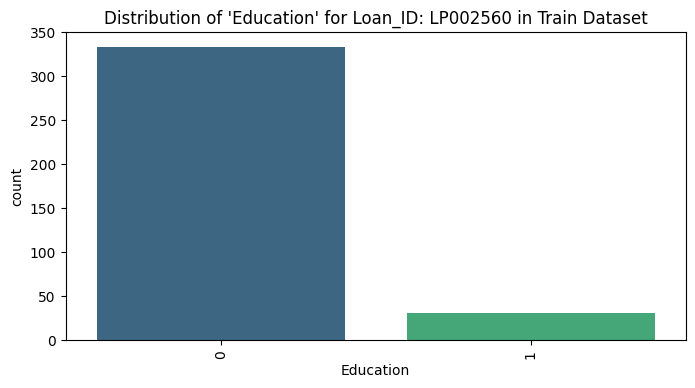

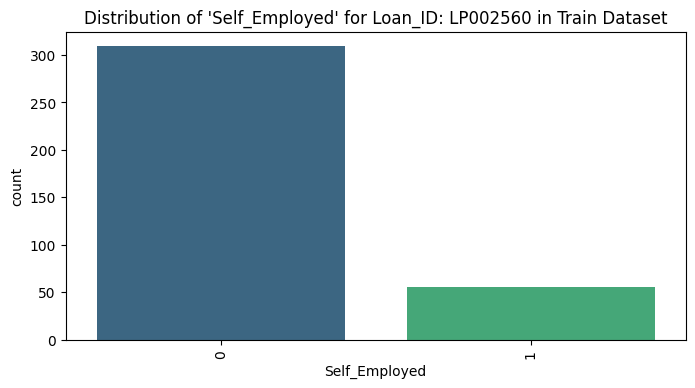

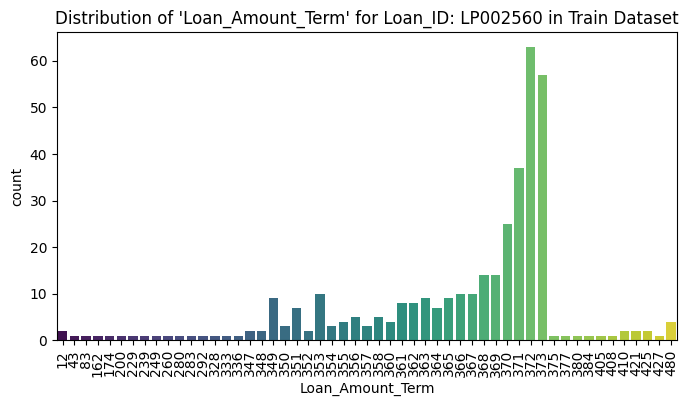

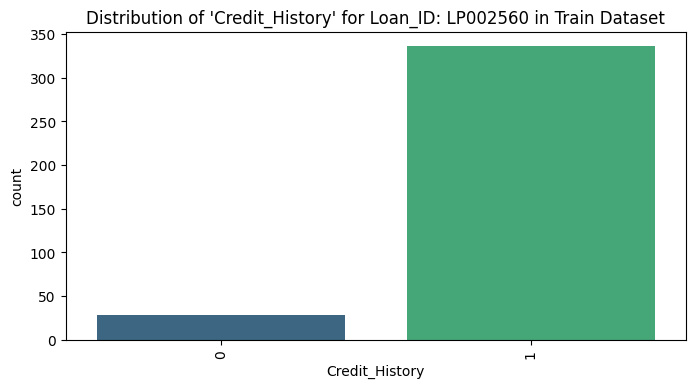

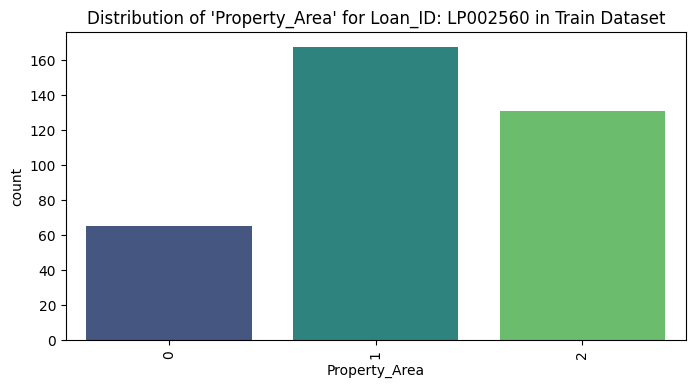

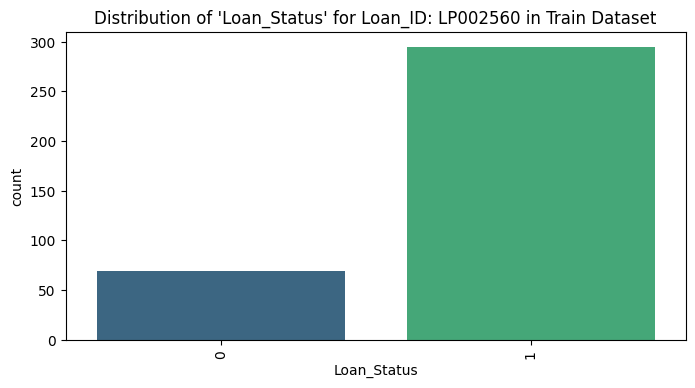

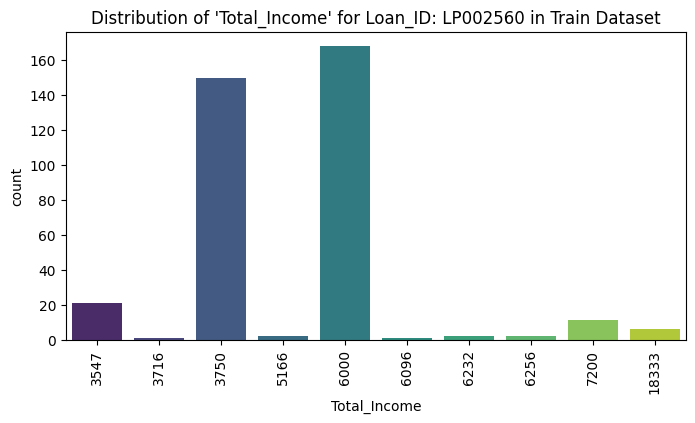


--- Visualization for Loan_ID: LP001790 (Occurrences: 107) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


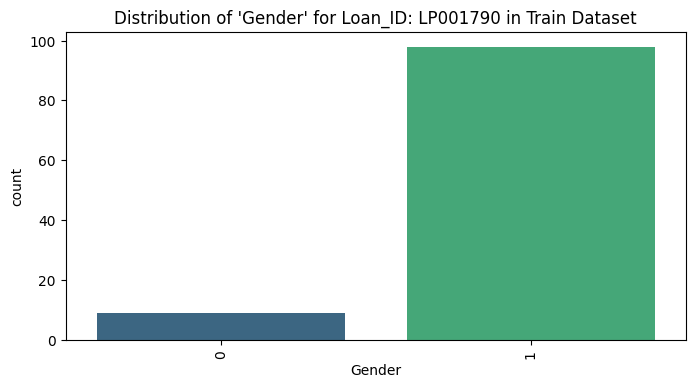

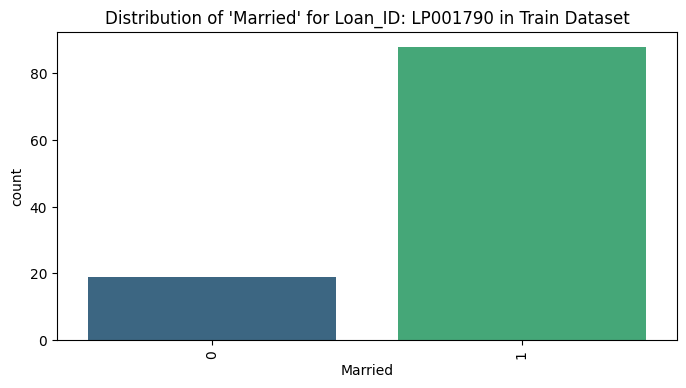

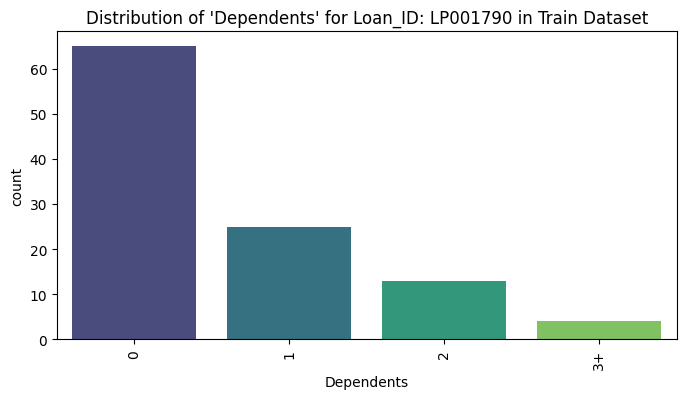

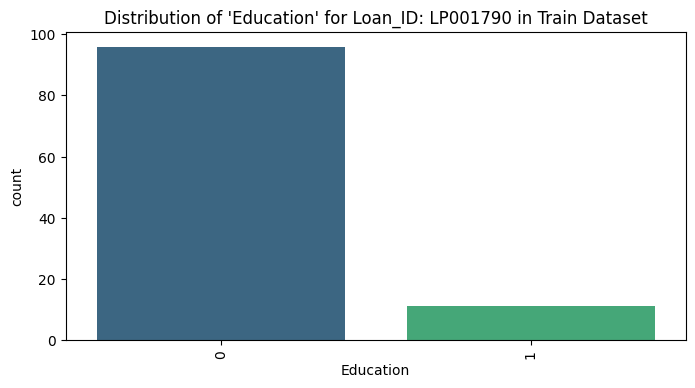

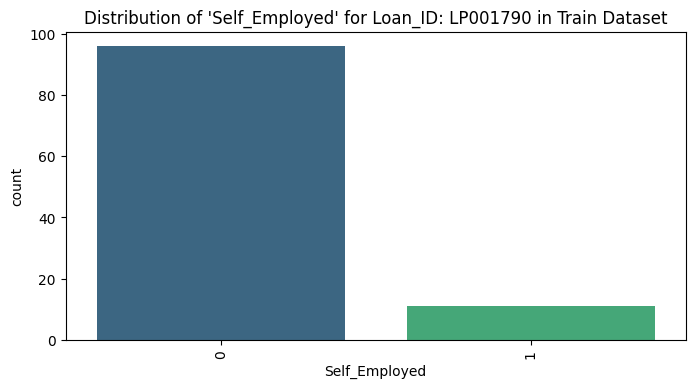

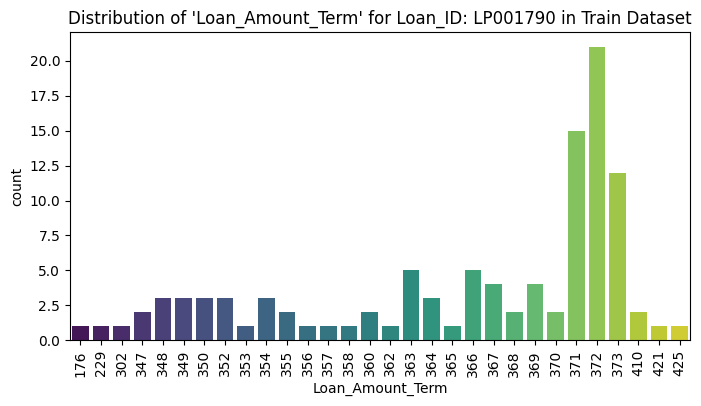

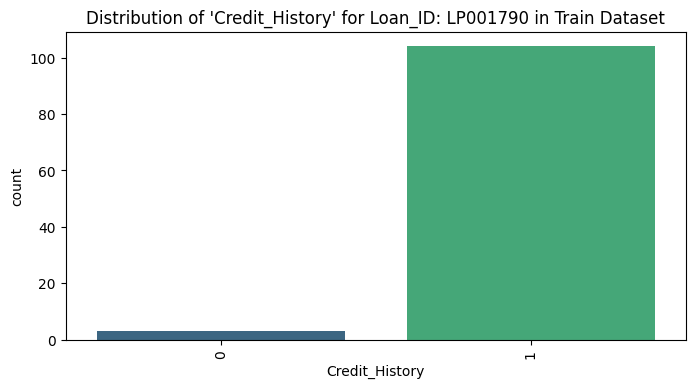

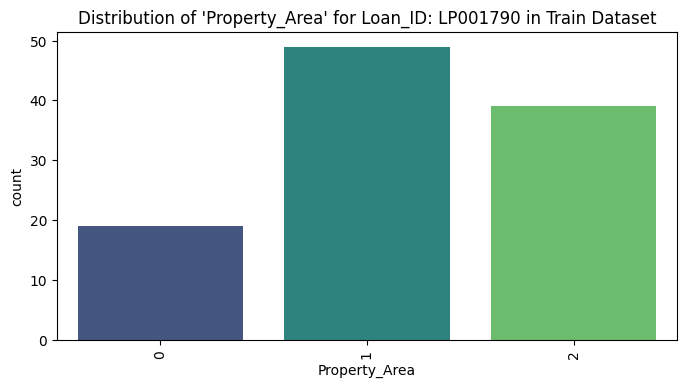

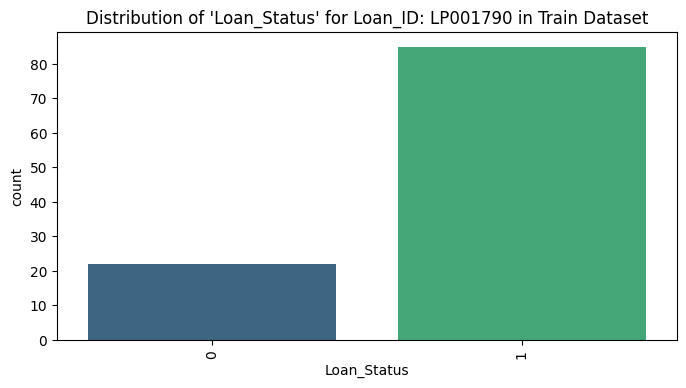

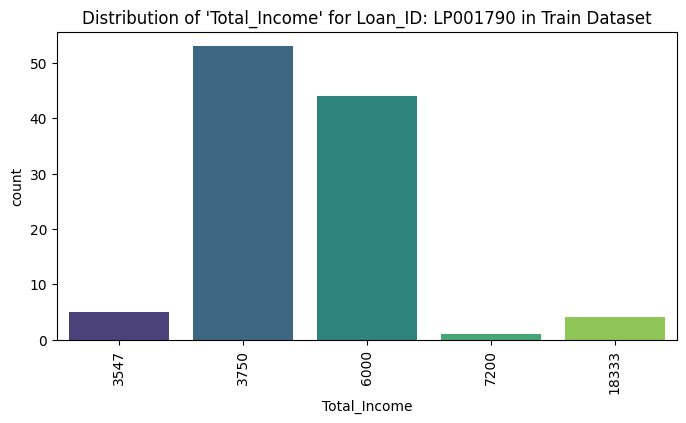


--- Visualization for Loan_ID: LP002582 (Occurrences: 105) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


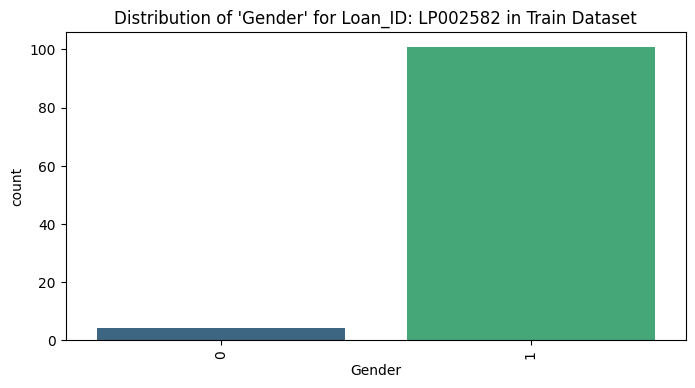

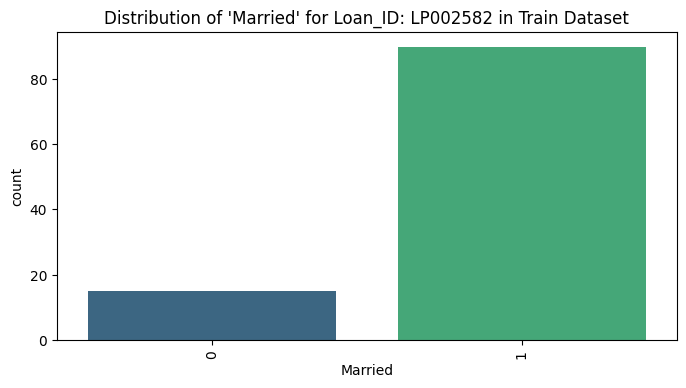

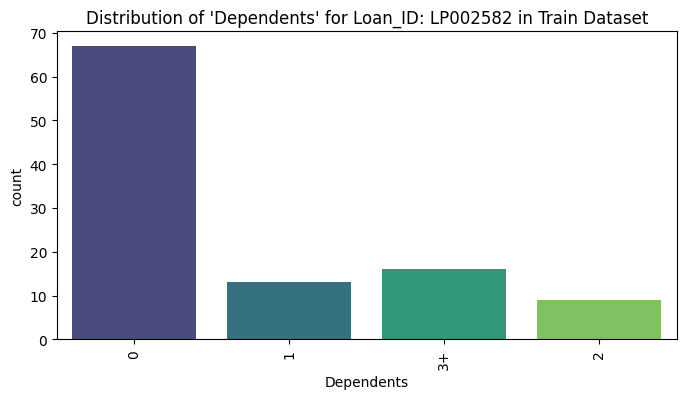

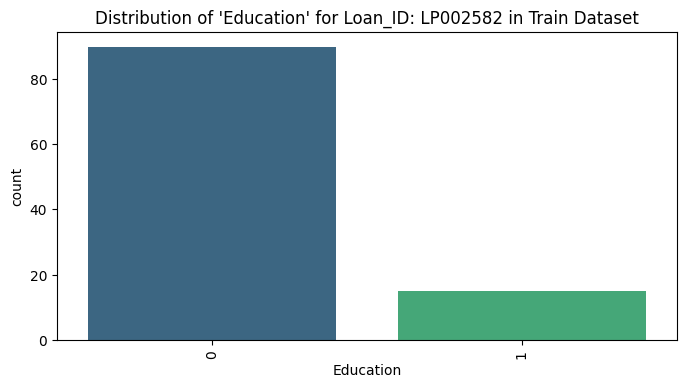

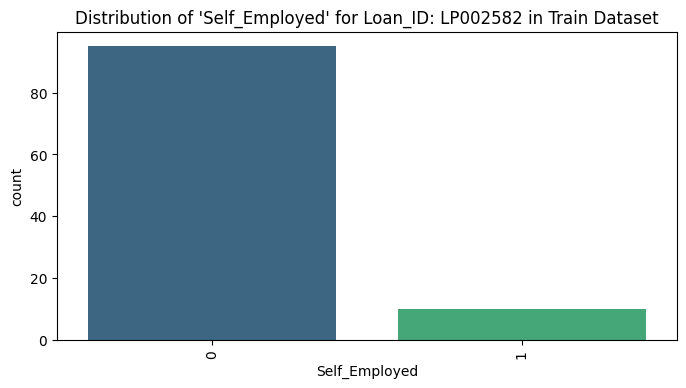

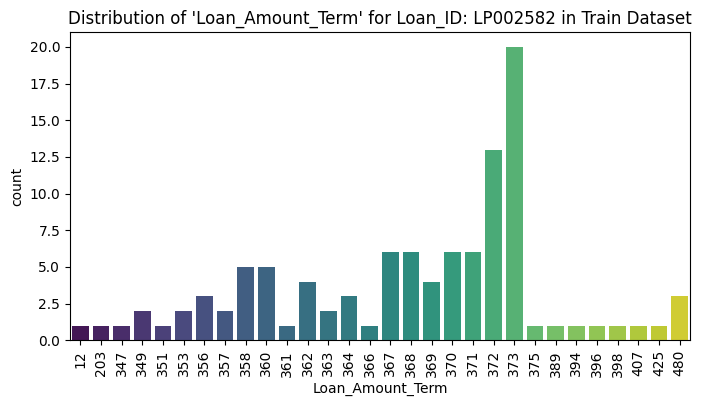

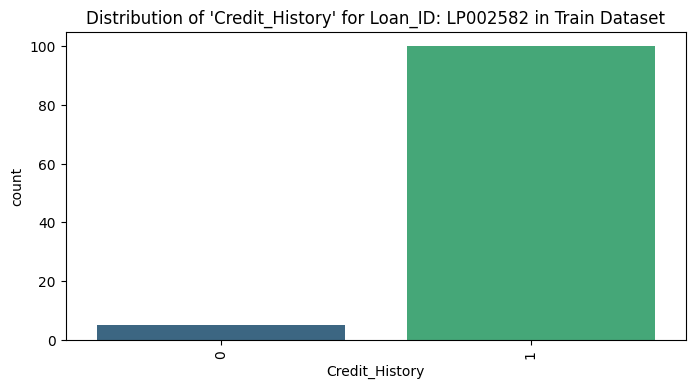

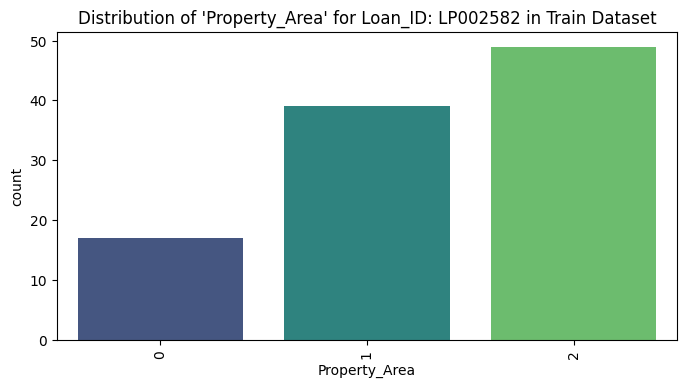

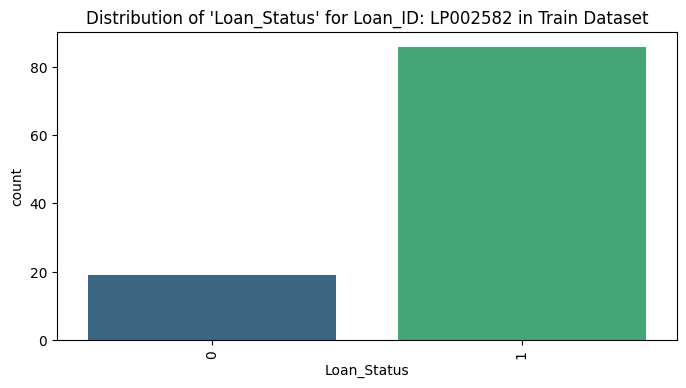

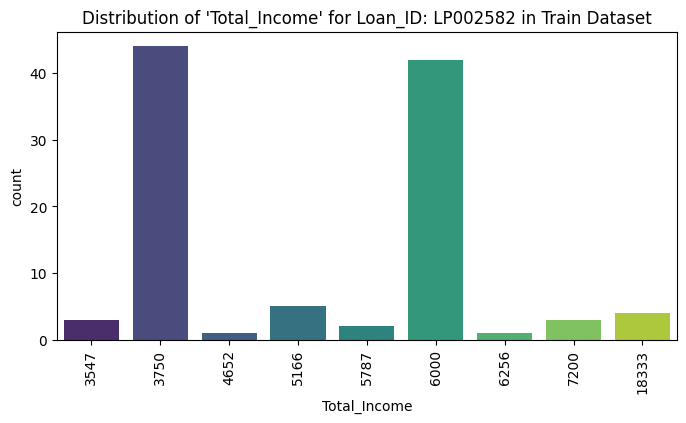


--- Visualization for Loan_ID: LP001385 (Occurrences: 105) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


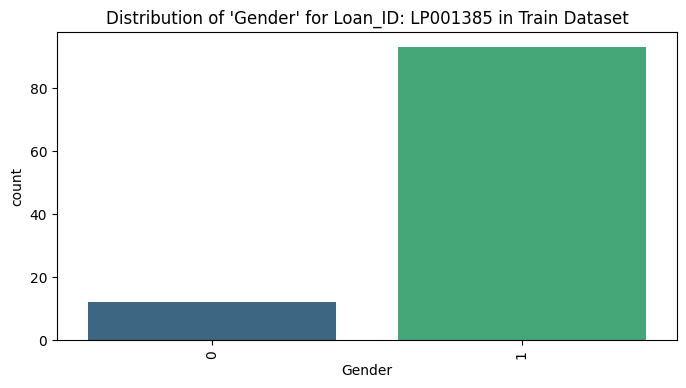

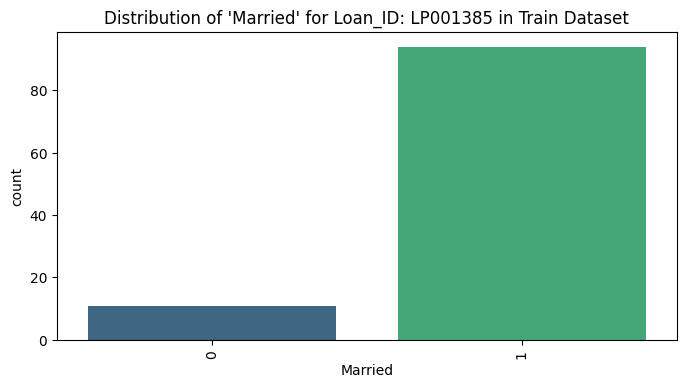

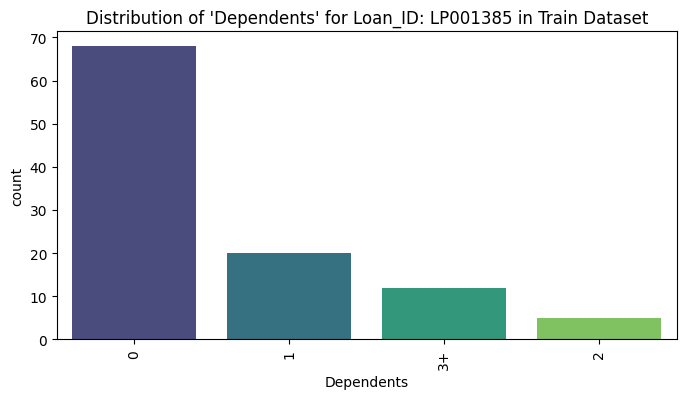

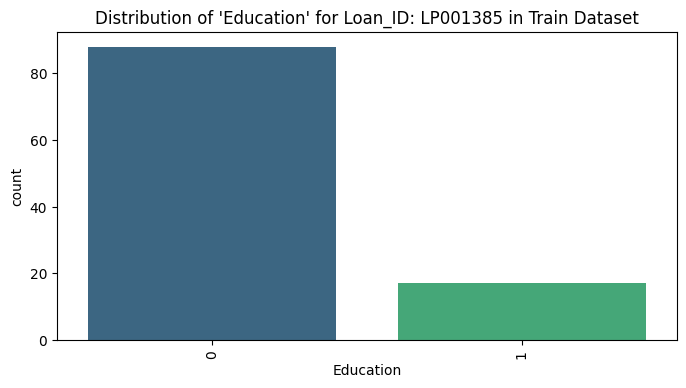

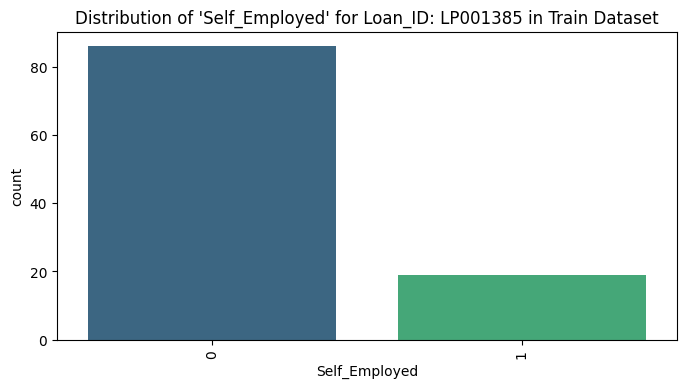

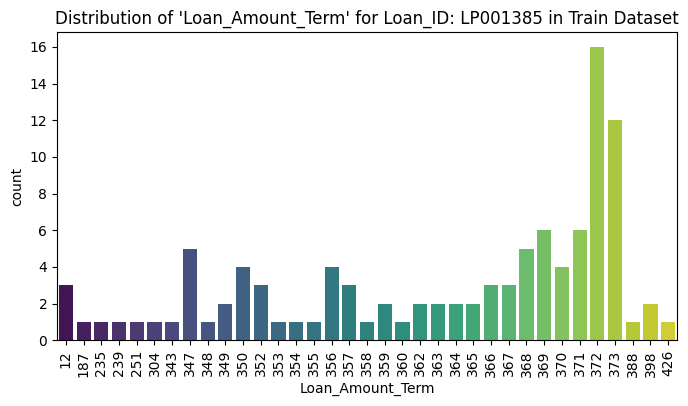

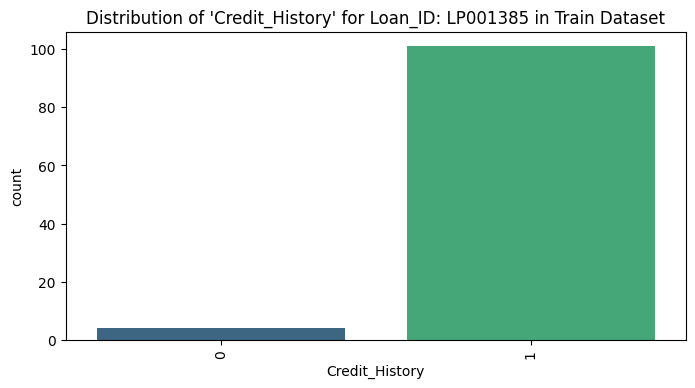

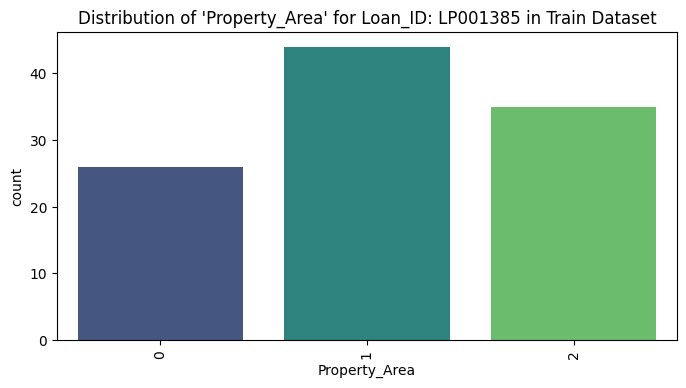

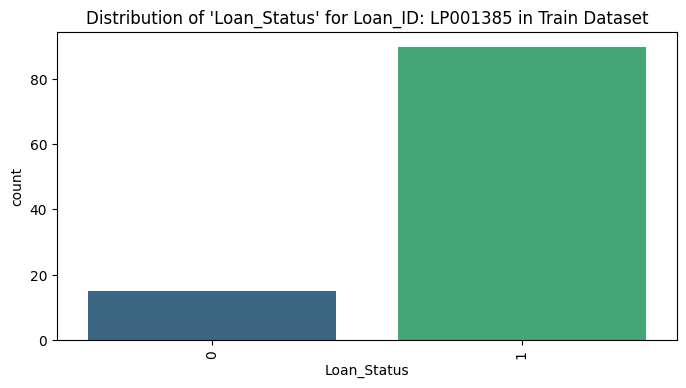

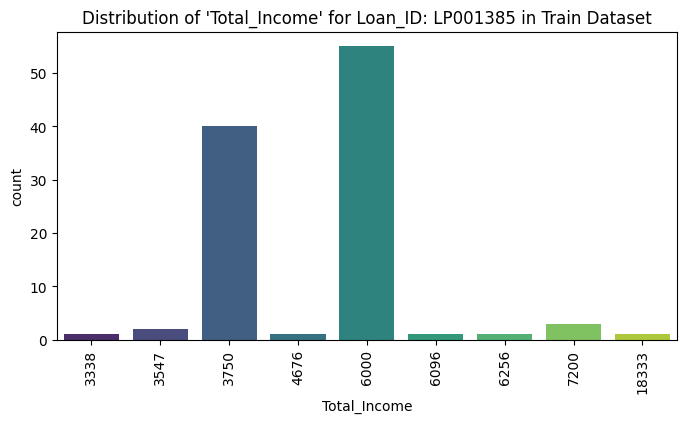


--- Visualization for Loan_ID: LP002181 (Occurrences: 94) in Dataset: Train ---
Identical values across occurrences:

Differing values visualization:


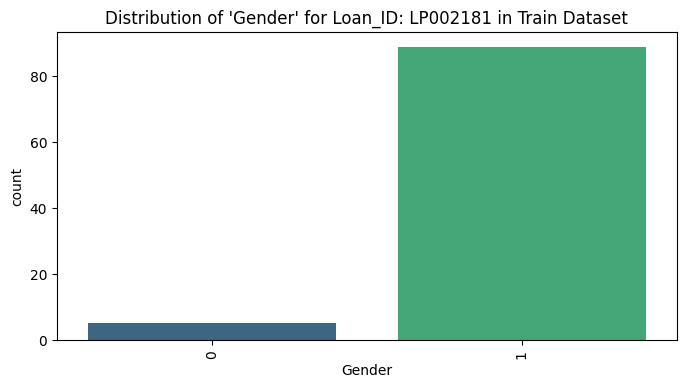

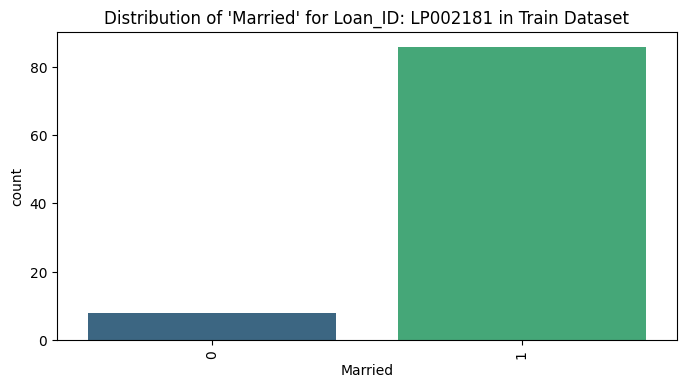

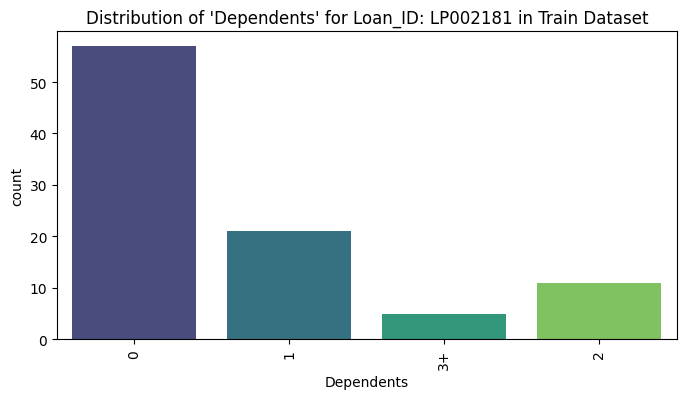

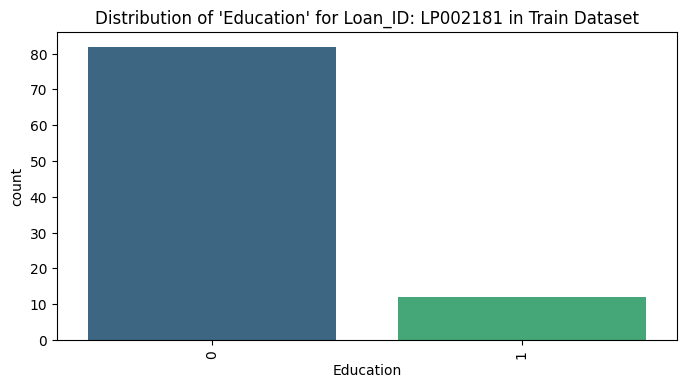

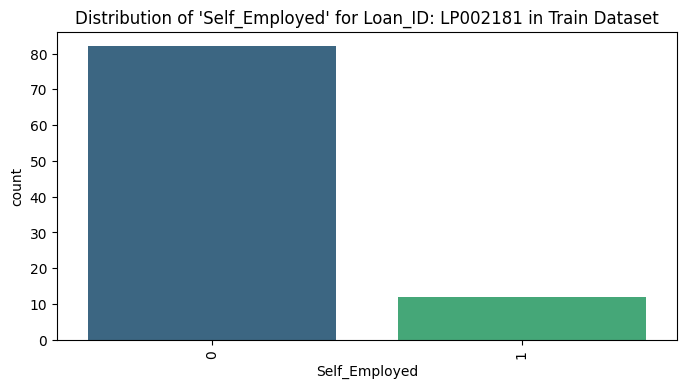

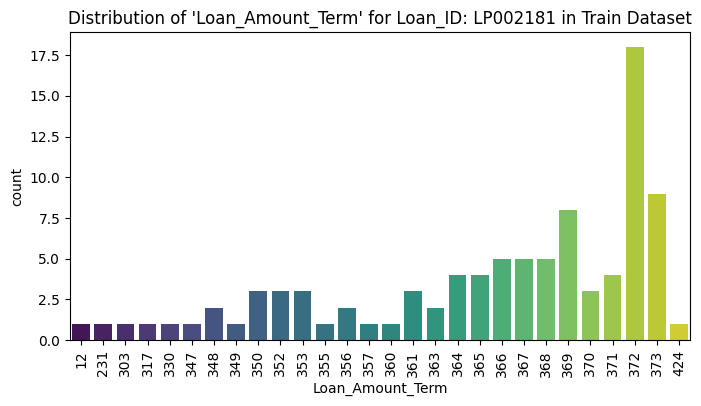

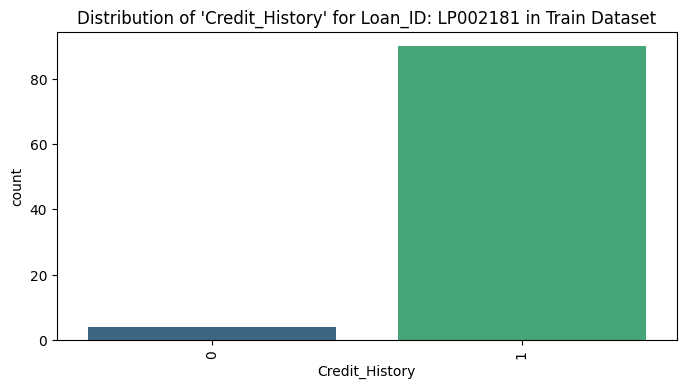

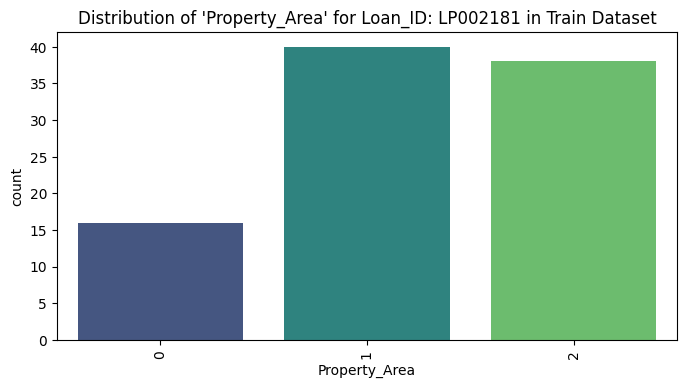

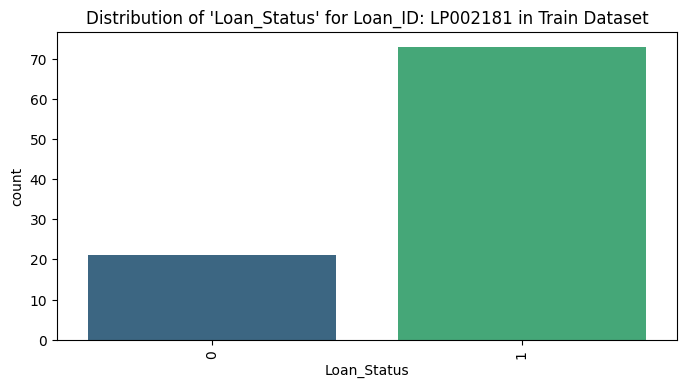

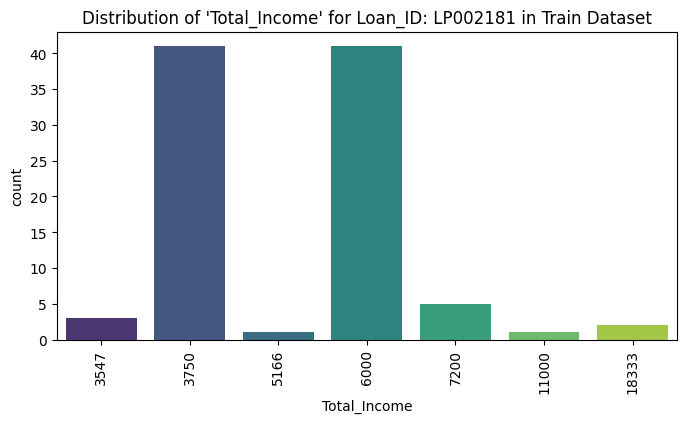


--- Visualization for Loan_ID: LP002187 (Occurrences: 355) in Dataset: Test ---
Identical values across occurrences:

Differing values visualization:


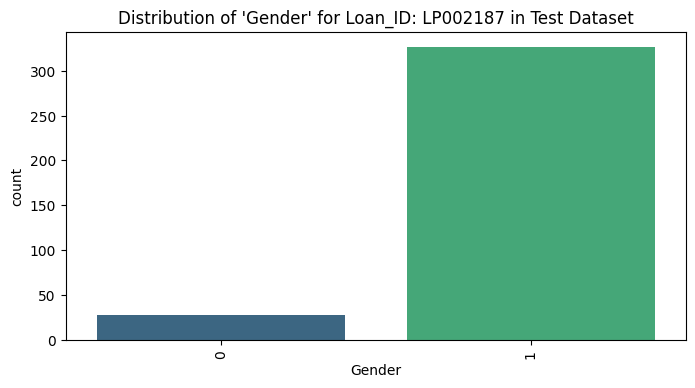

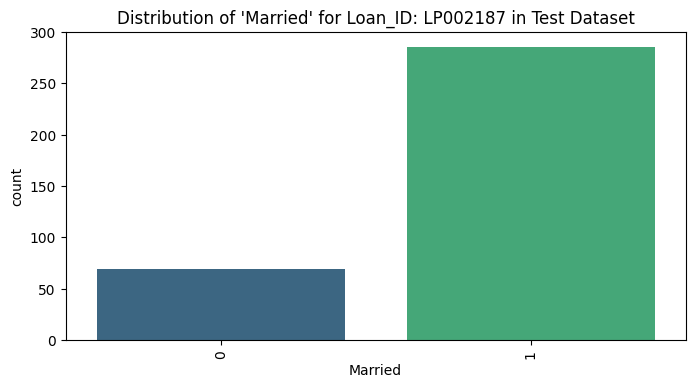

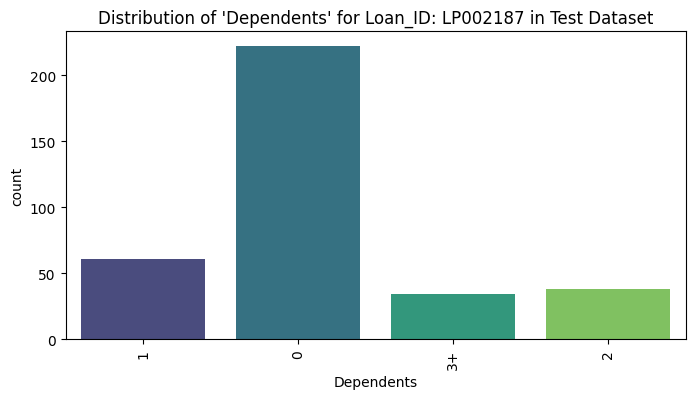

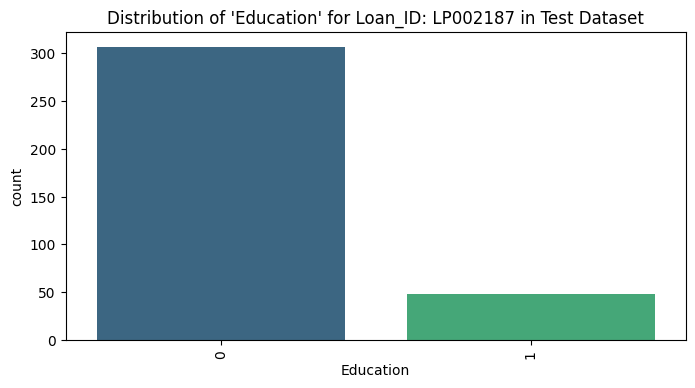

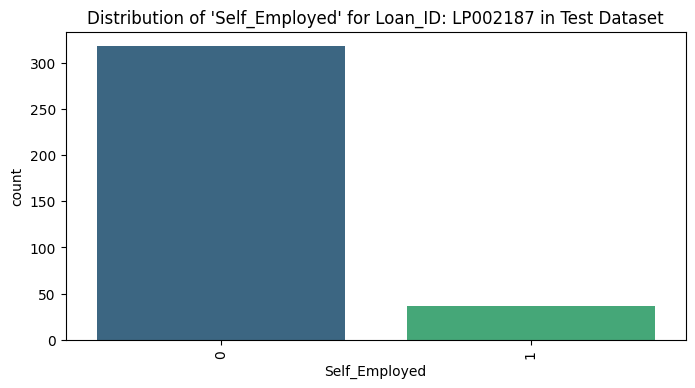

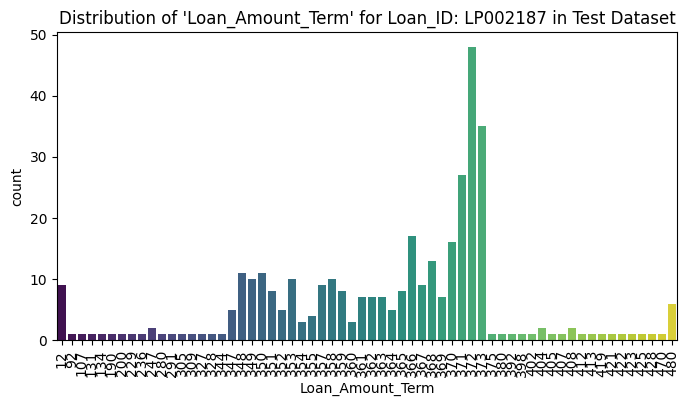

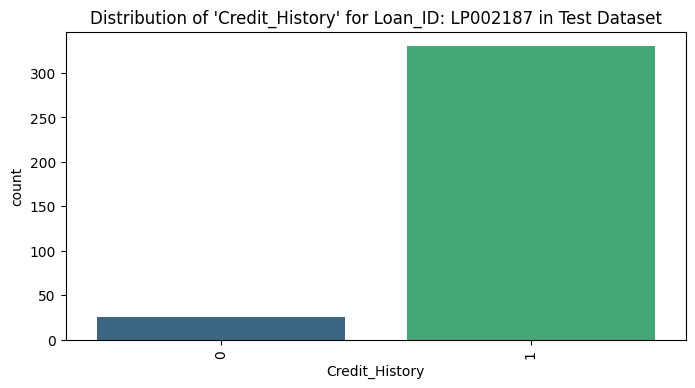

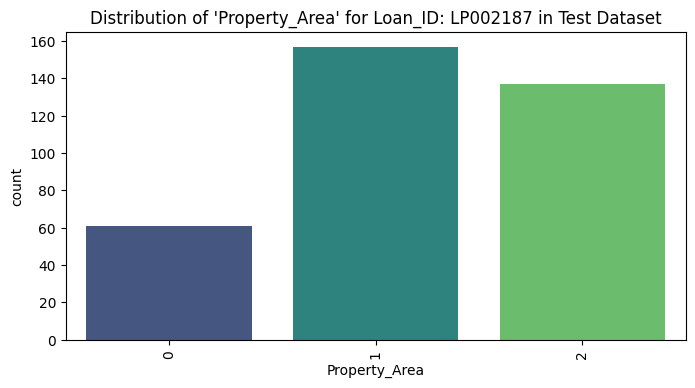

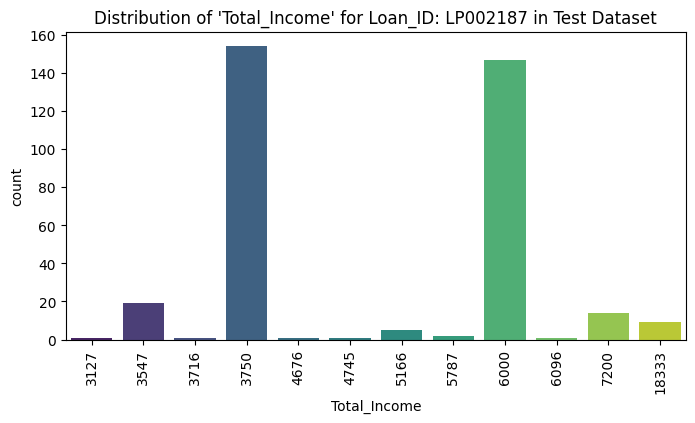


--- Visualization for Loan_ID: LP002231 (Occurrences: 310) in Dataset: Test ---
Identical values across occurrences:

Differing values visualization:


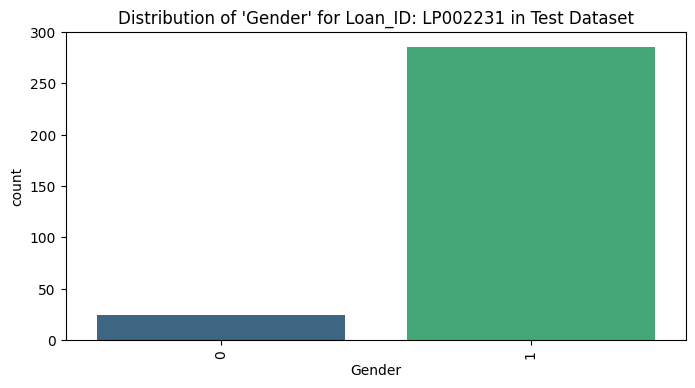

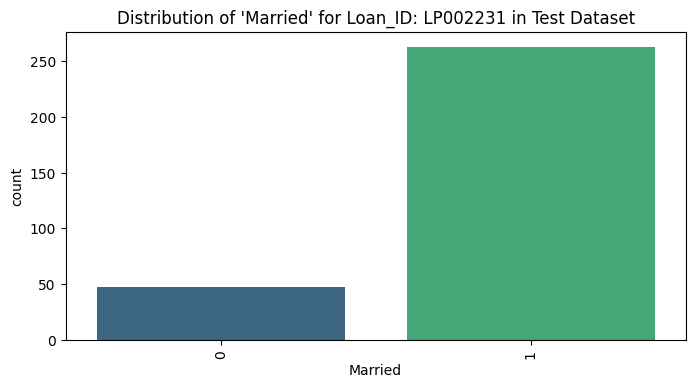

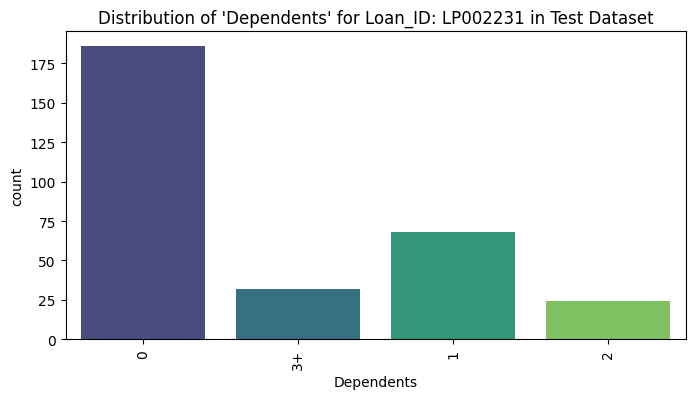

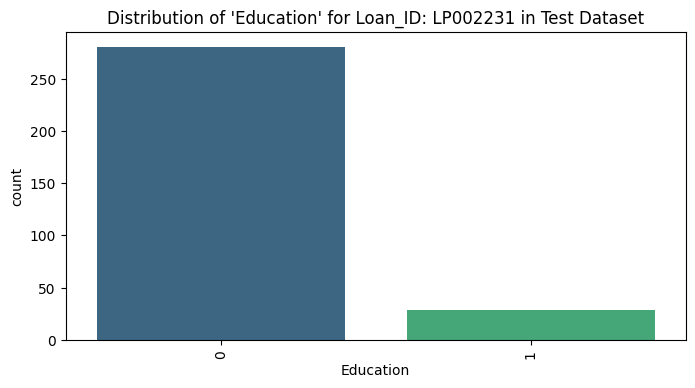

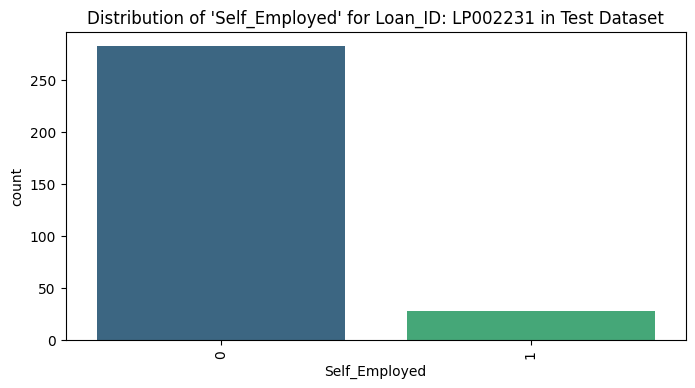

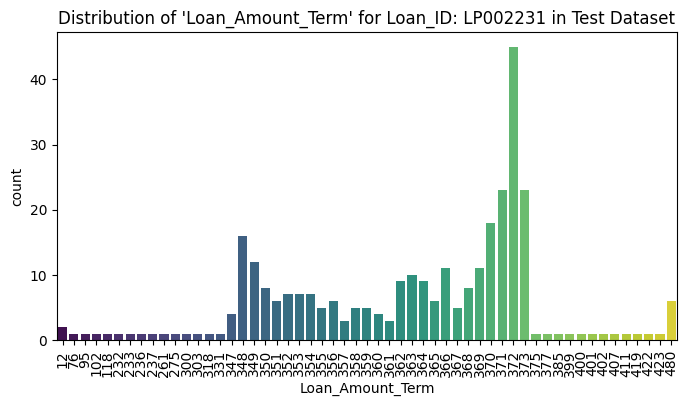

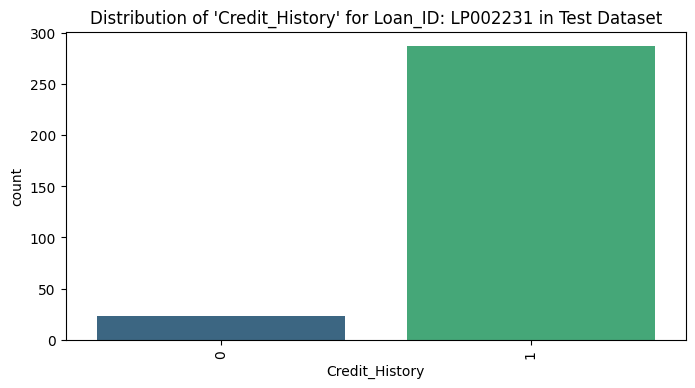

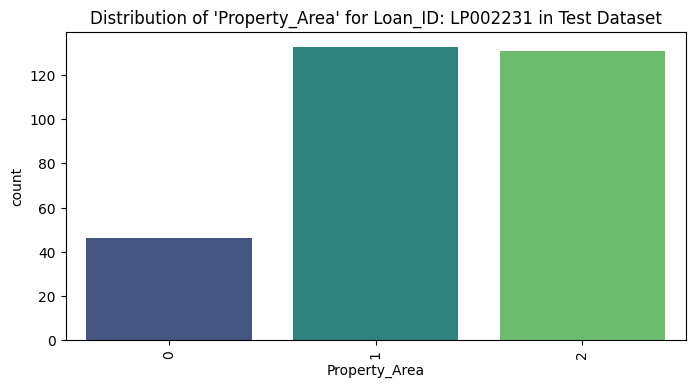

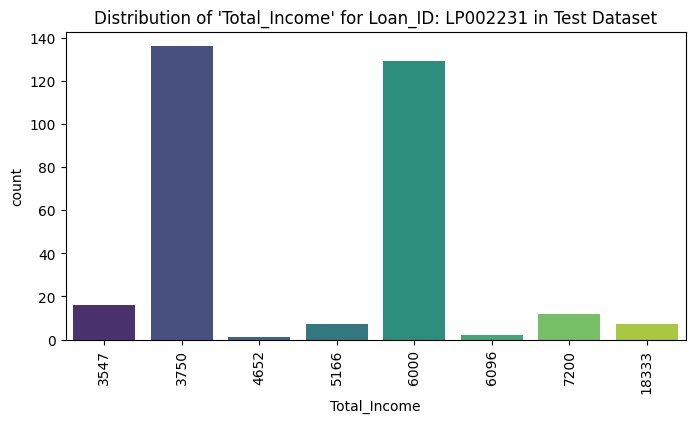


--- Visualization for Loan_ID: LP002585 (Occurrences: 299) in Dataset: Test ---
Identical values across occurrences:

Differing values visualization:


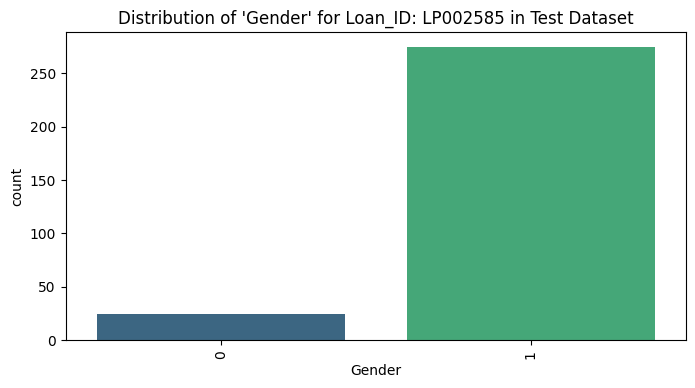

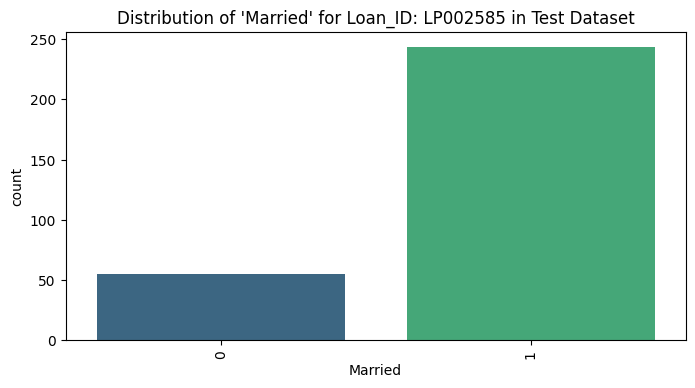

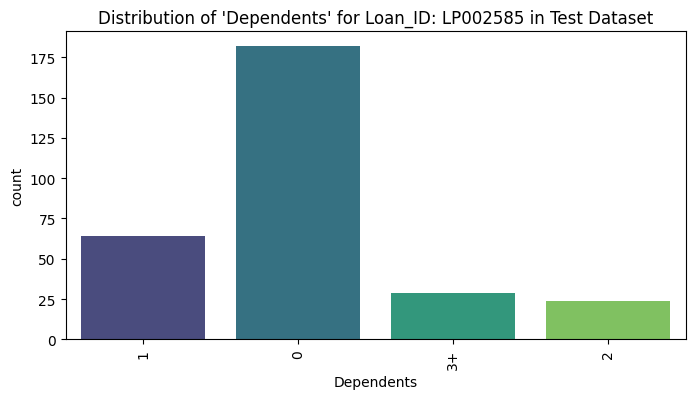

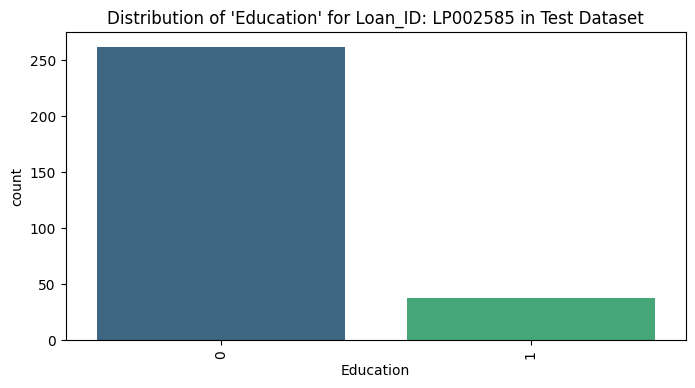

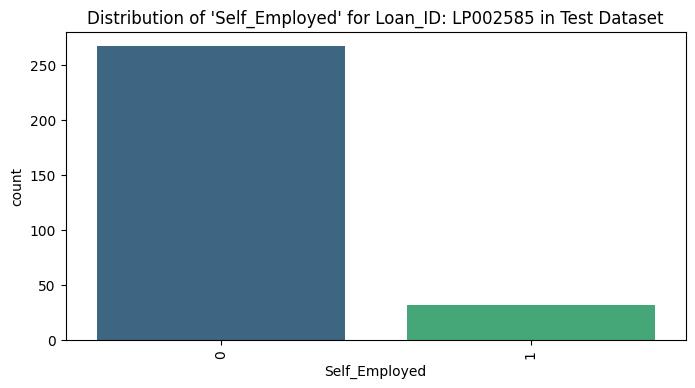

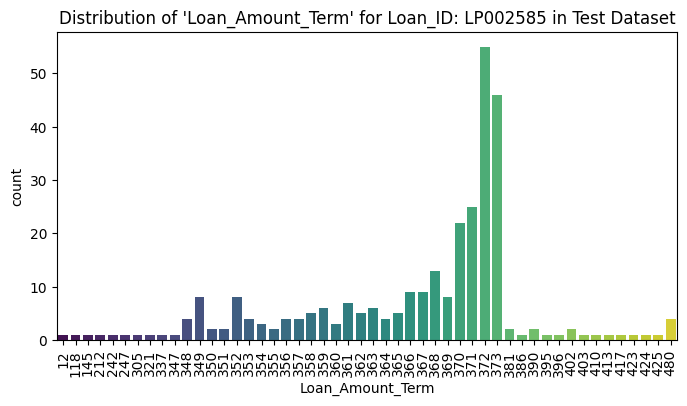

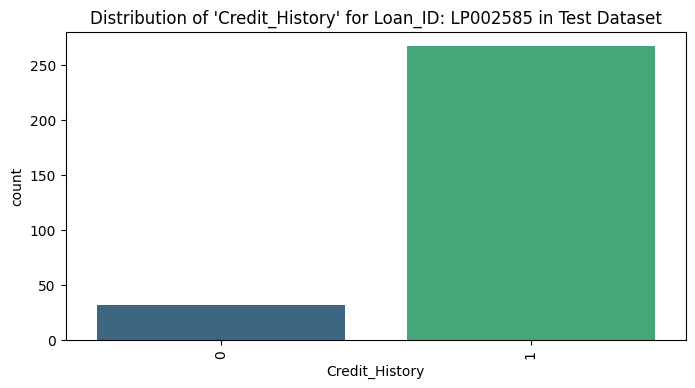

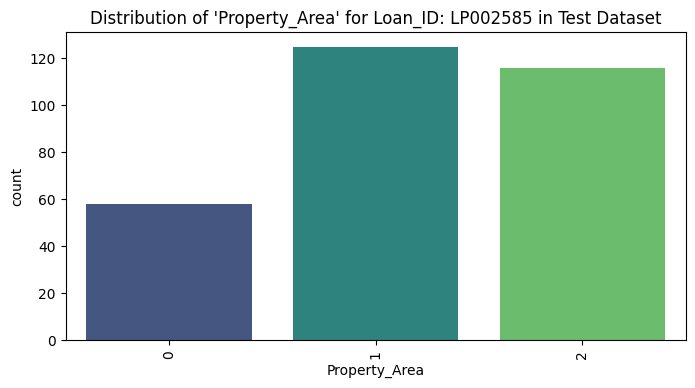

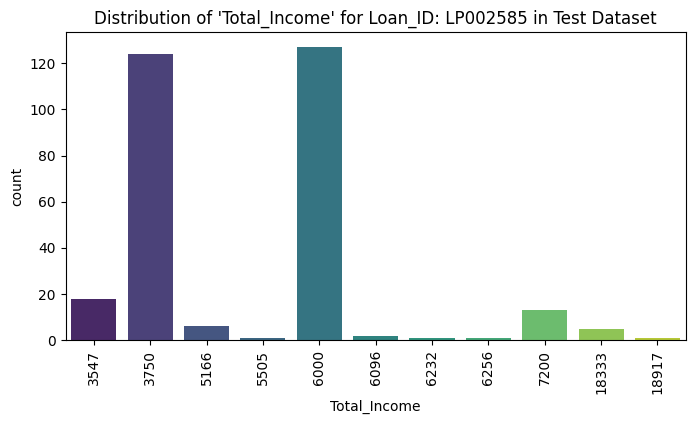


--- Visualization for Loan_ID: LP002175 (Occurrences: 190) in Dataset: Test ---
Identical values across occurrences:

Differing values visualization:


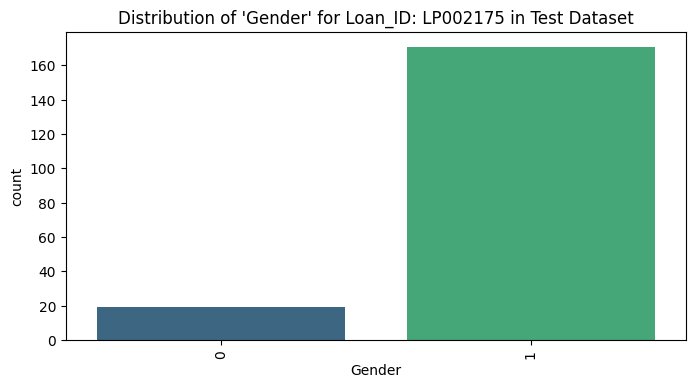

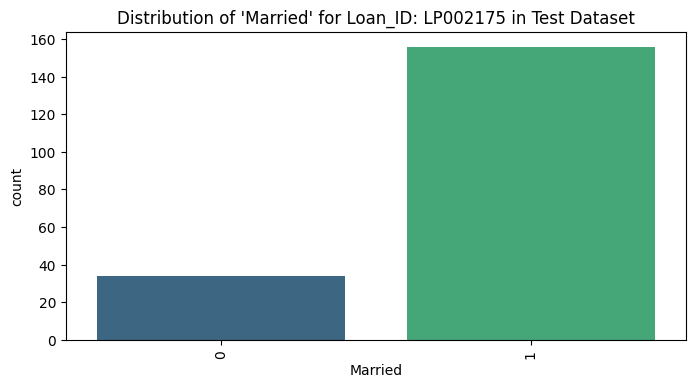

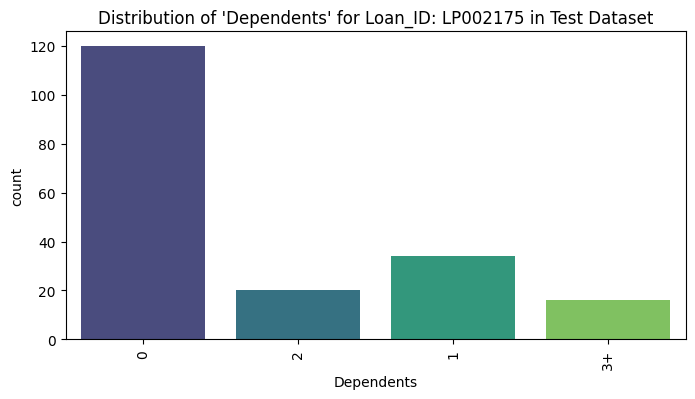

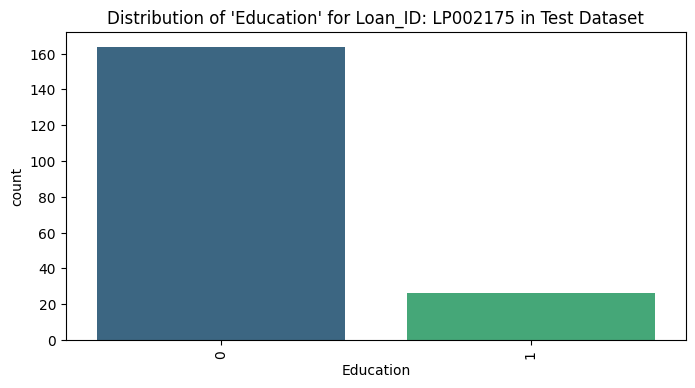

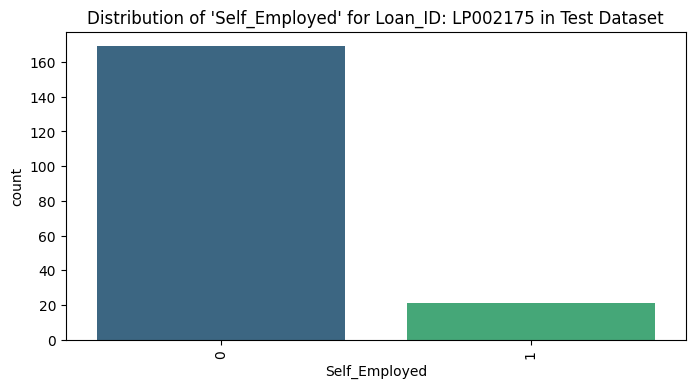

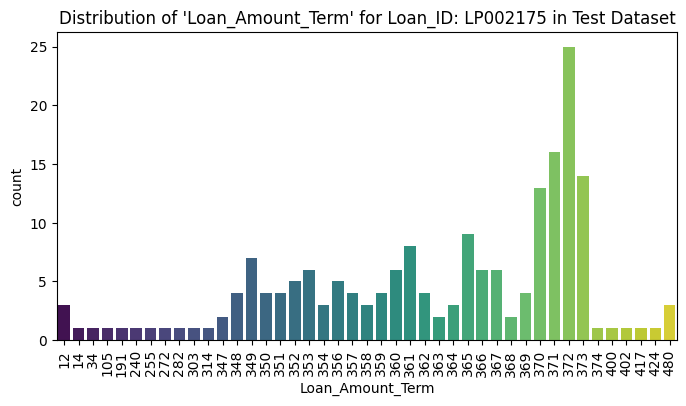

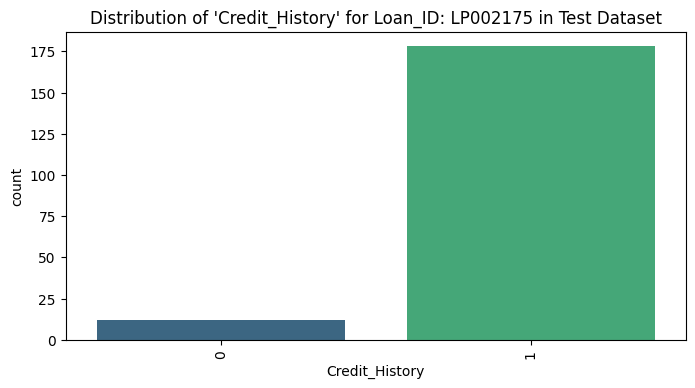

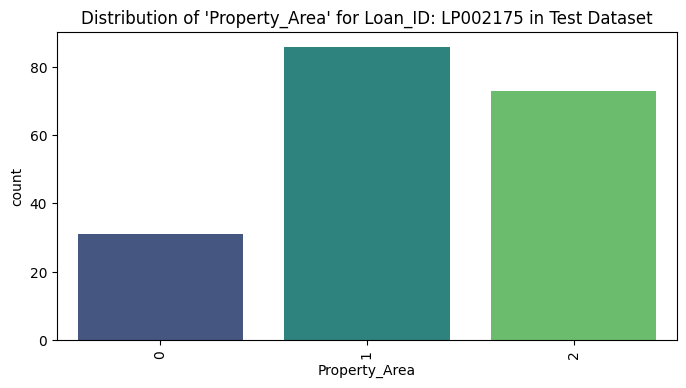

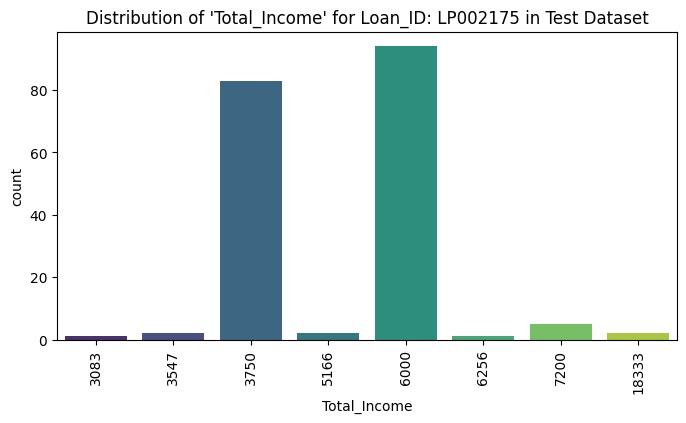


--- Visualization for Loan_ID: LP002224 (Occurrences: 158) in Dataset: Test ---
Identical values across occurrences:

Differing values visualization:


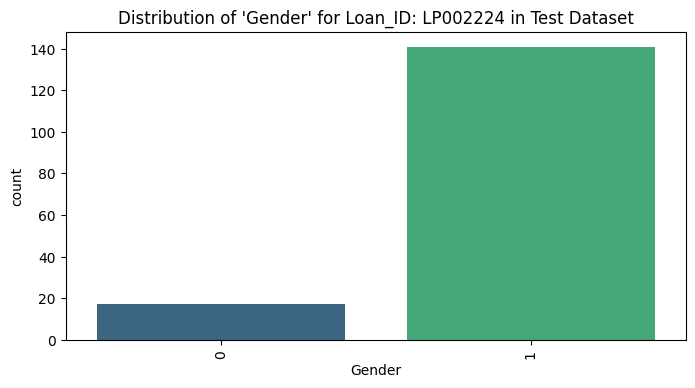

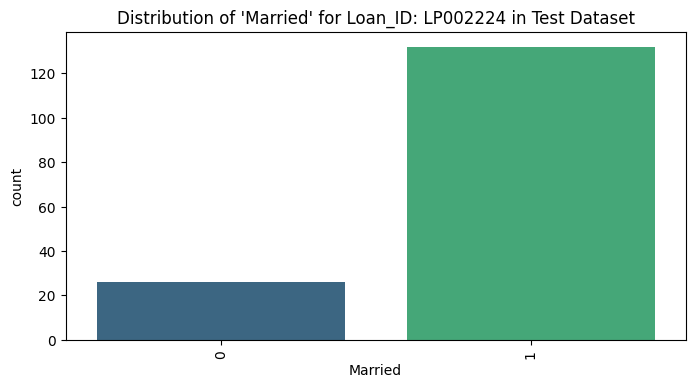

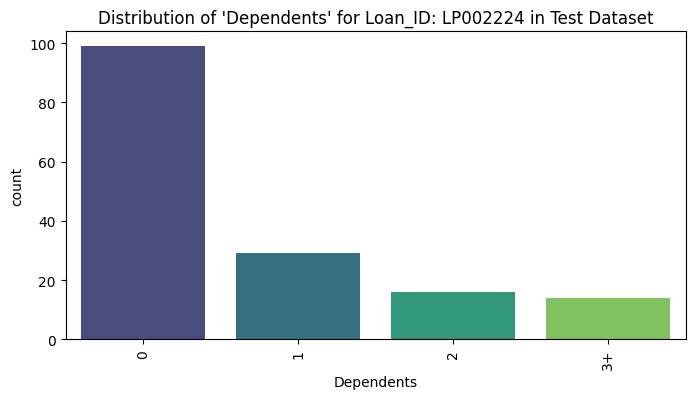

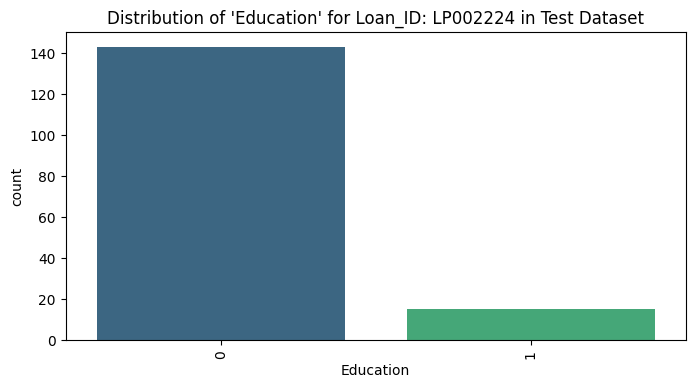

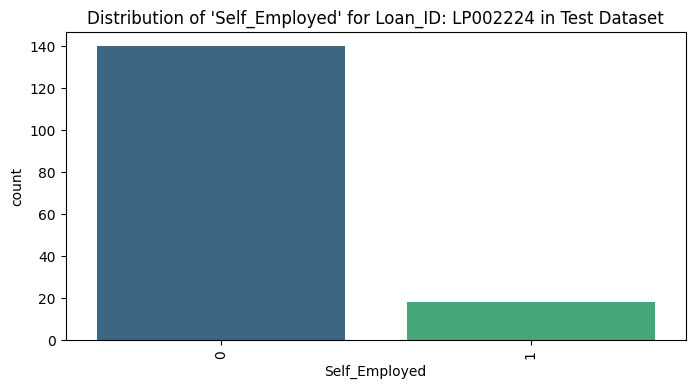

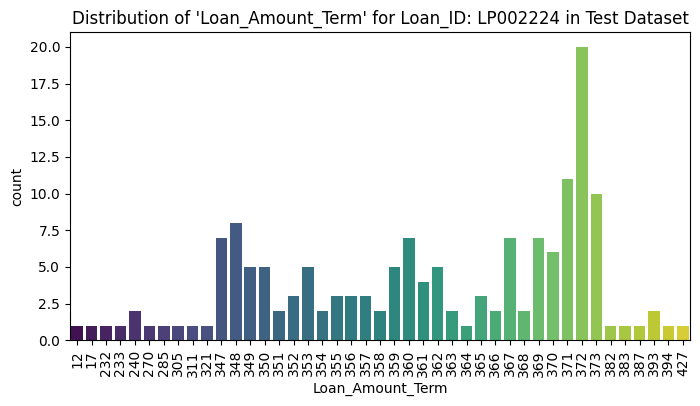

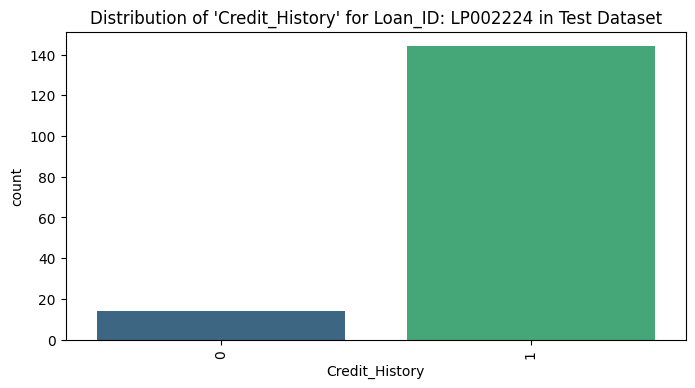

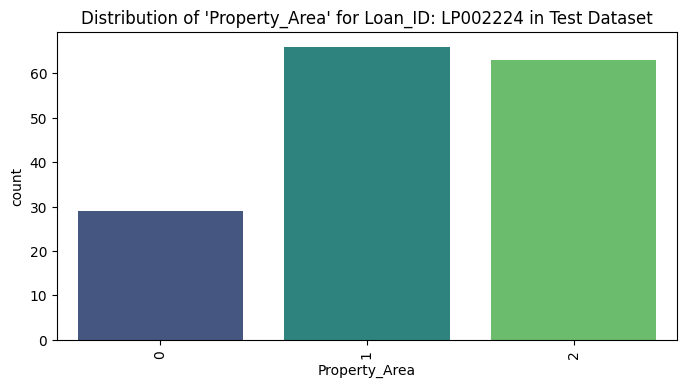

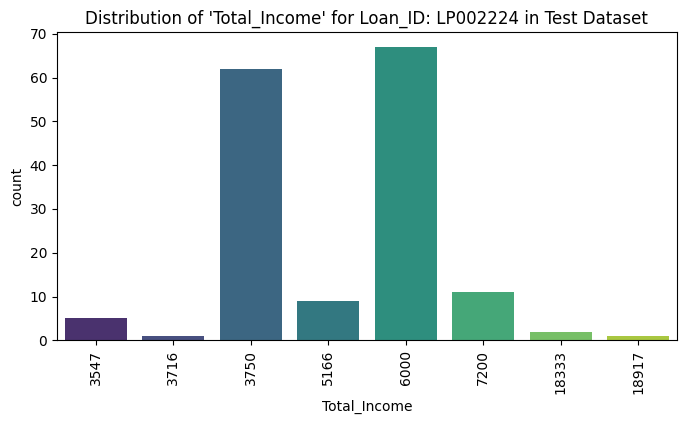


--- Visualization for Loan_ID: LP002560 (Occurrences: 157) in Dataset: Test ---
Identical values across occurrences:

Differing values visualization:


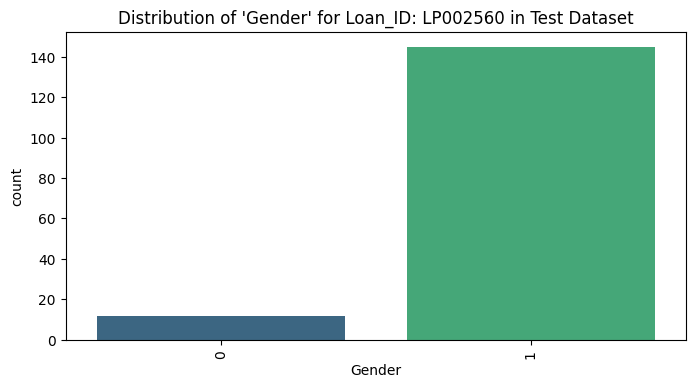

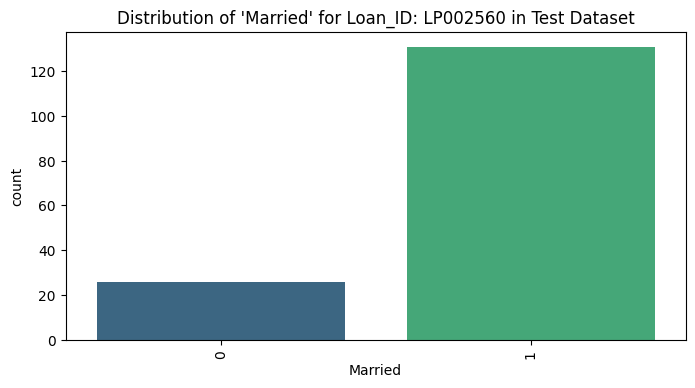

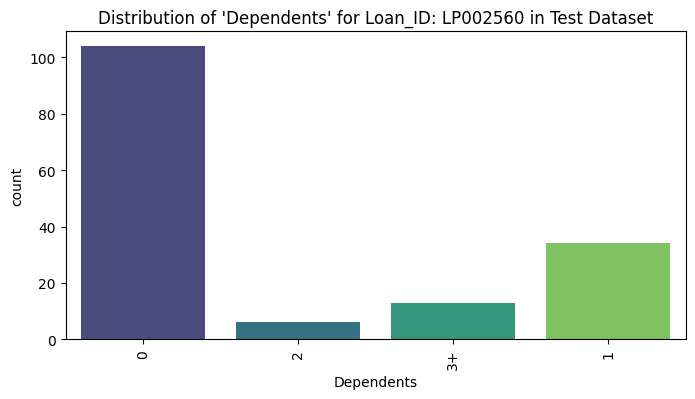

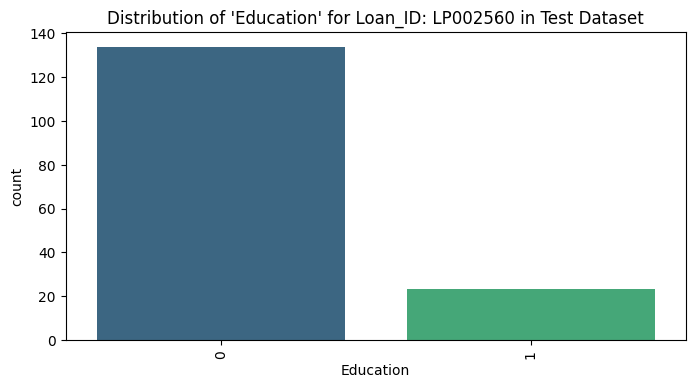

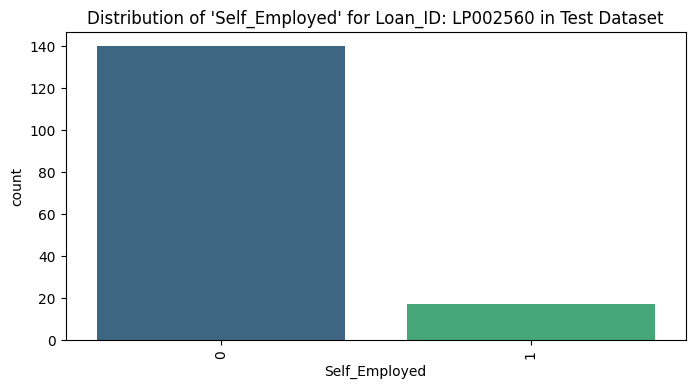

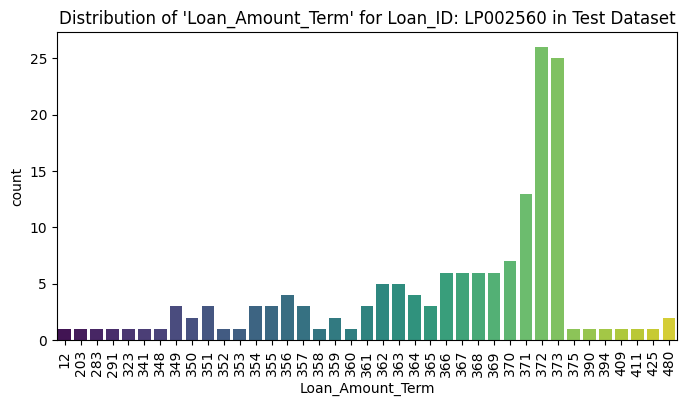

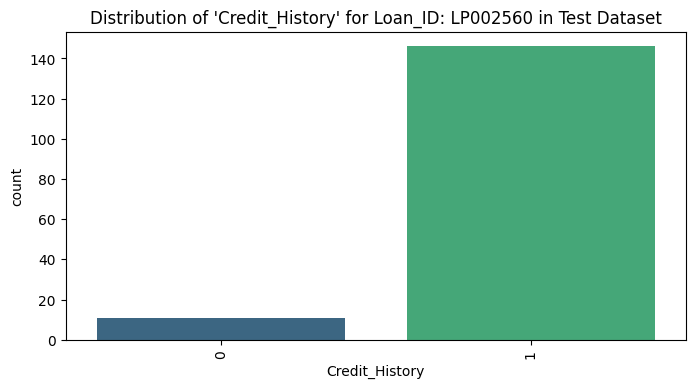

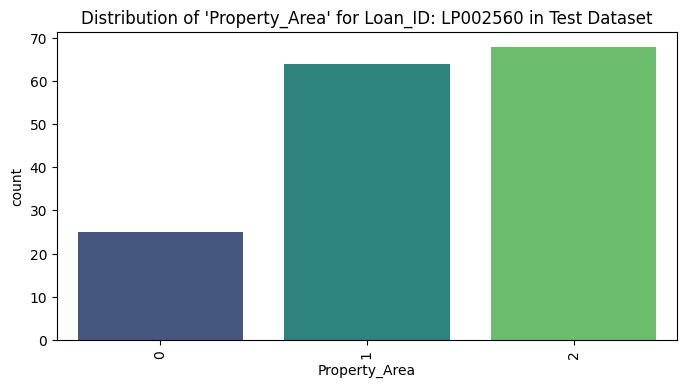

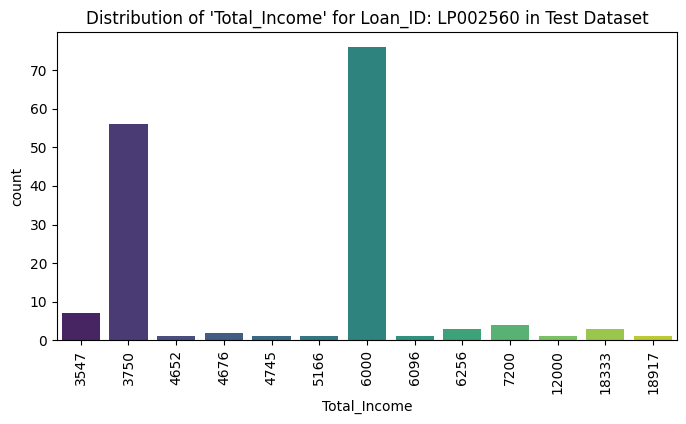


--- Visualization for Loan_ID: LP001385 (Occurrences: 50) in Dataset: Test ---
Identical values across occurrences:
Credit_History: 1

Differing values visualization:


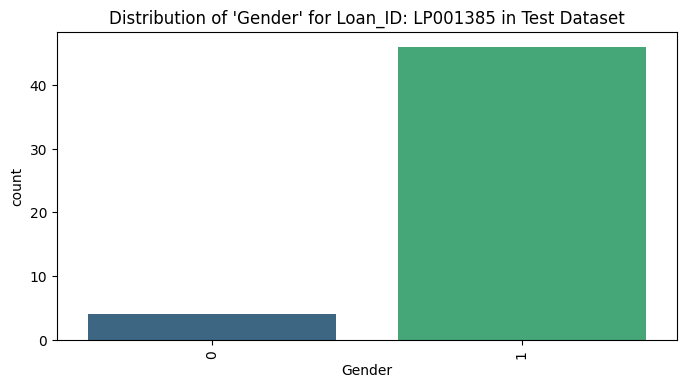

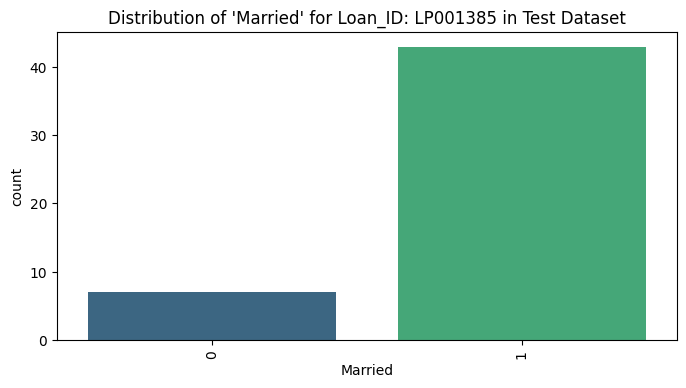

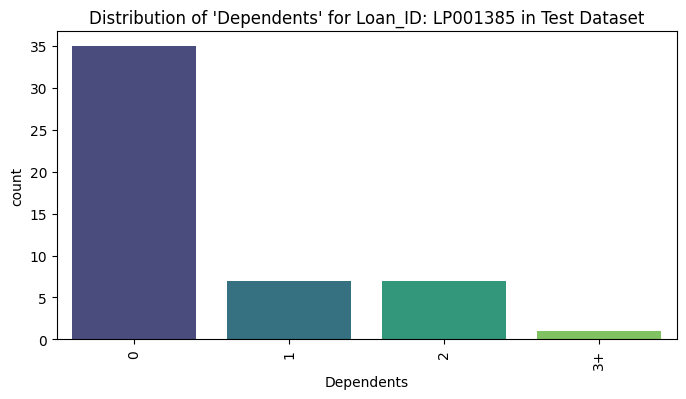

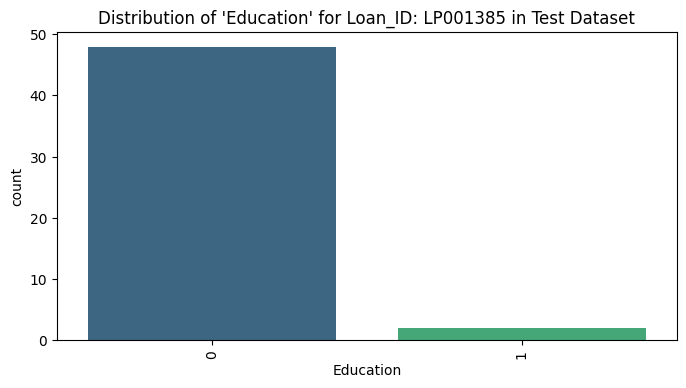

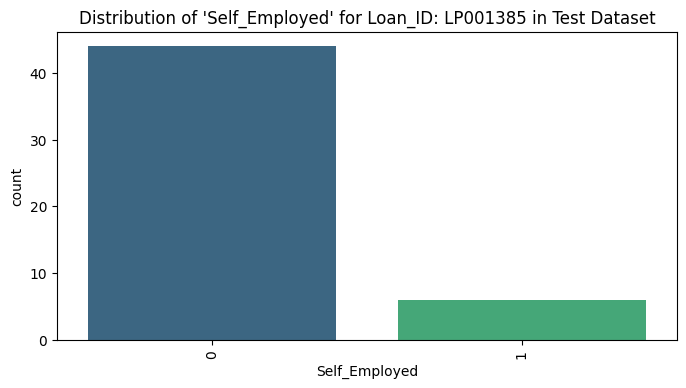

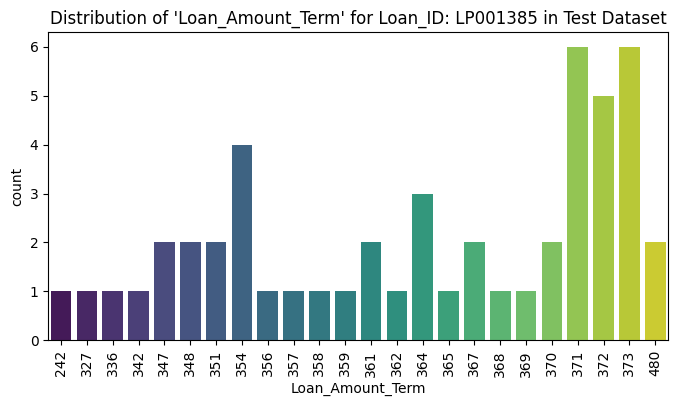

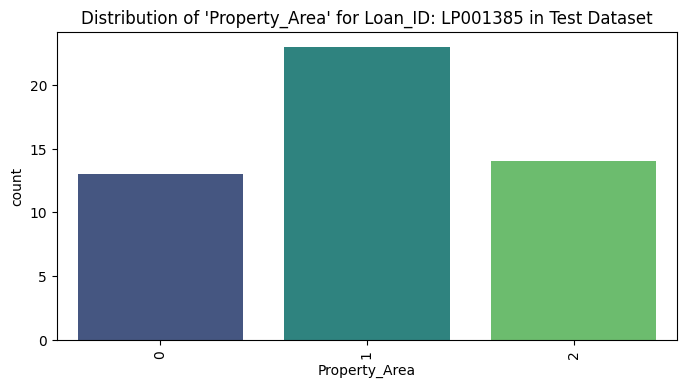

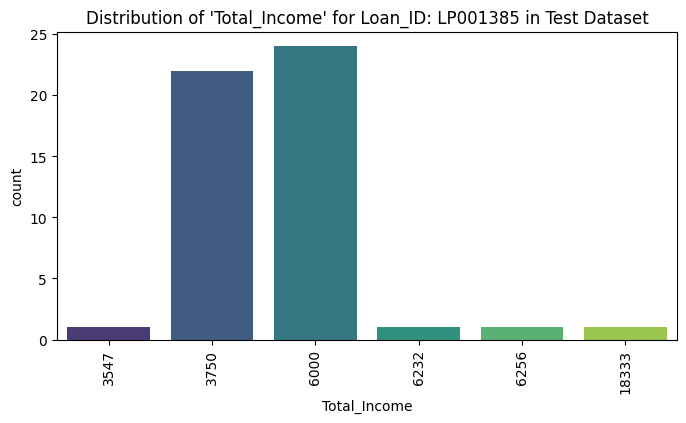


--- Visualization for Loan_ID: LP002582 (Occurrences: 45) in Dataset: Test ---
Identical values across occurrences:

Differing values visualization:


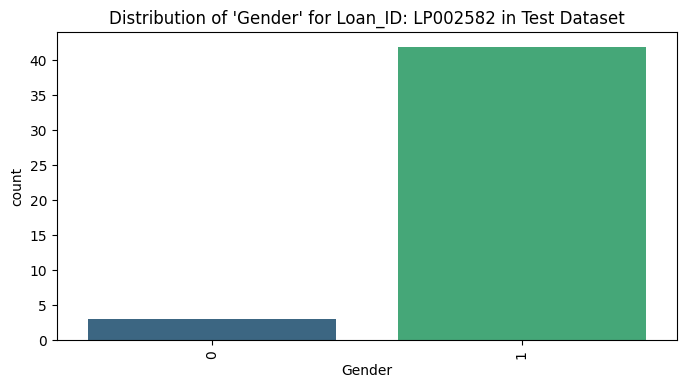

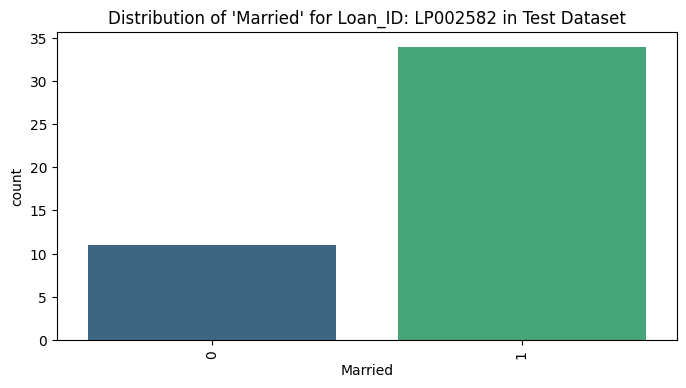

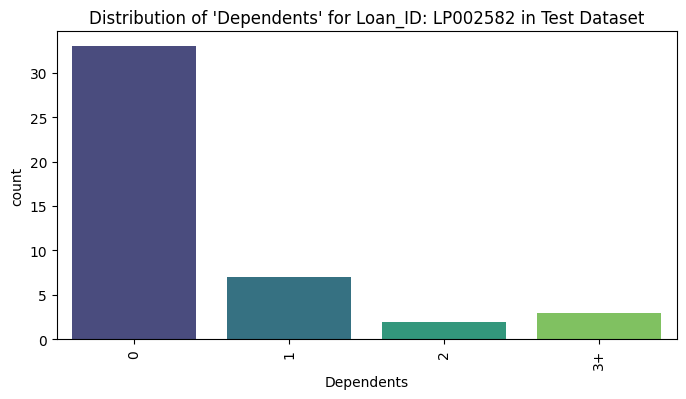

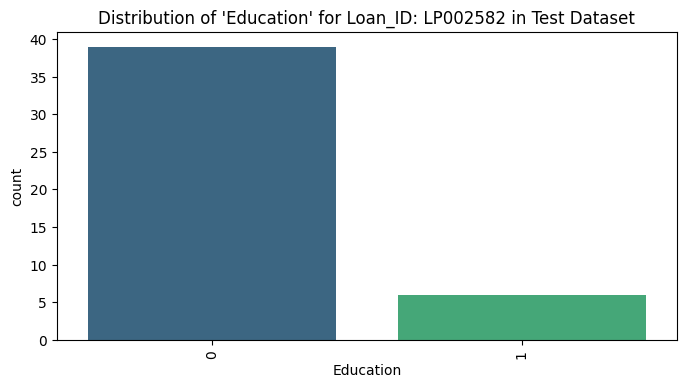

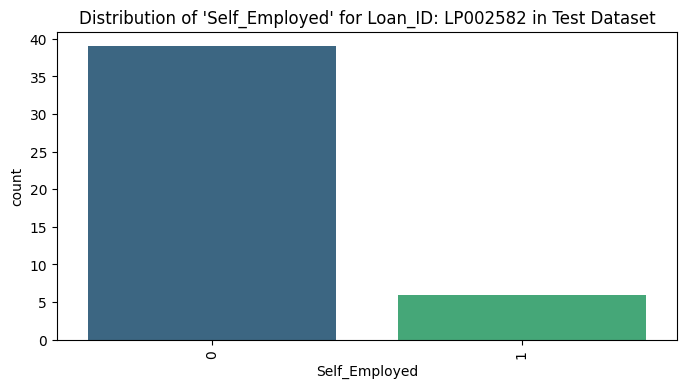

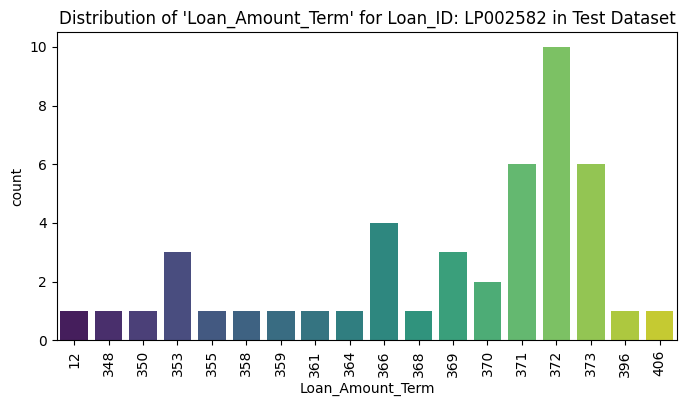

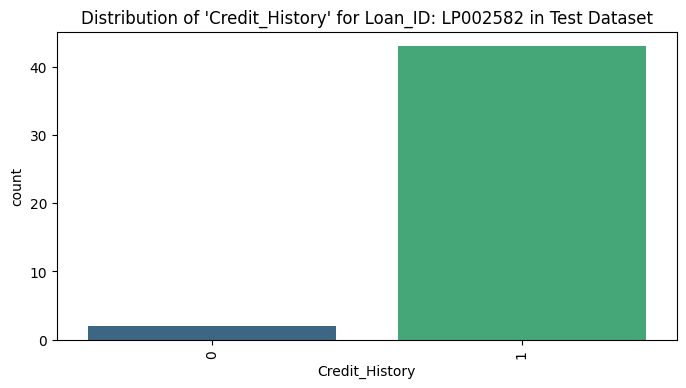

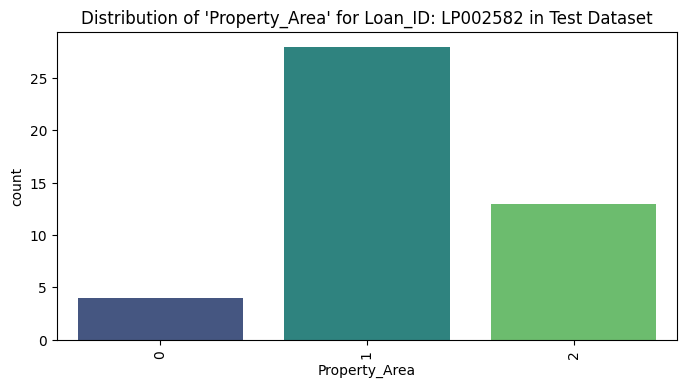

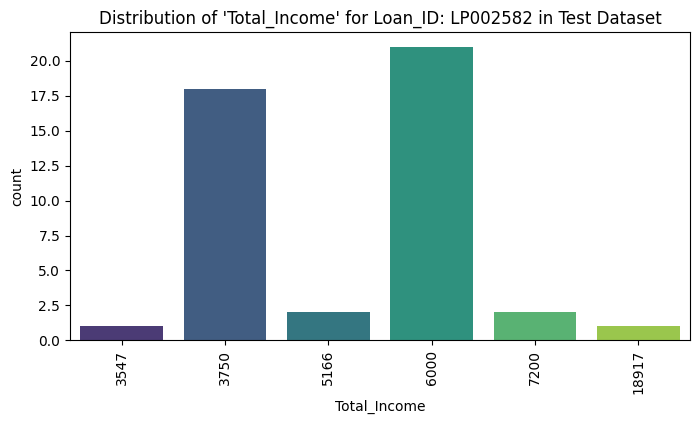


--- Visualization for Loan_ID: LP001790 (Occurrences: 43) in Dataset: Test ---
Identical values across occurrences:
Gender: 1

Differing values visualization:


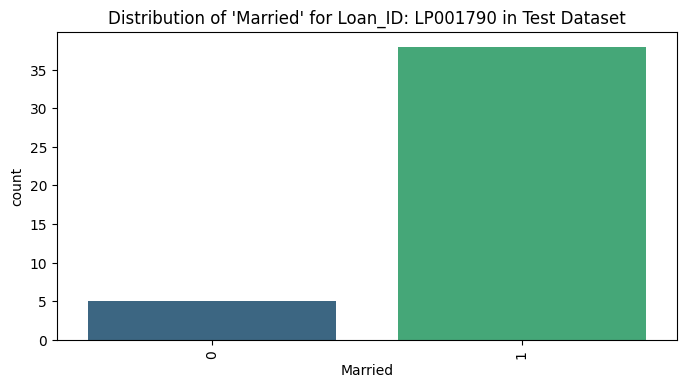

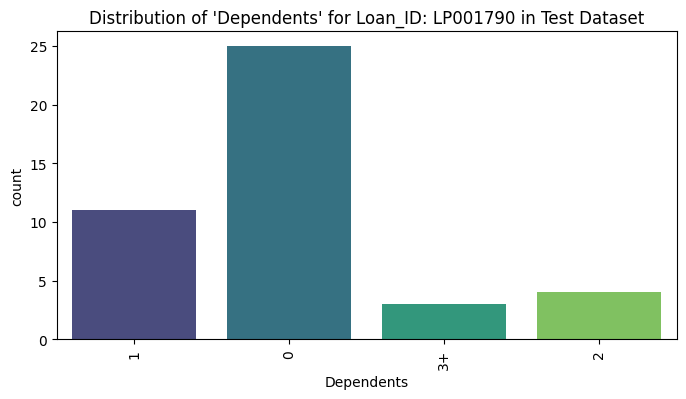

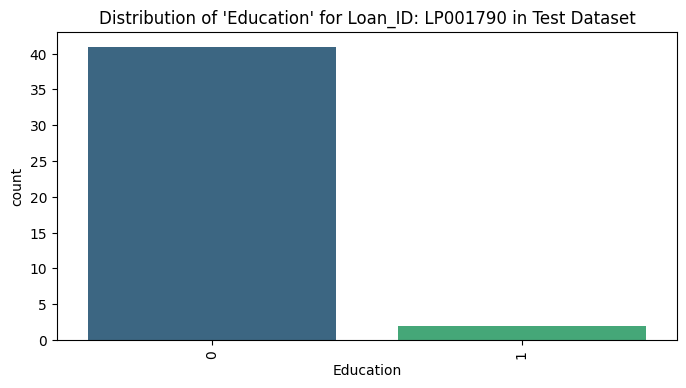

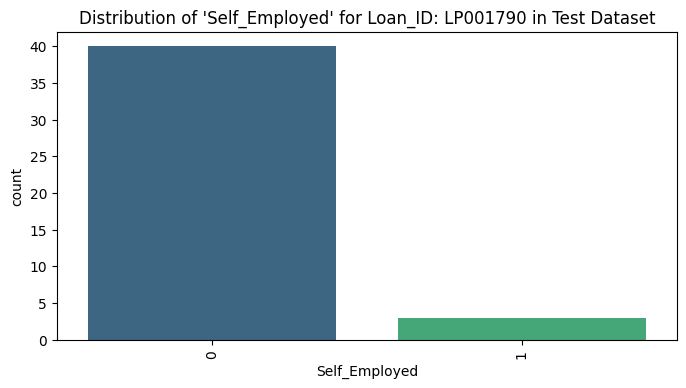

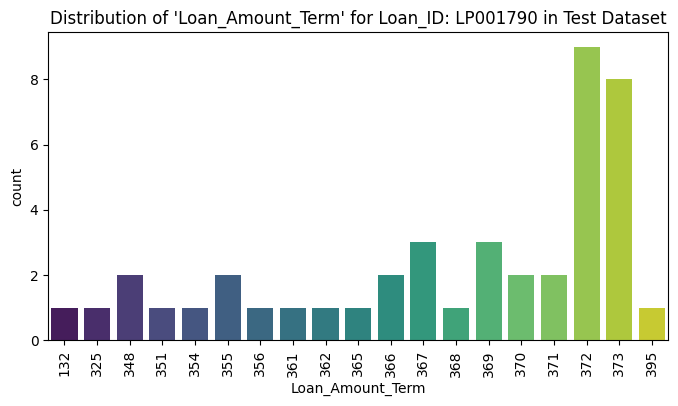

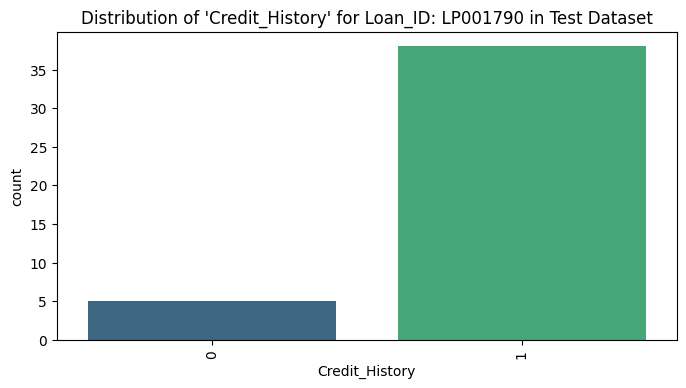

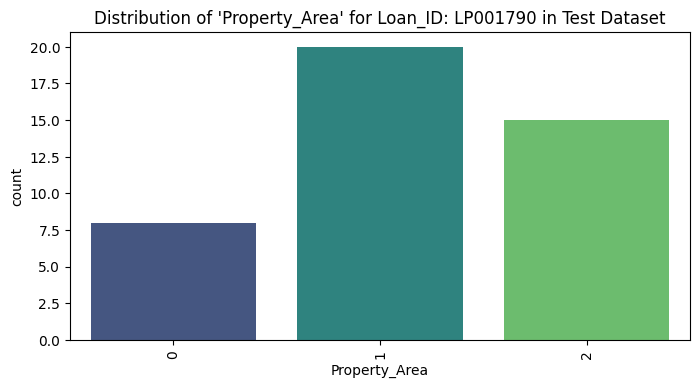

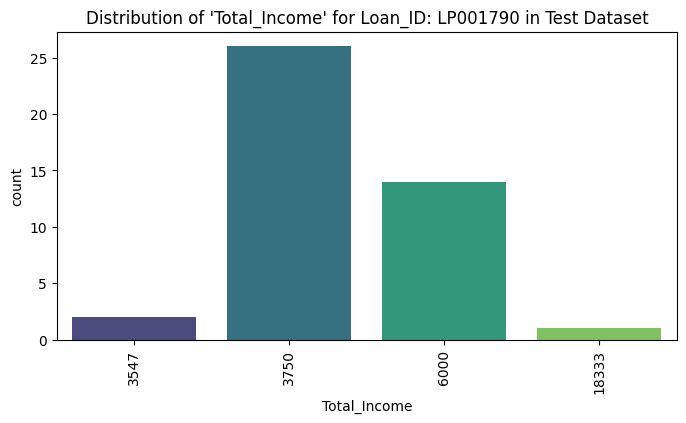


--- Visualization for Loan_ID: LP002181 (Occurrences: 36) in Dataset: Test ---
Identical values across occurrences:

Differing values visualization:


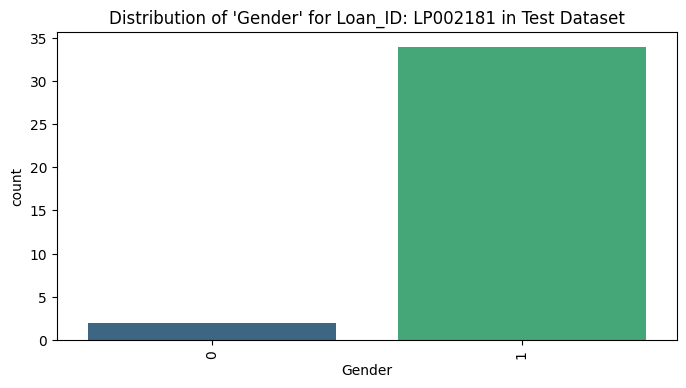

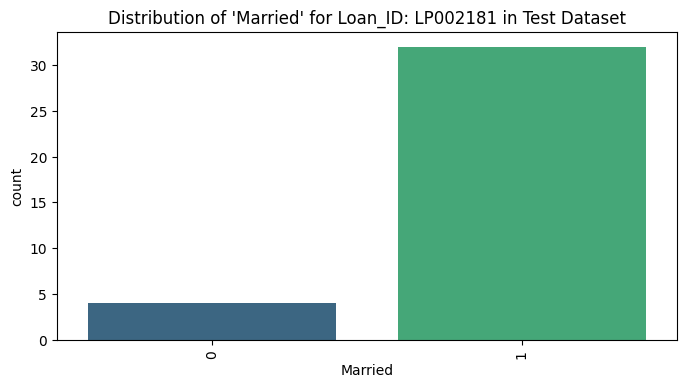

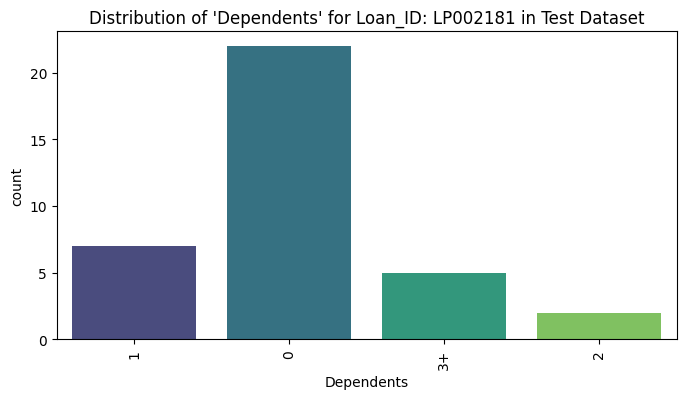

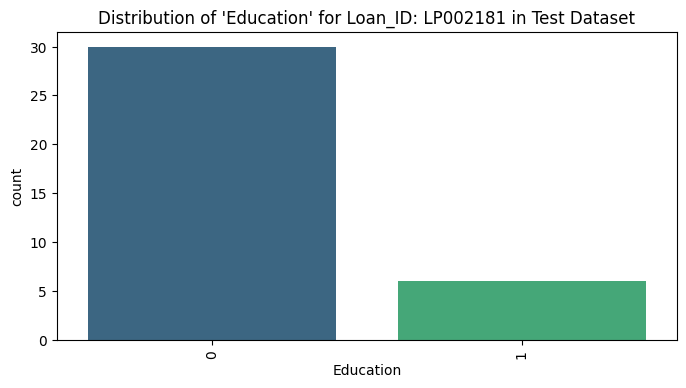

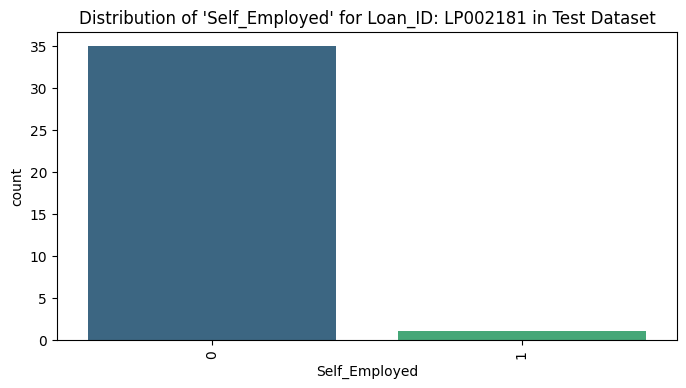

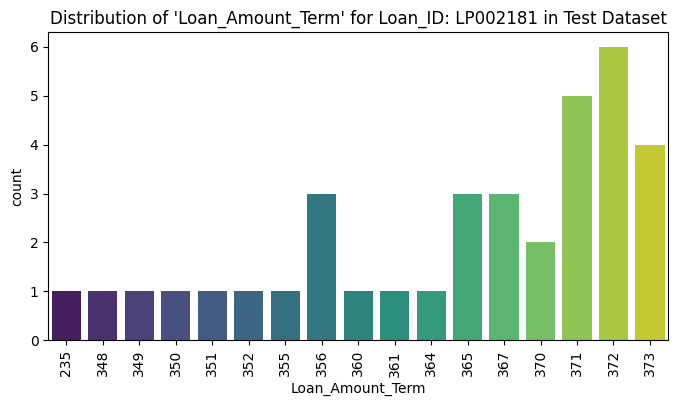

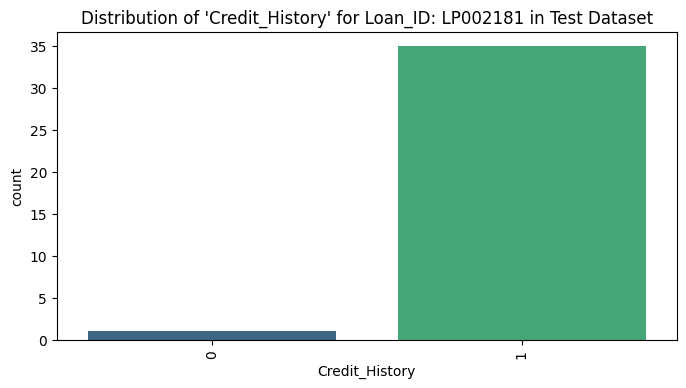

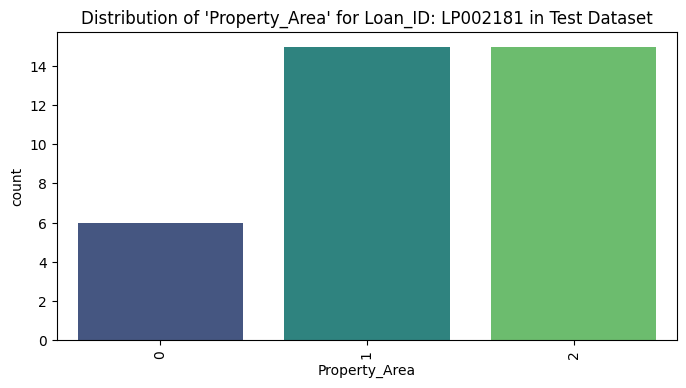

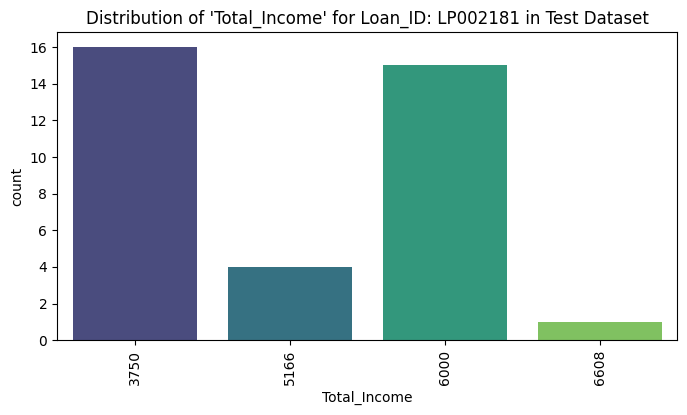

In [7]:
# Function to inspect duplicated Loan_IDs and visualize similarities/differences
def visualize_duplicate_patterns(df, dataset_name, loan_id_column="Loan_ID", top_n=10):
    """
    Inspect duplicated Loan_IDs and visualize similarities/differences,
    limiting to the top_n Loan_IDs with the highest counts, while excluding specific columns.
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        dataset_name (str): Name of the dataset (e.g., "train" or "test").
        loan_id_column (str): The column containing Loan_IDs.
        top_n (int): The number of Loan_IDs to plot with the highest counts.
    Returns:
        None
    """
    # Define columns to exclude
    columns_to_exclude = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "ID", loan_id_column]
    # Count occurrences of each Loan_ID
    loan_id_counts = df[loan_id_column].value_counts()
    # Select the top_n Loan_IDs with the highest counts
    top_loan_ids = loan_id_counts.head(top_n).index
    for loan_id in top_loan_ids:  # Only iterate through the top_n Loan_IDs
        # Filter rows for this particular Loan_ID
        duplicated_rows = df[df[loan_id_column] == loan_id]
        print(f"\n--- Visualization for Loan_ID: {loan_id} (Occurrences: {len(duplicated_rows)}) in Dataset: {dataset_name} ---")

        # Identify columns with identical and differing values, excluding the specified columns
        identical_values = []
        differing_columns = []
        for column in duplicated_rows.columns:
            if column in columns_to_exclude:  # Skip excluded columns
                continue
            if duplicated_rows[column].nunique() == 1:
                identical_values.append((column, duplicated_rows[column].iloc[0]))
            else:
                differing_columns.append(column)

        # Visualization 1: Display identical values in text
        print("Identical values across occurrences:")
        for col, value in identical_values:
            print(f"{col}: {value}")

        # Visualization 2: Bar plot for differing columns
        if differing_columns:
            print("\nDiffering values visualization:")
            for col in differing_columns:
                plt.figure(figsize=(8, 4))
                sns.countplot(data=duplicated_rows, x=col, palette="viridis")
                plt.title(f"Distribution of '{col}' for Loan_ID: {loan_id} in {dataset_name} Dataset")
                plt.xticks(rotation=90)
                plt.show()

# Usage
visualize_duplicate_patterns(train, "Train")
visualize_duplicate_patterns(test, "Test")

#### 2.3.6 Computing Skewness: Training vs. Test Dataset



To further assess the nature of the data and identify any patterns of imbalance, I computed the skewness for both the training and test datasets. Skewness is a key measure that indicates whether the distribution of a particular feature is symmetrical or biased towards one side.



**Key Observations:**



- `ApplicantIncome`: Both the training and test datasets exhibit high positive skewness (4.46 and 4.14, respectively), indicating that the distribution is heavily right-skewed. This suggests that a large portion of applicants have relatively low incomes, while a few applicants have significantly higher incomes, which could be outliers.



- `CoapplicantIncome`: Similar to ApplicantIncome, CoapplicantIncome also shows a high positive skew (3.90 in training and 3.66 in test). This suggests that most applicants and their coapplicants have relatively low coapplicant incomes, with only a few cases where the coapplicant income is disproportionately higher.



- `LoanAmount`: The LoanAmount feature also displays positive skewness (1.49 in both datasets), indicating that while the majority of loans are of smaller amounts, there are a few larger loans, which could again be outliers or loans to applicants with significantly higher financial needs.



- `Loan_Amount_Term`: This column exhibits negative skewness (-4.80 in training and -4.86 in test), suggesting that most loans have shorter terms, with a few loans having unusually long durations. This could be a sign of rare long-term loans in the dataset.



- `Total_Income`: Total_Income, derived from ApplicantIncome and CoapplicantIncome, shows strong positive skewness in both datasets (3.97 in training and 4.05 in test), reinforcing the notion that the majority of applicants have lower total incomes, while a few cases have significantly higher total incomes.





**Bigger Picture:**



The observed skewness across several features, particularly ApplicantIncome, CoapplicantIncome, and Total_Income, supports earlier findings of data imbalance. The right-skewed distributions for these income-related variables suggest that most individuals are in lower income brackets, with only a small number of individuals earning much higher incomes. This skewness is critical to address, as machine learning models can be biased towards these outliers if not properly handled.



Additionally, the negative skew in Loan_Amount_Term points to a potential issue with how long-term loans are represented, which could be important in the loan approval process and might need further exploration or transformation.



The patterns of skewness and imbalance observed in these variables were first identified through a focused investigation of the most frequently appearing loan ID in the train dataset, LP002585.

In [8]:
# defining numerical columns 
numeric_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Total_Income"]

# function to compute skewness 
def compute_skewness(dataset, loan_id_col, numeric_cols):
    """
    Computes skewness for numeric columns in the dataset.
    Parameters:
        dataset (pd.DataFrame): The dataset containing the data.
        loan_id_col (str): The column representing loan IDs.
        numeric_cols (list): A list of numeric columns to compute skewness for.

    Returns:
        pd.DataFrame: A DataFrame with the skewness for each numeric column.
    """
    skewness_results = []
    for col in numeric_cols:
        if col in dataset.columns:
            # Compute skewness for the column
            col_skew = skew(dataset[col].dropna())  # Drop NaN values for calculation
            skewness_results.append({"Column": col, "Skewness": col_skew})
            
    # Convert results to DataFrame
    skewness_df = pd.DataFrame(skewness_results)
    return skewness_df

# Compute skewness for train dataset
train_skewness = compute_skewness(train, loan_id_col="Loan_ID", numeric_cols = numeric_cols)
print("Skewness in Training Dataset:\n", train_skewness)

# Compute skewness for test dataset
test_skewness = compute_skewness(test, loan_id_col="Loan_ID", numeric_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Total_Income"])
print("Skewness in Test Dataset:\n", test_skewness)

Skewness in Training Dataset:
               Column  Skewness
0    ApplicantIncome  4.456444
1  CoapplicantIncome  3.901070
2         LoanAmount  1.486343
3   Loan_Amount_Term -4.803557
4       Total_Income  3.971156
Skewness in Test Dataset:
               Column  Skewness
0    ApplicantIncome  4.141463
1  CoapplicantIncome  3.655790
2         LoanAmount  1.485648
3   Loan_Amount_Term -4.863494
4       Total_Income  4.049716


 ### 2.4 Addressing Income Discrepancies



#### 2.4.1 Identifying Discrepancies in the TotalIncome Column



During my dataset exploration, I noticed inconsistencies in the `Total_Income` column when comparing its maximum and minimum values with the combined values of the `ApplicantIncome` and `CoapplicantIncome` columns. Specifically:



1. The maximum value of `Total_Income` was lower than the sum of the maximum values of `ApplicantIncome` and `CoapplicantIncome`.



2. This contradiction indicated potential discrepancies in the `TotalIncome` column.





To confirm this, I developed a function called check_discrepancy with the following functionality:



- It checks whether the `Total_Income` column equals the sum of `ApplicantIncome` and `CoapplicantIncome` for each row.



- It prints:



1. The total number of rows in the dataset.





2. The number of rows where the condition does not hold true.









**Key Findings:**



The function revealed that all rows in the dataset exhibited discrepancies, meaning the `Total_Income` column was consistently inaccurate.

In [9]:
def check_discrepancies(dataset, total_col, app_income_col, coapp_income_col, correct=False):
    condition = dataset[total_col] == dataset[app_income_col] + dataset[coapp_income_col]
    discrepancies = dataset[~condition]

    print(f"Total Rows: {len(dataset)}")
    print(f"Rows with discrepancies: {len(discrepancies)}")

    if correct:
        # Flag discrepancies by adding a new column
        dataset['DiscrepancyFlag'] = ~condition
        return dataset
    return discrepancies

In [10]:
train_dataset = check_discrepancies(train, 'Total_Income', 'ApplicantIncome', 'CoapplicantIncome', correct=True)

test_dataset = check_discrepancies(test, 'Total_Income', 'ApplicantIncome', 'CoapplicantIncome', correct=True)

Total Rows: 5898
Rows with discrepancies: 5898
Total Rows: 2528
Rows with discrepancies: 2528


#### 2.4.2 Correcting the TotalIncome Column



Given the pervasive discrepancies, I decided to drop the existing `Total_Income` column and replace it with a new column calculated directly as the sum of `ApplicantIncome` and `CoapplicantIncome`.



Steps Taken:



1. Dropped the existing `Total_Income` column.





2. Created a new column, `Total_Income`, defined as:

`Total_Income` = `ApplicantIncome` + `CoapplicantIncome`







This adjustment ensures consistency in the dataset and eliminates inaccuracies that could negatively impact further analyses and modeling.

In [11]:
# Drop the unreliable Total_Income column

train.drop(columns=['Total_Income'], axis=1, inplace=True)

test.drop(columns=['Total_Income'], axis=1, inplace=True)

In [12]:
# Create a new TotalIncome column
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
test['Total_Income'] = test['ApplicantIncome'] + test['CoapplicantIncome']

# Verify the new column
print(train[['ApplicantIncome', 'CoapplicantIncome', 'Total_Income']].head())
print(test[['ApplicantIncome', 'CoapplicantIncome', 'Total_Income']].head())

# verifying that the change is accurate
print(train['Total_Income'].describe())

   ApplicantIncome  CoapplicantIncome  Total_Income
0             8328           0.000000   8328.000000
1              150        3857.458782   4007.458782
2             4989         314.472511   5303.472511
3              150           0.000000    150.000000
4             8059           0.000000   8059.000000
   ApplicantIncome  CoapplicantIncome  Total_Income
0            15890         871.075952  16761.075952
1             6582         896.718887   7478.718887
2             7869         572.900354   8441.900354
3              150           0.000000    150.000000
4             8362           0.000000   8362.000000
count     5898.000000
mean      9027.981506
std       9479.564621
min        150.000000
25%       3730.000000
50%       7796.748153
75%      11028.641894
max      86414.875663
Name: Total_Income, dtype: float64


#### 2.4.3 Skewness Calculation for Corrected Total Income



**Why Earlier Skewness Calculations Were Invalid**



The earlier skewness calculations for Total Income were invalid because discrepancies in the column meant it didn’t accurately represent the sum of Applicant Income and Co-Applicant Income. As a result, the initial skewness values do not fully reflect the true data distribution.



**Highlighting the Difference: Original vs. Corrected Skewness**



| Column Name        | Skewness (Original) | Skewness (Corrected) |

|--------------------|---------------------|-----------------------|

| Total Income (Train)| 3.971156           | 4.064048             |

| Total Income (Test) | 4.049716           | 3.732907             |



**Observations**



While the differences between the original and corrected skewness values are small, they confirm that despite the correction, the Total Income distribution remains positively skewed. This indicates that most income values are concentrated on the lower end, with a few higher values stretching the tail.

In [13]:
# Calculate skewness for Total_Income in the train and test datasets
train_skewness = skew(train['Total_Income'], nan_policy='omit')
test_skewness = skew(test['Total_Income'], nan_policy='omit')

print(f"Corrected skewness of Total_Income in train dataset: {train_skewness}")
print(f"Corrected skewness of Total_Income in test dataset: {test_skewness}")

Corrected skewness of Total_Income in train dataset: 4.064048723834089
Corrected skewness of Total_Income in test dataset: 3.732907113197561


### **2.5 Outlier Analysis and Handling**



In this section, I explored the outliers in my dataset using the IQR method and developed a more nuanced understanding of how outliers impact each feature. Based on these observations, I then decided on the most appropriate handling method for each feature.



#### **1. Applicant Income**



**Initial Observation:**

- In the **Training Dataset**, outliers in **ApplicantIncome** make up about 5.12% of the data. The majority of values lie between 15,000 and 33,000, but a few outliers go as high as 80,000.

- **Test Dataset** shows a similar pattern.



**In-depth Insights:**

- A significant majority of **ApplicantIncome** values fall between 0 and 10,000, with outliers starting from 15,000 and extending up to 80,000, becoming more sparse after 35,000.

- This pattern suggests that there are a few extreme values that may distort the model's learning process.



#### **2. Co-applicant Income**



**Initial Observation:**

- Outliers in **CoapplicantIncome** represent about 6.71% of the data. Most values fall between 4,000 and 8,000, with some extreme values reaching up to 20,000.

- **Test Dataset** displays a similar pattern.



**In-depth Insights:**

- The **CoapplicantIncome** feature shows a median close to zero, which indicates a substantial number of zero values (no co-applicant).

- Outliers in this feature begin at 4,000 and become sparse after 8,000.  

- Initially, I planned to cap the outliers, but this approach did not yield optimal results during testing. Instead, I decided to apply a log transformation, as it effectively reduced the skewness and normalized the data.



#### **3. Loan Amount**



**Initial Observation:**

- Outliers in **LoanAmount** make up just 1.32% of the data. The outliers are visible at both extremes, with values reaching up to 700, while the majority lie between 0 and 118.



**In-depth Insights:**

- The majority of **LoanAmount** values lie between 0 and 118, but outliers extend from 400 to 700, with the extreme values becoming sparse after 510.





#### **4. Loan Amount Term**



**Initial Observation:**

- **Loan_Amount_Term** has 9.02% outliers, with a wide range of values between 0 and 500.



**In-depth Insights:**

- The box plot for **Loan_Amount_Term** lies mostly between 300 and 400. However, significant outliers are both above 400 (up to 500) and below 300 (even down to 0).

- After analyzing the distribution and testing out different outlier handling strategies, I decided to convert **Loan_Amount_Term** into a categorical feature.



**Reasoning for Categorization:**

- Categorizing this feature reduces the impact of outliers without distorting the data.

- Loan term lengths naturally fall into discrete buckets, such as "short-term," "medium-term," and "long-term," which makes this approach more intuitive and interpretable for the model.



#### **5. Total Income**



**Initial Observation:**

- Outliers in **Total_Income** make up 5.54% of the data. Most values lie between 17,000 and 35,000, with a few extreme values standing at 43,000, 58,000, and 80,000.



**In-depth Insights:**

- **Total_Income** follows a similar pattern to **ApplicantIncome** and **CoapplicantIncome**, with expected skewness due to high outliers.



### **Summary of Outlier Handling Strategy:**



| Feature             | Outlier Percentage | Handling Method          | Reasoning                                       |

|---------------------|--------------------|--------------------------|-------------------------------------------------|

| **ApplicantIncome**  | 5.12%              | Log transformation       | Reduces skewness caused by extreme values       |

| **CoapplicantIncome**| 6.71%              | Log transformation       | Normalized skewed data effectively              |

| **LoanAmount**       | 1.32%              | RobustScaler             | Reduces influence of extreme values in scaling  |

| **Loan_Amount_Term** | 9.02%              | Convert to categorical   | Better represents discrete loan term lengths    |

| **TotalIncome**      | 5.54%              | Log transformation       | Reduces skewness from high outliers            |



This approach ensures that each feature is preprocessed in a way that minimizes distortion while retaining the integrity of the data.

Analyzing outliers in the training dataset:


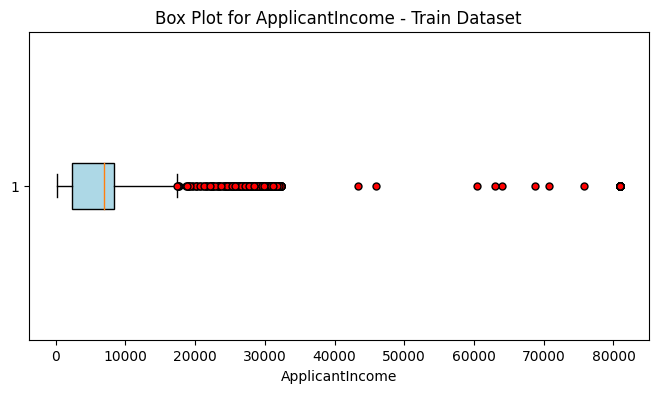

Column: ApplicantIncome - Outliers: 5.12%


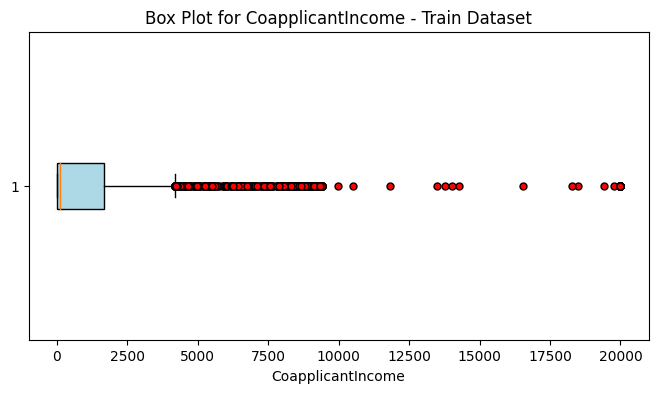

Column: CoapplicantIncome - Outliers: 6.71%


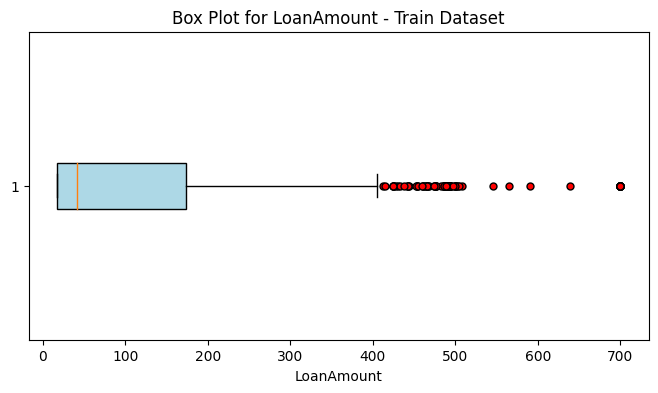

Column: LoanAmount - Outliers: 1.32%


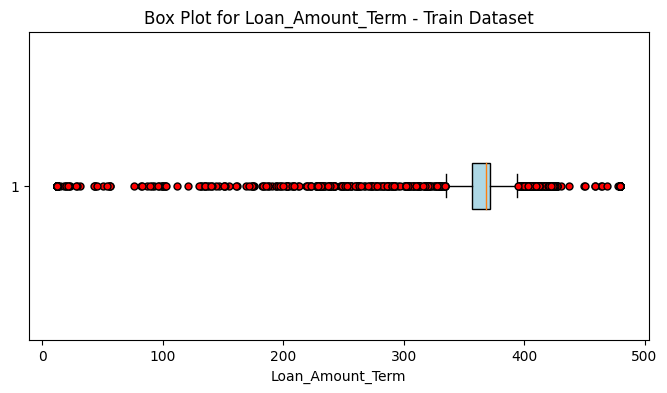

Column: Loan_Amount_Term - Outliers: 9.02%


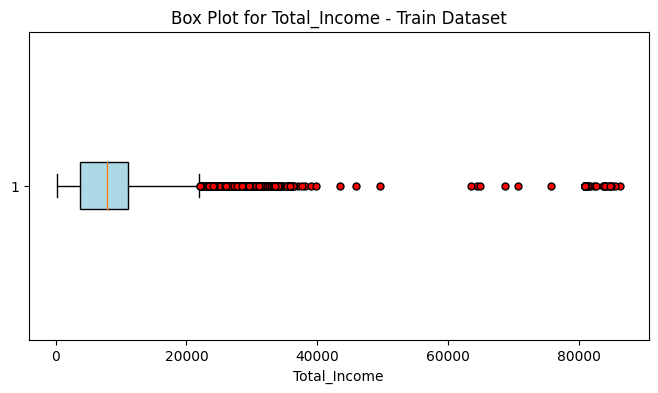

Column: Total_Income - Outliers: 5.54%

Analyzing outliers in the test dataset:


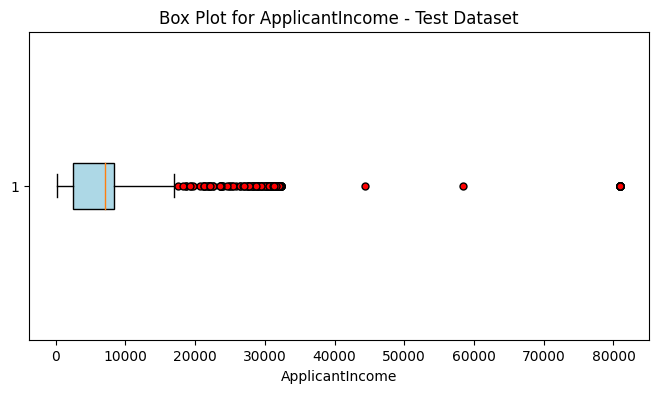

Column: ApplicantIncome - Outliers: 5.58%


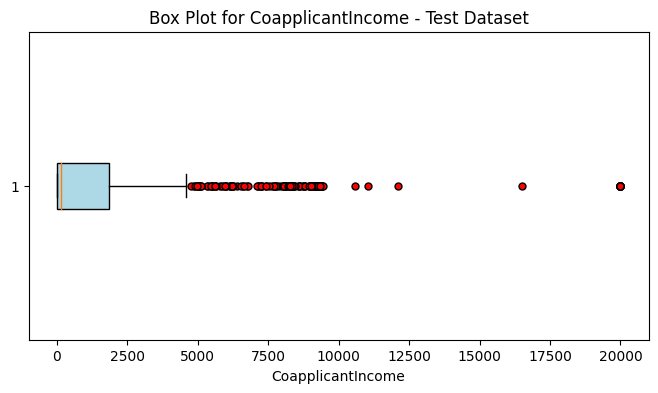

Column: CoapplicantIncome - Outliers: 4.67%


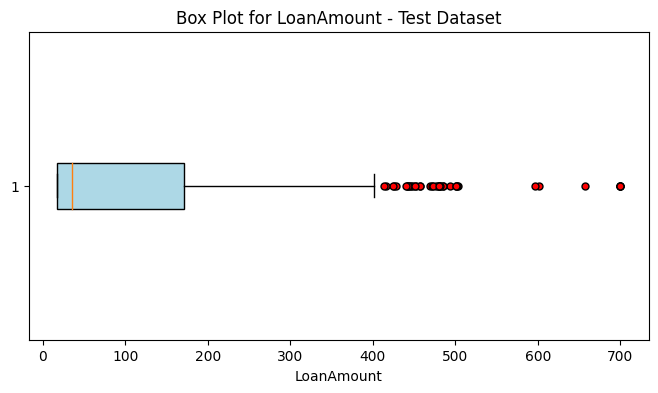

Column: LoanAmount - Outliers: 1.54%


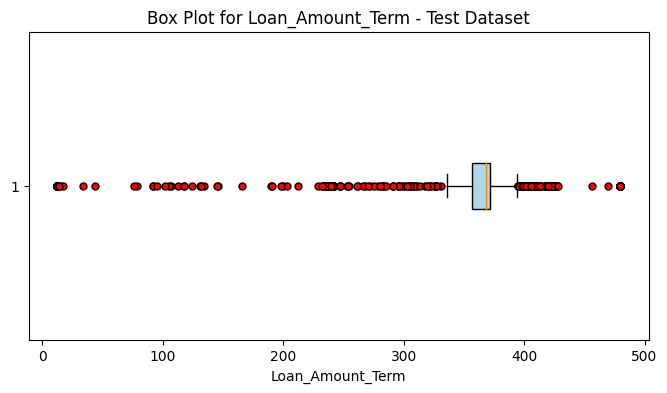

Column: Loan_Amount_Term - Outliers: 9.26%


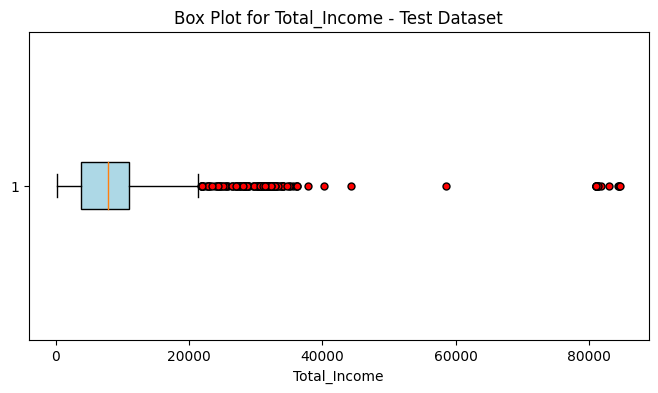

Column: Total_Income - Outliers: 5.89%

Outlier percentages for train dataset:
{'ApplicantIncome': 5.120379789759241, 'CoapplicantIncome': 6.714140386571719, 'LoanAmount': 1.3224821973550356, 'Loan_Amount_Term': 9.020006781959987, 'Total_Income': 5.544252288911496}

Outlier percentages for test dataset:
{'ApplicantIncome': 5.5775316455696204, 'CoapplicantIncome': 4.667721518987341, 'LoanAmount': 1.5427215189873418, 'Loan_Amount_Term': 9.25632911392405, 'Total_Income': 5.893987341772152}


In [14]:


def analyze_outliers(df, dataset_name):
    """
    Analyze outliers in all numerical columns of a dataset and visualize them using box plots.
    Parameters:
        df (pd.DataFrame): The dataset to analyze (e.g., train or test).
        dataset_name (str): Name of the dataset ('train' or 'test') for display in plots.
    Returns:
        dict: Dictionary with percentages of outliers for each column.

    """
    outlier_percentages = {}
    # Iterate over numerical columns specified in the notebook
    for column in numeric_cols:
        # Calculate IQR using scipy
        col_iqr = iqr(df[column].dropna())
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        lower_bound = Q1 - 1.5 * col_iqr
        upper_bound = Q3 + 1.5 * col_iqr
        
        # Detect outliers
        outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
        # Calculate the percentage of outliers for this column
        outlier_percentage = (outliers_mask.sum() / len(df)) * 100
        outlier_percentages[column] = outlier_percentage

        # Visualize outliers using a box plot with color
        plt.figure(figsize=(8, 4))
        plt.boxplot(df[column].dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'),
                    flierprops=dict(markerfacecolor='red', marker='o', markersize=5))
        plt.title(f"Box Plot for {column} - {dataset_name}")
        plt.xlabel(column)
        plt.show()
        
        # Print the percentage of outliers for the column
        print(f"Column: {column} - Outliers: {outlier_percentage:.2f}%")

    return outlier_percentages
    
# Usage
print("Analyzing outliers in the training dataset:")
train_outlier_percentages = analyze_outliers(train, 'Train Dataset')

print("\nAnalyzing outliers in the test dataset:")
test_outlier_percentages = analyze_outliers(test, 'Test Dataset')

# Display outlier percentages
print("\nOutlier percentages for train dataset:")
print(train_outlier_percentages)

print("\nOutlier percentages for test dataset:")
print(test_outlier_percentages)

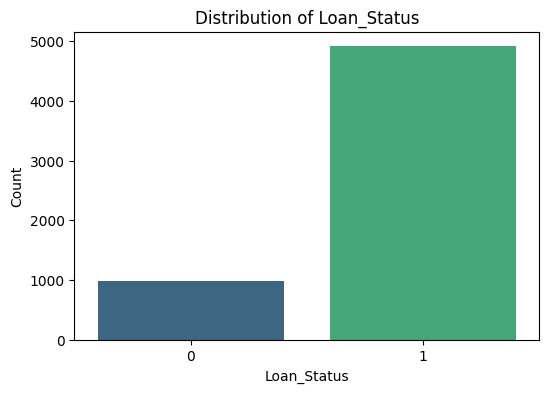

Loan_Status
1    0.832994
0    0.167006
Name: proportion, dtype: float64


In [15]:

def plot_target_distribution(df, target_column):

    """
    Plot the distribution of the target variable.
    Parameters:
        df (pd.DataFrame): The dataset containing the target variable.
        target_column (str): The name of the target column (e.g., 'Loan_Status').
    Returns:
        None
    """

    # Count the values in the target column
    target_counts = df[target_column].value_counts()
    # Plot the distribution as a bar chart
    plt.figure(figsize=(6, 4))
    sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')
    plt.title(f"Distribution of {target_column}")
    plt.xlabel(target_column)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# Usage
plot_target_distribution(train, "Loan_Status")

# Assuming `y` is your target variable
print(train['Loan_Status'].value_counts(normalize=True))  # Percentage distribution


### 2.6 Correlation Analysis





After computing skewness, I decided to run a correlation analysis to check how the features in my dataset relate to the target variable, **Loan_Status**. The results were as follows:



| **Feature**           | **Correlation with Loan_Status** |

|------------------------|----------------------------------|

| Property_Area          | 0.026883                       |

| LoanAmount             | 0.014613                       |

| Loan_Amount_Term       | 0.008299                       |

| Self_Employed          | 0.005938                       |

| Credit_History         | 0.001133                       |

| Gender                 | -0.004538                      |

| Total_Income           | -0.004700                      |

| CoapplicantIncome      | -0.007058                      |

| Married                | -0.008111                      |

| ApplicantIncome        | -0.009189                      |

| Education              | -0.010613                      |

| Dependents             | -0.020919                      |



#### **What This Means**

The correlation values show that none of the features have a particularly strong relationship with **Loan_Status**. The highest correlation, **Property_Area** at 0.026883, is still very weak. Most of the other features have near-zero or slightly negative correlations.



#### **Next Steps and Feature Engineering**

Since I already have a **Total_Income** feature in my dataset, I plan to see if there are additional insights or features I can extract from **ApplicantIncome** and **CoapplicantIncome**. Once I’ve engineered any necessary features, I’ll consider dropping these columns if they no longer add value. The goal is to avoid redundancy while ensuring I extract as much information as possible.



#### **Conclusion**

This analysis highlights the need to create new features or transform existing ones to bring out stronger relationships with the target variable. For now, I’ll focus on feature engineering and revisiting the dataset to optimize its predictive power.

/tmp/ipykernel_17/1464274265.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Dependents'] = df['Dependents'].replace(dependents_mapping)


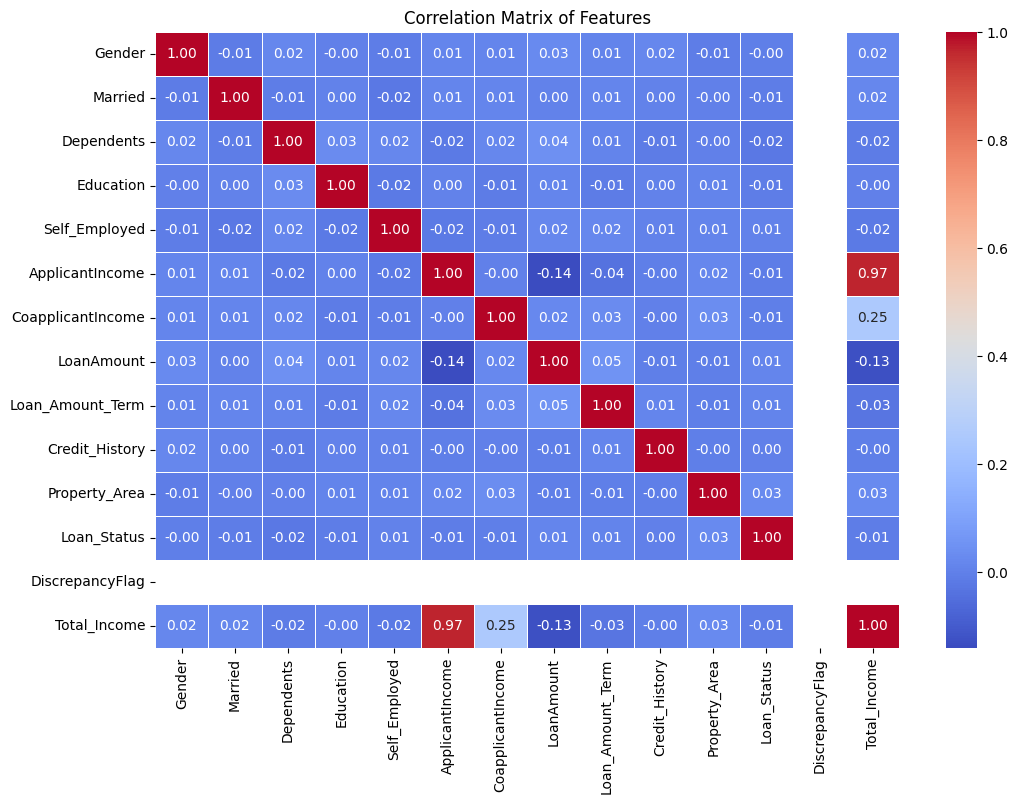

Correlation with Loan_Status:
Loan_Status          1.000000
Property_Area        0.026883
LoanAmount           0.014613
Loan_Amount_Term     0.008299
Self_Employed        0.005938
Credit_History       0.001133
Gender              -0.004538
CoapplicantIncome   -0.007058
Married             -0.008111
ApplicantIncome     -0.009189
Education           -0.010613
Total_Income        -0.010665
Dependents          -0.020919
DiscrepancyFlag           NaN
Name: Loan_Status, dtype: float64


In [16]:

def plot_correlation_matrix(df):
    """
    This function takes a dataframe as input, drops the 'ID' and 'Loan_ID' columns,
    maps the 'Dependents' column to numerical values, computes the correlation matrix,
    and plots the heatmap of correlations.
    Parameters:
    df (DataFrame): The dataset containing the features to analyze.
    Returns:
    None: Displays the correlation heatmap plot.
    """
    # Mapping 'Dependents' column to numerical values
    dependents_mapping = {'0': 0, '1': 1, '2': 2, '3+': 4}
    df['Dependents'] = df['Dependents'].replace(dependents_mapping)
    # Convert 'Dependents' to numeric values
    df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')  # In case of any invalid values, they will be set to NaN
    # Drop 'ID' and 'Loan_ID' columns
    df = df.drop(columns=['ID', 'Loan_ID'], axis=1)

    # Compute correlation matrix
    correlation_matrix = df.corr()
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Features')
    plt.show()

    # For a specific feature (e.g., Loan_Status), print correlation with other variables
    target_corr = correlation_matrix['Loan_Status'].sort_values(ascending=False)
    print("Correlation with Loan_Status:")
    print(target_corr)
# Example usage:
plot_correlation_matrix(train)

## **3. Preprocessing Steps**

The pre-processing phase involved several important steps to ensure the dataset was ready for modeling. The first task was handling outliers and skewness in the data.

### **3.1 Handling Outliers and Skewness**



The first step in my pre-processing workflow was handling the outliers identified during my analysis. For this, I applied the following transformations:  



- **Log Transformation** for **Applicant Income**, **Co-applicant Income**, and **Total Income** to address the skewness and reduce the impact of extreme outliers.  

- **Robust Scaling** for **Loan Amount** to minimize the influence of outliers on the scaling process.  



These decisions were made after careful consideration of the distribution of values and the characteristics of the outliers, as detailed in the previous section.  



##### **Assessing the Effectiveness of Outlier Handling**  

To evaluate the impact of these transformations, I:  

1. **Visualized the Outliers**: After applying the transformations, I plotted the distributions again to check for visible changes. As expected, there wasn't a drastic shift in the outliers' appearance, which aligns with my earlier observation that the percentage of outliers in the dataset was relatively small.  

2. **Computed Summary Statistics**: I analyzed the mean, median, standard deviation, and other descriptive statistics to confirm that the transformations were applied correctly. This approach gave a clearer indication that the transformations adjusted the distributions as intended.  



##### **Skewness Handling**  

Interestingly, during this analysis, I realized that some of the transformations I had applied for handling outliers (e.g., log transformation) inherently addressed the skewness in the data. After cross-checking the skewness post-transformation, I found that the skewness levels were now acceptable, eliminating the need for additional skewness-specific transformations.  



This integrated approach allowed me to streamline the pre-processing steps while ensuring that the data was well-prepared for modeling.

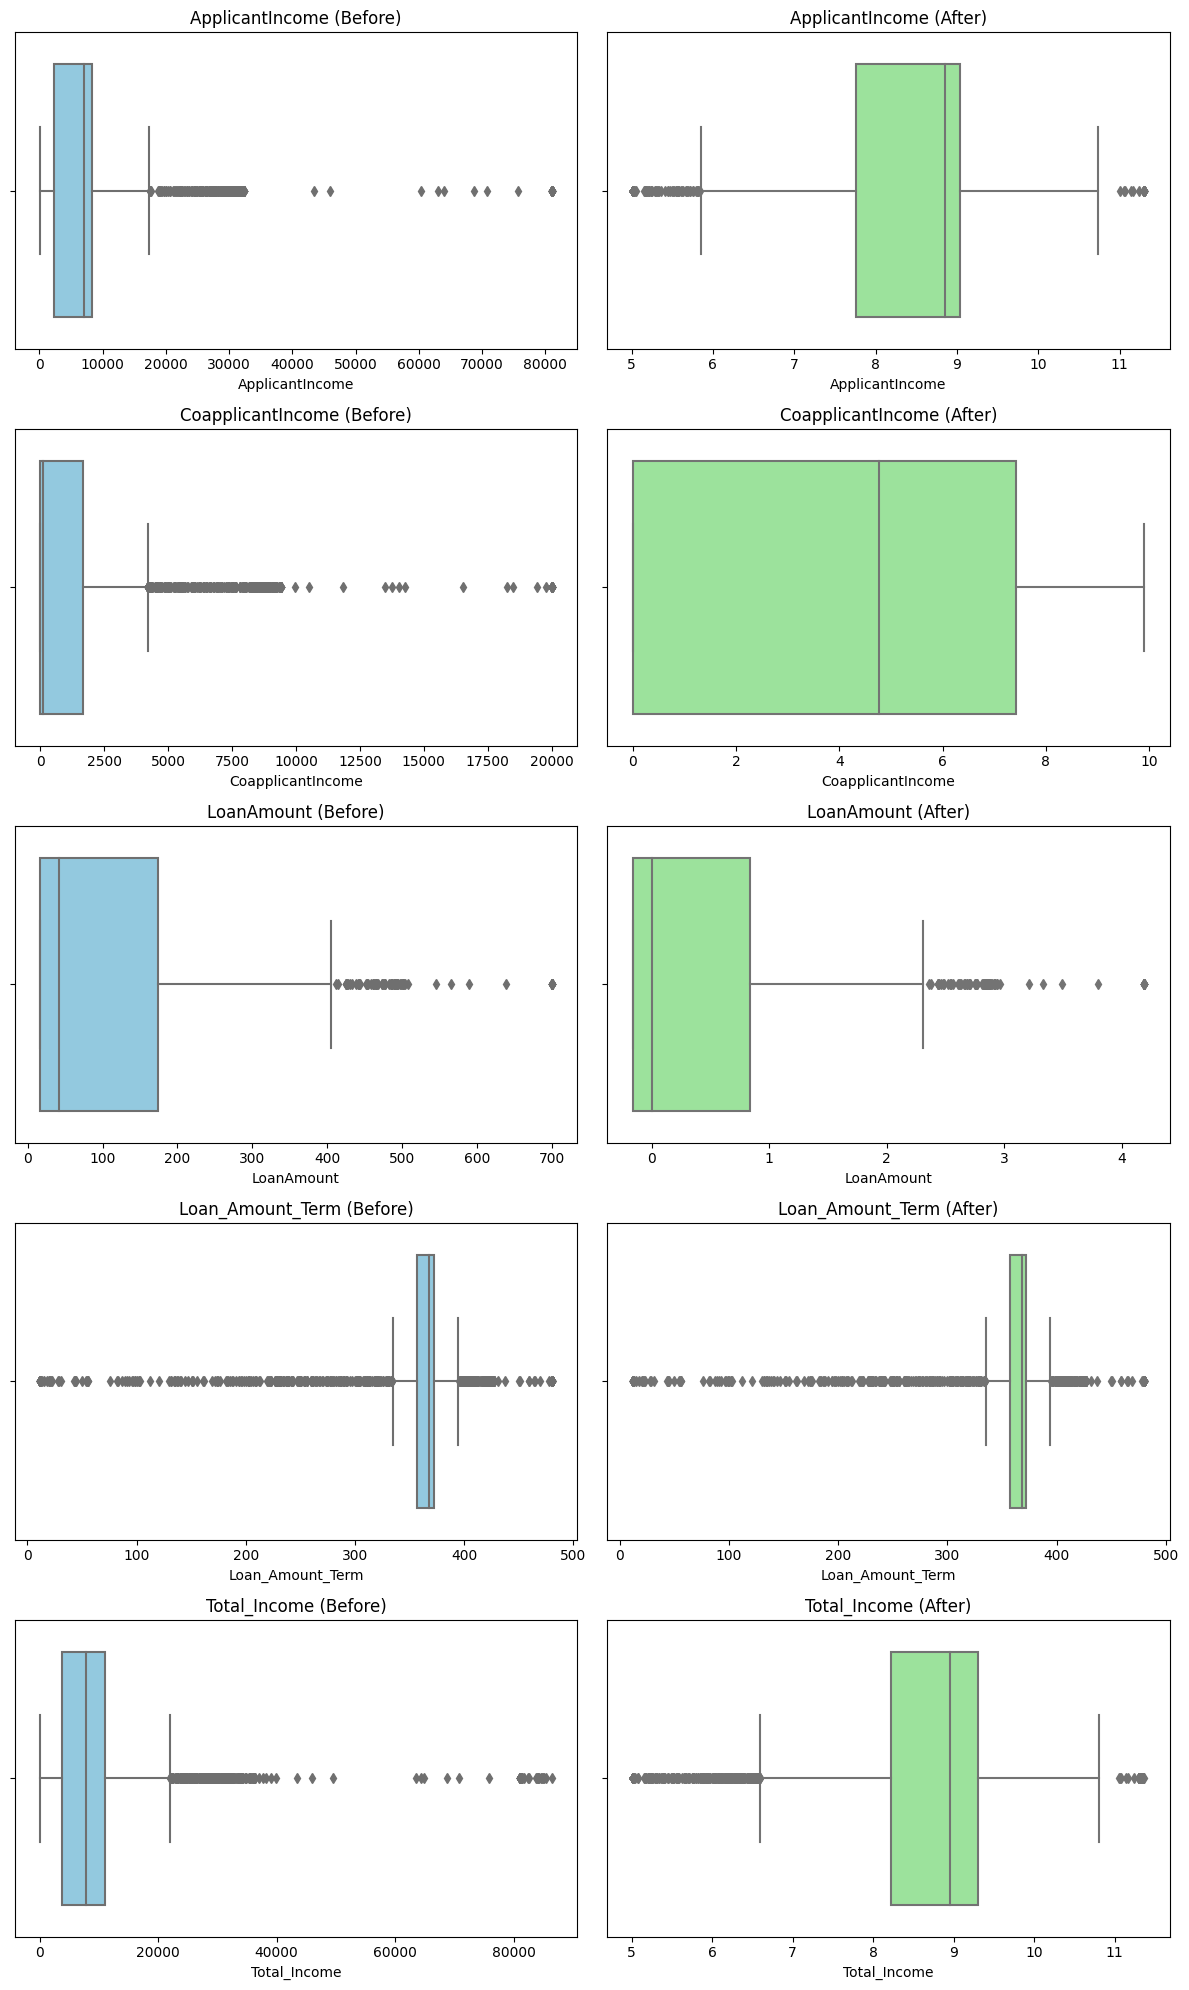


Summary Statistics for ApplicantIncome_log1p:

Before:
count     5898.000000
mean      7782.026958
std       9182.571831
min        150.000000
25%       2342.250000
50%       6989.000000
75%       8375.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

After:
count    5898.000000
mean        8.212301
std         1.576214
min         5.017280
25%         7.759294
50%         8.852236
75%         9.033126
max        11.302217
Name: ApplicantIncome, dtype: float64
--------------------------------------------------

Summary Statistics for Total_Income_log1p:

Before:
count     5898.000000
mean      9027.981506
std       9479.564621
min        150.000000
25%       3730.000000
50%       7796.748153
75%      11028.641894
max      86414.875663
Name: Total_Income, dtype: float64

After:
count    5898.000000
mean        8.528622
std         1.371701
min         5.017280
25%         8.224432
50%         8.961590
75%         9.308342
max        11.366927
Name: Total_Income, dtype

In [17]:
# Handle Outliers
def handle_outliers(train_data, test_data):
    results = {}  # Store summary statistics for comparison
    # Apply log1p transformation to ApplicantIncome and TotalIncome
    for col in ['ApplicantIncome', 'Total_Income', 'CoapplicantIncome']:
        # Save pre-transformation statistics
        results[f"{col}_log1p_before"] = train_data[col].describe()
        train_data[col] = train_data[col].apply(lambda x: np.log1p(x) if x > 0 else 0)
        test_data[col] = test_data[col].apply(lambda x: np.log1p(x) if x > 0 else 0)
        # Save post-transformation statistics
        results[f"{col}_log1p_after"] = train_data[col].describe()
    # Apply Robust Scaling to LoanAmount
    results["LoanAmount_robust_scaler_before"] = train_data['LoanAmount'].describe()
    robust_scaler = RobustScaler()
    train_data['LoanAmount'] = robust_scaler.fit_transform(train_data[['LoanAmount']])
    test_data['LoanAmount'] = robust_scaler.transform(test_data[['LoanAmount']])
    results["LoanAmount_robust_scaler_after"] = train_data['LoanAmount'].describe()
    return train_data, test_data, results

# Visualize Outliers
def visualize_outliers(before_data, after_data, columns):
    num_cols = len(columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, num_cols * 4))
    for i, col in enumerate(columns):
        # Before outlier handling
        sns.boxplot(data=before_data, x=col, ax=axes[i, 0], color="skyblue")
        axes[i, 0].set_title(f"{col} (Before)")
        # After outlier handling
        sns.boxplot(data=after_data, x=col, ax=axes[i, 1], color="lightgreen")
        axes[i, 1].set_title(f"{col} (After)")
    plt.tight_layout()
    plt.show()

# Compare Summary Statistics
def compare_summary_statistics(results, transformations):
    """
    Print a comparison of summary statistics for each transformation.
    Args:
        results (dict): Dictionary of before-and-after statistics.
        transformations (list): List of transformations to display.
    """
    for transformation in transformations:
        print(f"\nSummary Statistics for {transformation}:\n")
        print("Before:")
        print(results[f"{transformation}_before"])
        print("\nAfter:")
        print(results[f"{transformation}_after"])
        print("-" * 50)

# Ensure correct order of operations
columns_to_visualize = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income']
# Simulate the original data for visualization
original_train_data = train.copy()
original_test_data = test.copy()

# Handle outliers
train, test, transformation_results = handle_outliers(train, test)

# Visualize changes
visualize_outliers(original_train_data, train, columns_to_visualize)

# Compare summary statistics for specific transformations
transformations_to_compare = [
    "ApplicantIncome_log1p", "Total_Income_log1p",
    "CoapplicantIncome_log1p",
    "LoanAmount_robust_scaler"
]
compare_summary_statistics(transformation_results, transformations_to_compare)

In [18]:
# Compute skewness for train dataset
train_skewness = compute_skewness(train, loan_id_col="Loan_ID", numeric_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Total_Income"])
print("New skewness in Training Dataset:\n", train_skewness)
# Compute skewness for test dataset
test_skewness = compute_skewness(test, loan_id_col="Loan_ID", numeric_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Total_Income"])
print("New skewness in Test Dataset:\n", test_skewness)

New skewness in Training Dataset:
               Column  Skewness
0    ApplicantIncome -1.059909
1  CoapplicantIncome  0.064292
2         LoanAmount  1.486343
3       Total_Income -1.342545
New skewness in Test Dataset:
               Column  Skewness
0    ApplicantIncome -1.077144
1  CoapplicantIncome  0.014014
2         LoanAmount  1.485648
3       Total_Income -1.347728


### **3.2 Encoding**



After handling outliers and skewness, the next step was to encode categorical variables so they could be effectively used by the model. Here's how I approached encoding for different columns:



-  **`Loan Amount Term`**  

For **Loan_Amount_Term**, I converted the variable to an ordinal feature. This is because **Loan_Amount_Term** represents distinct loan term options, typically in terms of months (e.g., 360 months, 180 months), which have a natural order but don't have a continuous relationship. Treating this as an ordinal feature allows the model to capture any inherent ranking, where shorter loan terms might be associated with quicker repayment periods.



- **`Dependents`**  

For **Dependents**, I used simple ordinal encoding. This feature represents the number of dependents a borrower has, which is a discrete, countable value (e.g., 0, 1, 2, or more). Since the values have an inherent order (e.g., more dependents could indicate higher financial responsibilities), it made sense to encode it as an ordinal feature, where the values represent an increasing order of dependents.



- **`Property Area`**  

For **Property_Area**, I applied one-hot encoding. Since this feature categorizes the property location as rural, semiurban, or urban, and these categories don't have a natural order or ranking, one-hot encoding was the best approach. This method creates separate binary columns for each category, allowing the model to treat them as distinct groups without implying any order between them.





These encoding techniques were chosen based on the type and nature of the categorical variables. By using appropriate encoding methods, I ensured that the model could interpret and learn from the features correctly, without making incorrect assumptions about their relationships.

In [19]:
# 1. Handle loan_amount_term: Convert to categorical (binned)
bins = [0, 60, 120, 240, 480]  # Define bin edges for loan terms
labels = ['Short-term', 'Medium-term', 'Long-term', 'Very long-term']  # Define category labels
train['loan_term_category'] = pd.cut(train['Loan_Amount_Term'], bins=bins, labels=labels)
test['loan_term_category'] = pd.cut(test['Loan_Amount_Term'], bins=bins, labels=labels)
# 2. Apply Ordinal Encoding to 'loan_term_category'
ordinal_encoder = OrdinalEncoder(categories=[labels])
train['loan_term_encoded'] = ordinal_encoder.fit_transform(train[['loan_term_category']])
test['loan_term_encoded'] = ordinal_encoder.transform(test[['loan_term_category']])
# Create the OrdinalEncoder with explicit category mapping
dependents_categories = [['0', '1', '2', '3+', '4']]  # Ensure categories as strings
dependents_encoder = OrdinalEncoder(categories=dependents_categories)
# First, convert Dependents to string type to match encoder expectations
train['Dependents'] = train['Dependents'].astype(str)
test['Dependents'] = test['Dependents'].astype(str)
# Fit the encoder on train data
dependents_encoder.fit(train[['Dependents']])
# Transform both train and test
train['dependents_encoded'] = dependents_encoder.transform(train[['Dependents']])
test['dependents_encoded'] = dependents_encoder.transform(test[['Dependents']])
# 4. Encode 'PropertyArea' as an ordinal feature
property_area_encoder = OrdinalEncoder(categories=[[0, 1, 2]])  # 0 = rural, 1 = semi-urban, 2 = urban
train['PropertyArea_encoded'] = property_area_encoder.fit_transform(train[['Property_Area']])
test['PropertyArea_encoded'] = property_area_encoder.transform(test[['Property_Area']])

In [20]:
print(train.head(10))

print(test.head(10))

      ID   Loan_ID  Gender  Married Dependents  Education  Self_Employed  \
0  74768  LP002231       1        1          0          1              0   
1  79428  LP001448       1        1          0          0              0   
2  70497  LP002231       0        0          0          0              0   
3  87480  LP001385       1        1          0          0              0   
4  33964  LP002231       1        1          1          0              0   
5  20364  LP001778       0        1          0          0              0   
6  63354  LP002180       1        1          4          0              0   
7  67110  LP002585       1        1          1          0              0   
8  69254  LP001385       1        1          1          1              0   
9  92855  LP002175       1        1          0          0              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0         9.027499           0.000000   -0.159236               363   
1         5.017280   

In [21]:
print(train.columns)

print(test.columns)

Index(['ID', 'Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'DiscrepancyFlag', 'Total_Income', 'loan_term_category',
       'loan_term_encoded', 'dependents_encoded', 'PropertyArea_encoded'],
      dtype='object')
Index(['ID', 'Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'DiscrepancyFlag', 'Total_Income', 'loan_term_category',
       'loan_term_encoded', 'dependents_encoded', 'PropertyArea_encoded'],
      dtype='object')


## 4. Feature Engineering



After performing the necessary pre-processing steps, I focused on feature engineering to enhance the dataset and create more meaningful variables for the machine learning model. I first dropped certain columns that were either unnecessary or redundant. Specifically:



- **ID** and **Loan ID** were dropped because they served as unique identifiers and did not contribute to the model's predictive power.

- **Dependents** and **Property Area** were already encoded, so there was no need to keep the original columns.

- **Loan Term Category** was discarded as it was not deemed important for the analysis.



Following this, I created several new features that were derived from the existing columns. These engineered features were designed to capture more meaningful relationships between the variables and help the model perform better. Here's an explanation of the features I created:



1. **Monthly Payment Burden**  

   This feature represents the fraction of monthly loan payment relative to the total income. It’s calculated as the **Loan Amount** divided by the **Loan Term**, and then divided by **Total Income**. This can help the model understand how the burden of the loan compares to the applicant’s financial situation.



2. **Family Financial Stability Index**  

   This feature combines the marital status, number of dependents, and co-applicant income. By encoding marital status and summing it with the dependents and co-applicant income, this feature provides an indication of the family’s overall financial stability and support network.



3. **Total Income**  

   A simple sum of **Applicant Income** and **Coapplicant Income**, this feature helps to represent the complete household income, which is crucial for understanding the borrower’s ability to repay the loan.



4. **Debt-to-Income Ratio**  

   This is the ratio of **Loan Amount** to **Total Income**, which measures how much of the applicant's income is consumed by debt repayment. A higher ratio might indicate financial stress or difficulty in repaying the loan.



5. **Credit History + Loan Amount**  

   This interaction feature combines **Credit History** and **Loan Amount** to capture how the applicant's creditworthiness might influence their borrowing amount. A higher loan amount with poor credit history could indicate higher risk.



6. **Credit History + Total Income**  

   This interaction feature combines **Credit History** and **Total Income** to assess how an applicant's creditworthiness relates to their overall income. A person with a high income but poor credit history might pose a higher risk to the lender.



7. **Education + Self-Employed**  

   This feature combines **Education** and **Self-Employed** status. It can help the model understand how the combination of education and employment type might affect the loan outcome. Self-employed individuals with higher education might have different financial behaviors than others.



8. **Dependents + Loan Amount Term**  

   This interaction feature combines the number of **Dependents** with the **Loan Term**. The reasoning here is that individuals with more dependents might prefer shorter loan terms to repay quickly and reduce financial burden.



9. **Gender + Marital Status**  

   This feature is an interaction between **Gender** and **Marital Status**. It might help capture different loan behaviors based on marital status and gender, which can influence financial decisions and stability.



10. **Property Area + Total Income**  

    Combining **Property Area** (rural, semiurban, or urban) with **Total Income** helps capture the relationship between geographical location and the income level, which could indicate the applicant's financial stability and lifestyle.



These engineered features were added to both the **train** and **test** datasets to ensure consistency, allowing the model to utilize these new variables for better predictions. These new features provide deeper insights into the financial situation of applicants, which may not be captured by the original features alone.

In [22]:
def clean_data(train, test):
    # List of columns to drop
    columns_to_drop = [
        'ID',             # Unique identifier
        'Loan_ID',          # Unique loan ID
        'Dependents',       # Already encoded
        'Property_Area',    # Already encoded
        'loan_term_category' # Redundant after encoding
    ]
    # Drop the columns from both train and test datasets
    train.drop(columns=columns_to_drop, axis=1, inplace=True)
    test.drop(columns=columns_to_drop, axis=1, inplace=True)
clean_data(train, test)

In [23]:
# Function to create features
def create_features(train_df, test_df):
    # Ensure that both train and test datasets have the same columns for consistency
    df_train = train_df.copy()
    df_test = test_df.copy()
    # 1. Monthly Payment Burden (LoanAmount / Loan_Amount_Term) / Total_Income
    df_train['Monthly_Payment_Burden'] = (df_train['LoanAmount'] / df_train['Loan_Amount_Term']) / df_train['Total_Income']
    df_test['Monthly_Payment_Burden'] = (df_test['LoanAmount'] / df_test['Loan_Amount_Term']) / df_test['Total_Income']
    # 2. Family Financial Stability Index (Married + Dependents + CoapplicantIncome)
    df_train['Family_Financial_Stability'] = df_train['Married'].apply(lambda x: 1 if x == 'Yes' else 0) + \
                                             df_train['dependents_encoded'] + df_train['CoapplicantIncome']
    df_test['Family_Financial_Stability'] = df_test['Married'].apply(lambda x: 1 if x == 'Yes' else 0) + \
                                            df_test['dependents_encoded'] + df_test['CoapplicantIncome']
    # 3. Debt-to-Income Ratio (LoanAmount / TotalIncome)
    df_train['Debt_to_Income_Ratio'] = df_train['LoanAmount'] / df_train['Total_Income']
    df_test['Debt_to_Income_Ratio'] = df_test['LoanAmount'] / df_test['Total_Income']
    # 4. Credit_History + LoanAmount (Interaction Feature)
    df_train['Credit_History_LoanAmount'] = df_train['Credit_History'] * df_train['LoanAmount']
    df_test['Credit_History_LoanAmount'] = df_test['Credit_History'] * df_test['LoanAmount']
    # 5. Credit_History + TotalIncome (Interaction Feature)
    df_train['Credit_History_TotalIncome'] = df_train['Credit_History'] * df_train['Total_Income']
    df_test['Credit_History_TotalIncome'] = df_test['Credit_History'] * df_test['Total_Income']
    # 6. Education + Self_Employed (Interaction Feature)
    df_train['Education_SelfEmployed'] = df_train['Education'] + df_train['Self_Employed'].apply(lambda x: 1 if x == 'Yes' else 0)
    df_test['Education_SelfEmployed'] = df_test['Education'] + df_test['Self_Employed'].apply(lambda x: 1 if x == 'Yes' else 0)
    # 7. Dependents + Loan_Amount_Term (Interaction Feature)
    df_train['Dependents_LoanTerm'] = df_train['dependents_encoded'] + df_train['Loan_Amount_Term']
    df_test['Dependents_LoanTerm'] = df_test['dependents_encoded'] + df_test['Loan_Amount_Term']
    # 8. Gender + Marital Status (Interaction Feature)
    df_train['Gender_Marital_Status'] = df_train['Gender'] + df_train['Married'].apply(lambda x: 1 if x == 'Yes' else 0)
    df_test['Gender_Marital_Status'] = df_test['Gender'] + df_test['Married'].apply(lambda x: 1 if x == 'Yes' else 0)
    # 9. Property_Area + Total_Income (Interaction Feature)
    df_train['Property_Area_TotalIncome'] = df_train['PropertyArea_encoded'] + df_train['Total_Income']
    df_test['Property_Area_TotalIncome'] = df_test['PropertyArea_encoded'] + df_test['Total_Income']
    # Return both transformed train and test DataFrames
    return df_train, df_test
# Usage:
train, test = create_features(train, test)
# The function ensures both the train and test datasets are transformed consistently

After engineering the features, I proceeded with the following steps:



### **Dropping Unnecessary Features**

Once the new features were created, I dropped the original columns that were no longer necessary for the analysis. This included the columns that had either been encoded already or were directly replaced by the engineered features. Specifically, I dropped the following:



- **Original columns** that were replaced by engineered features like **Loan Amount Term**, **Dependents**, and **Property Area**.

- **Original income columns** (**Applicant Income** and **Coapplicant Income**) were also dropped since the **Total Income** feature now captured their combined value.

In [24]:
# List of columns to drop
columns_to_drop = [
    'Gender',
    'CoapplicantIncome',
    'Married',
    'ApplicantIncome',
    'Education',
    'DiscrepancyFlag'  # If this was present in your original dataset

]
# Drop these columns from both train and test datasets
train = train.drop(columns=columns_to_drop, axis=1)
test = test.drop(columns=columns_to_drop, axis=1)
# Verify the columns have been dropped
print("Train dataset columns after drop:", train.columns)
print("Test dataset columns after drop:", test.columns)

Train dataset columns after drop: Index(['Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Loan_Status', 'Total_Income', 'loan_term_encoded',
       'dependents_encoded', 'PropertyArea_encoded', 'Monthly_Payment_Burden',
       'Family_Financial_Stability', 'Debt_to_Income_Ratio',
       'Credit_History_LoanAmount', 'Credit_History_TotalIncome',
       'Education_SelfEmployed', 'Dependents_LoanTerm',
       'Gender_Marital_Status', 'Property_Area_TotalIncome'],
      dtype='object')
Test dataset columns after drop: Index(['Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Total_Income', 'loan_term_encoded', 'dependents_encoded',
       'PropertyArea_encoded', 'Monthly_Payment_Burden',
       'Family_Financial_Stability', 'Debt_to_Income_Ratio',
       'Credit_History_LoanAmount', 'Credit_History_TotalIncome',
       'Education_SelfEmployed', 'Dependents_LoanTerm',
       'Gender_Marital_Status', 'Property_Area_TotalIncome'],
      dt

### **Computing the Correlation Matrix**

With the dataset now containing the necessary features, both original and engineered, I computed a **correlation matrix** to understand the relationships between the features. The purpose of this step was to identify which features were highly correlated with each other, as well as with the target variable (loan approval status).

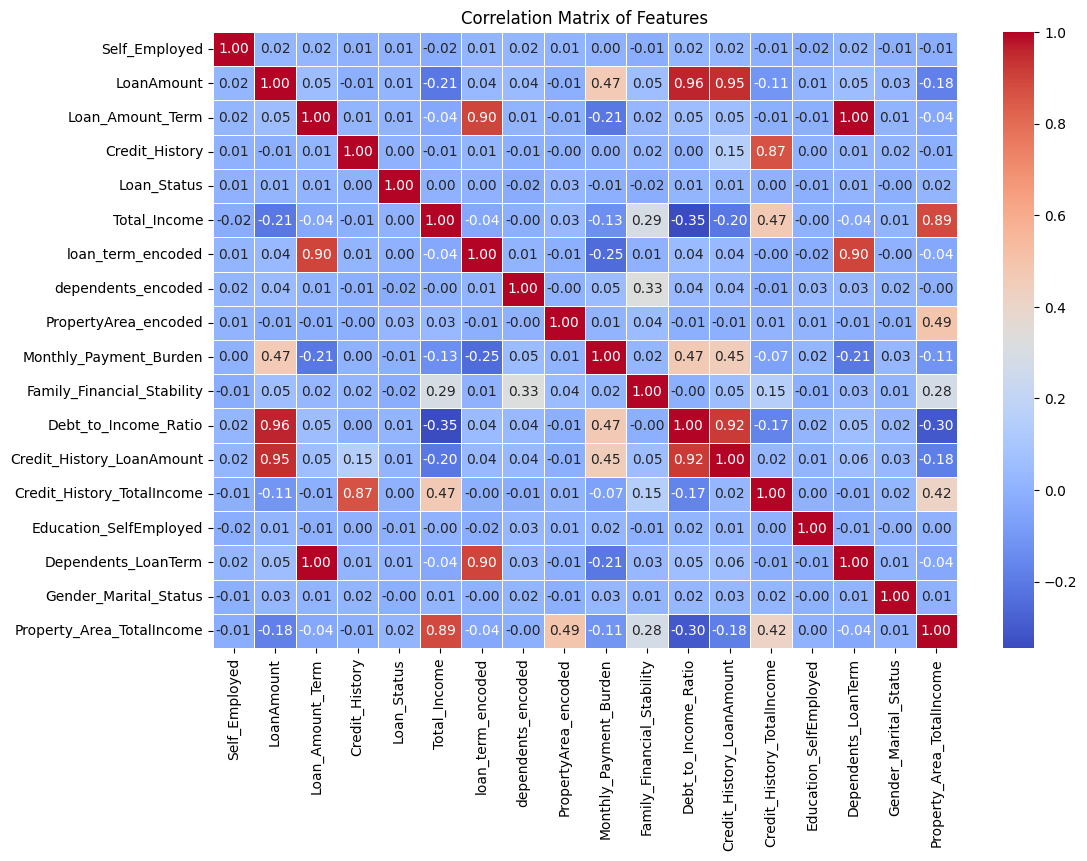

Correlation with Loan_Status:
Loan_Status                   1.000000
PropertyArea_encoded          0.026883
Property_Area_TotalIncome     0.015088
LoanAmount                    0.014613
Debt_to_Income_Ratio          0.014219
Credit_History_LoanAmount     0.012284
Loan_Amount_Term              0.008299
Dependents_LoanTerm           0.007774
Self_Employed                 0.005938
loan_term_encoded             0.003277
Total_Income                  0.003013
Credit_History_TotalIncome    0.001418
Credit_History                0.001133
Gender_Marital_Status        -0.004538
Monthly_Payment_Burden       -0.008844
Education_SelfEmployed       -0.010613
Family_Financial_Stability   -0.018512
dependents_encoded           -0.020919
Name: Loan_Status, dtype: float64


In [25]:
# Compute correlation matrix
correlation_matrix = train.corr()
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# For a specific feature (e.g., Loan_Status), print correlation with other variables
target_corr = correlation_matrix['Loan_Status'].sort_values(ascending=False)
print("Correlation with Loan_Status:")
print(target_corr)

### **Distribution Plotting and Transformation Check**

After comparing the correlation matrix and ensuring that the most important features were selected, I moved on to plotting the distribution of the features. This step was essential to visually inspect if any further transformations were needed to improve the distribution of the features before proceeding to model training.



I used **distribution plots** to visualize the spread of each feature, paying particular attention to whether they followed a **normal distribution** or exhibited any significant skewness. The goal was to identify features that might still require transformations, such as log transformations or normalization, to improve their alignment with the assumptions of certain models (such as linear regression).



Upon reviewing the distribution plots, I found that most of the features were already near normal distribution, indicating that no additional transformations were necessary. This was a positive outcome, as it meant that the features were ready for model training without the need for further manipulation.



This step helped confirm that the pre-processing, including outlier handling and encoding, had been effectively carried out, and that the data was now in good shape for the next stages of the modeling pipeline.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


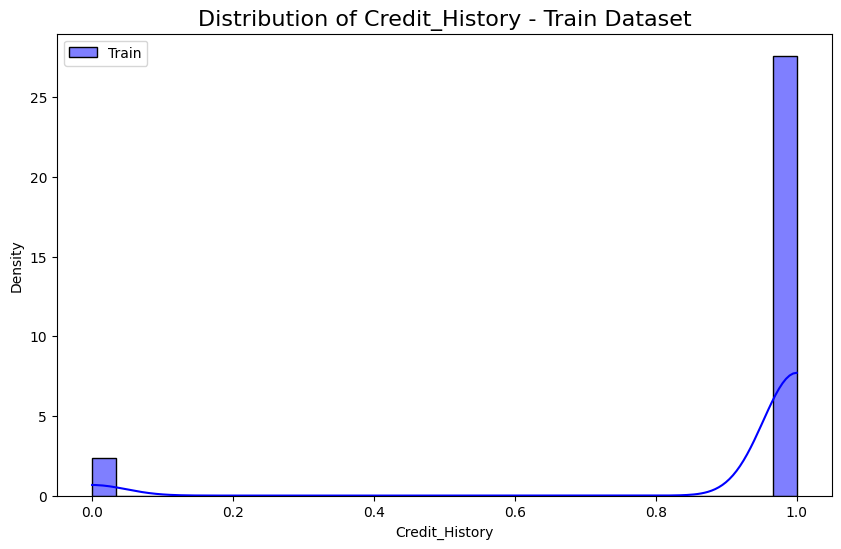

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


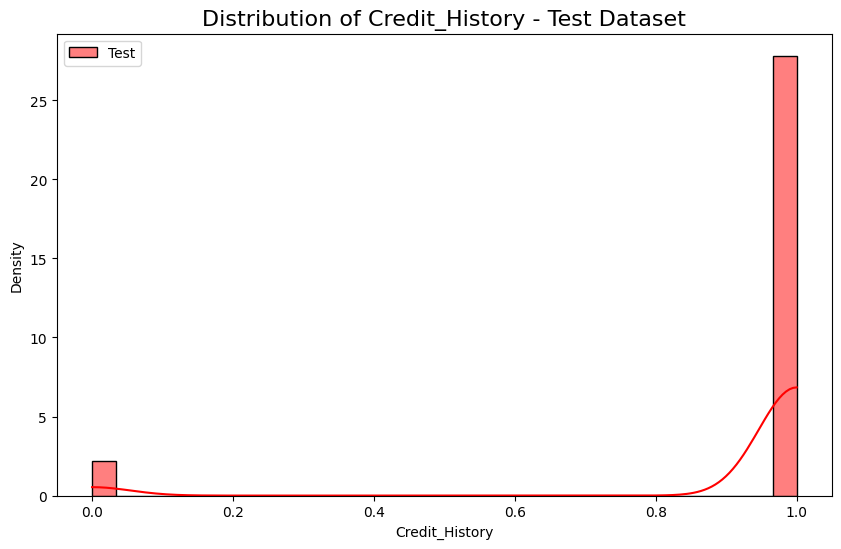

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


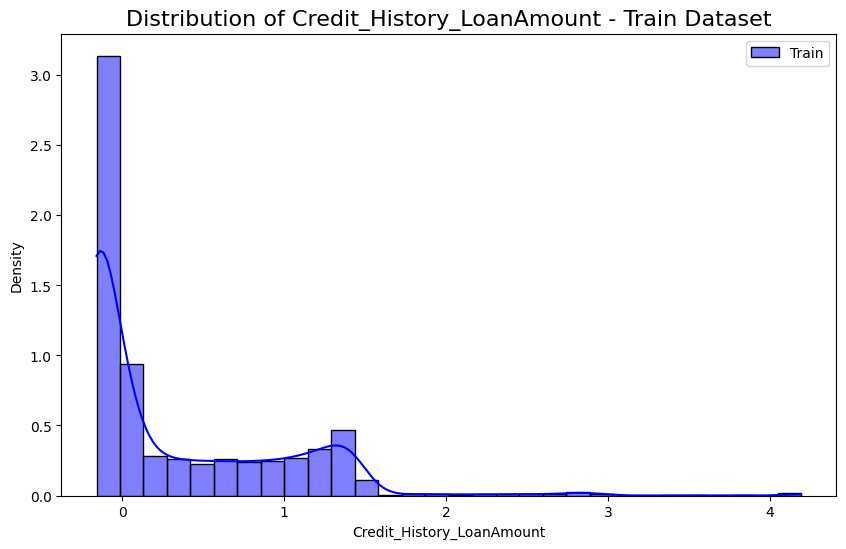

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


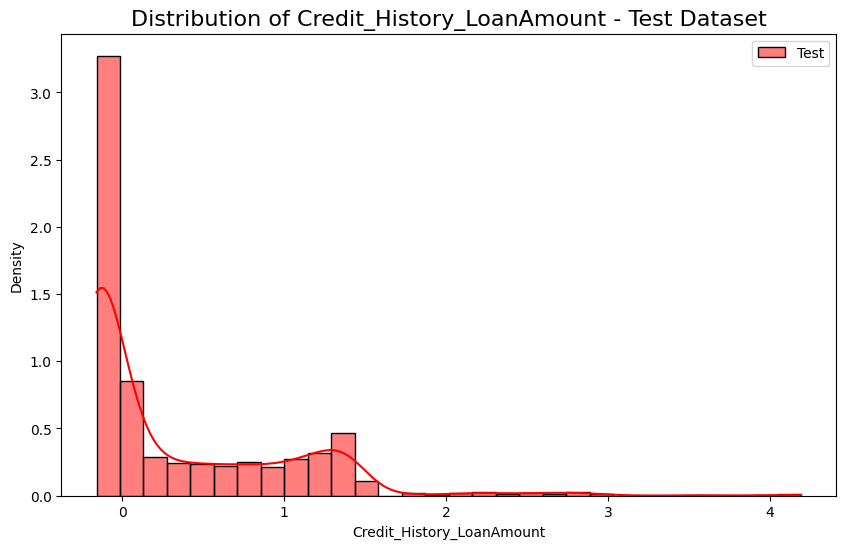

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


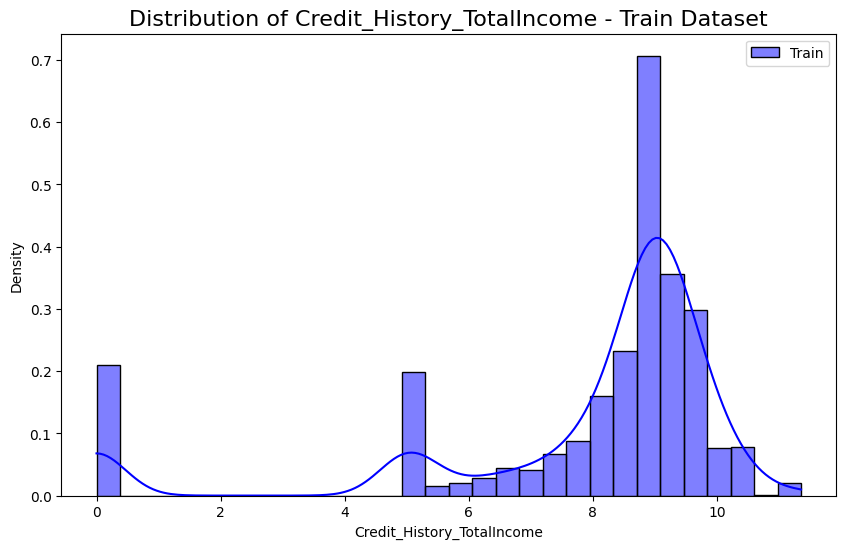

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


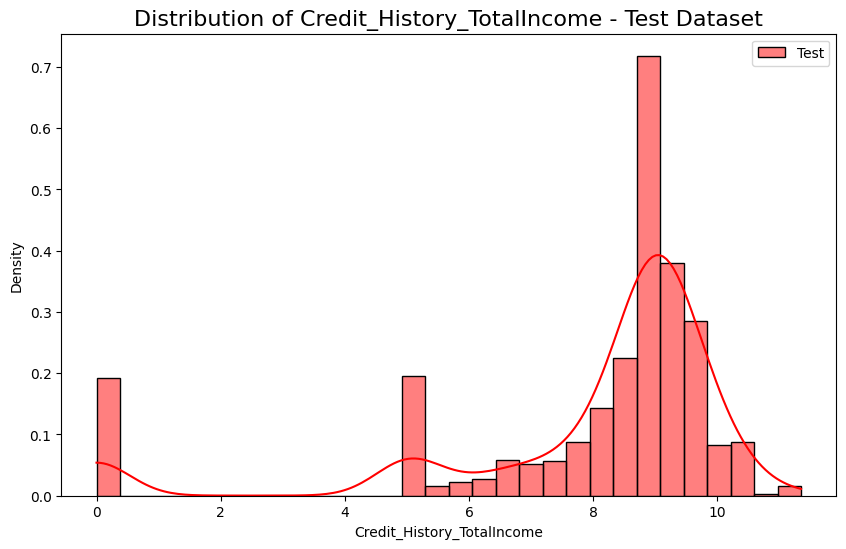

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


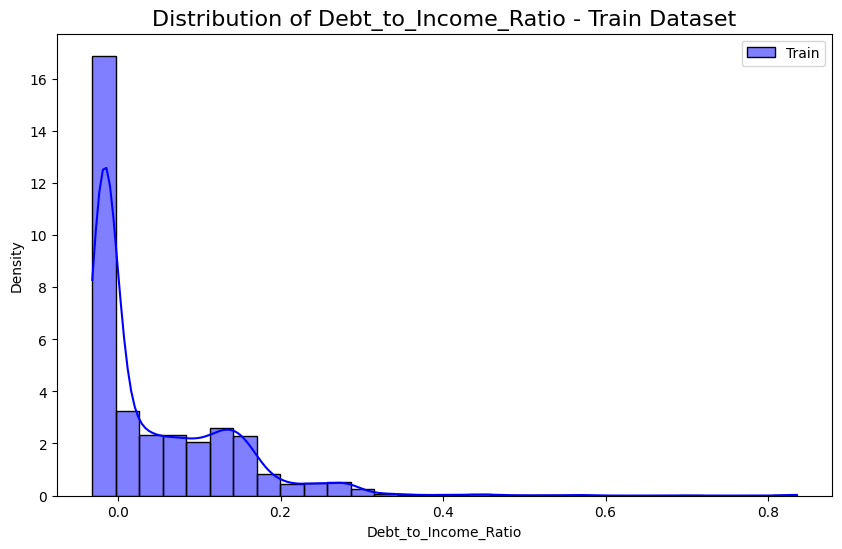

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


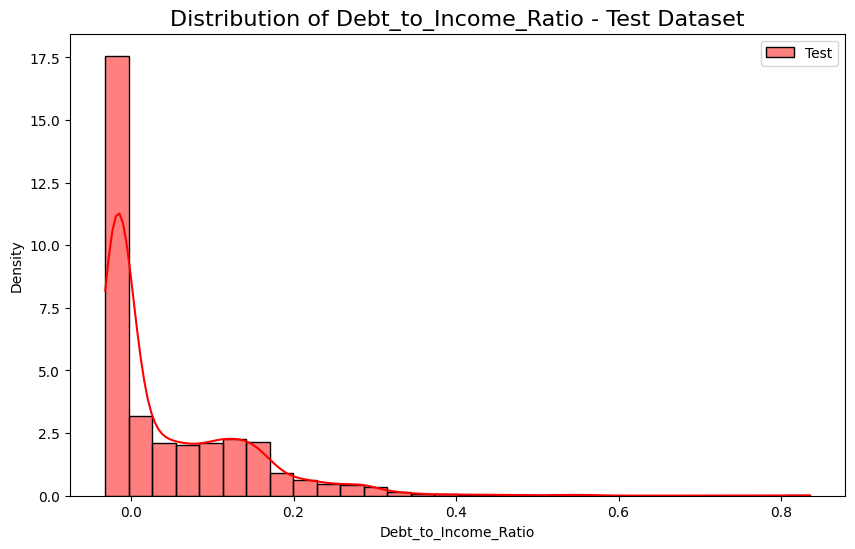

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


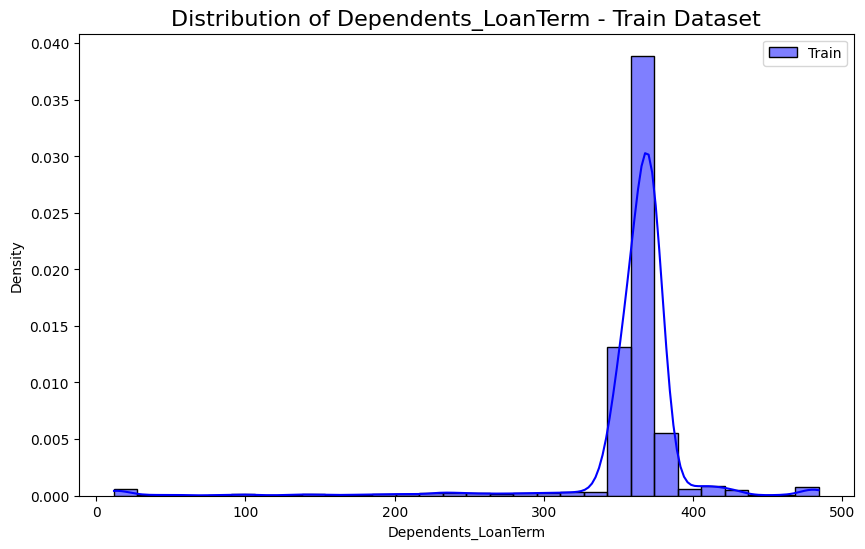

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


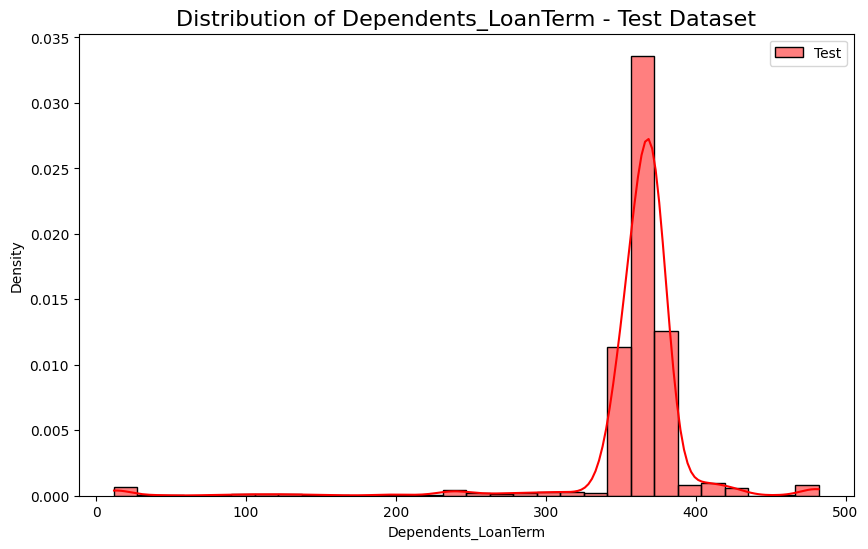

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


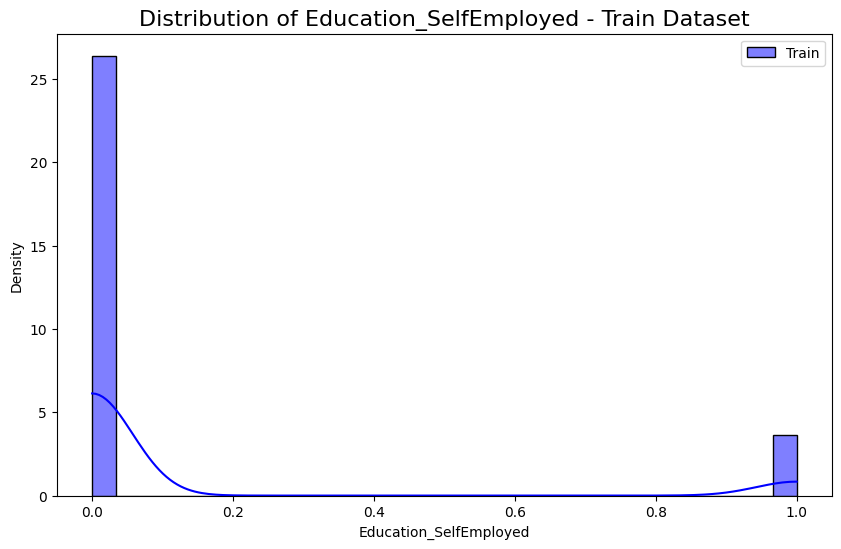

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


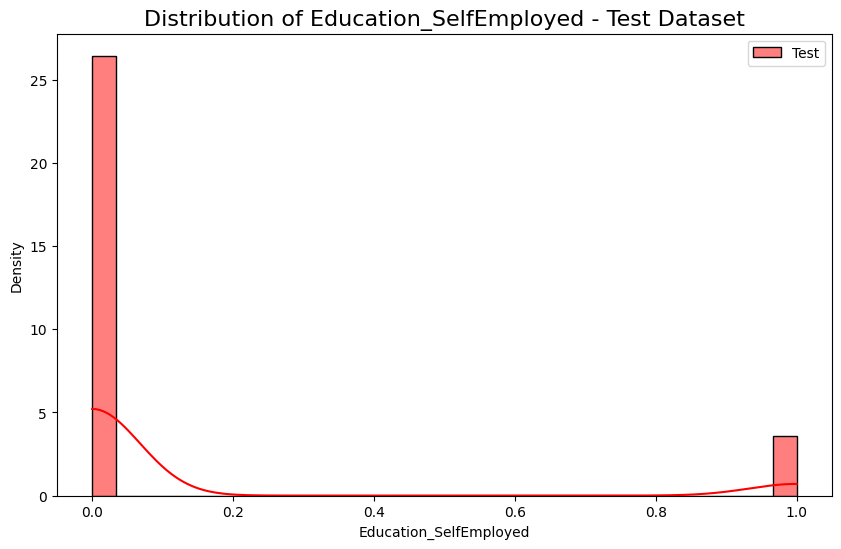

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


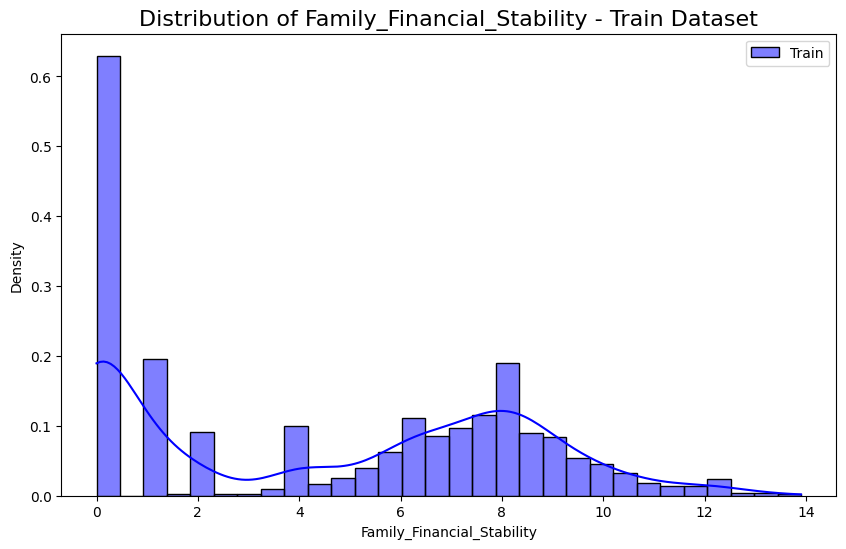

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


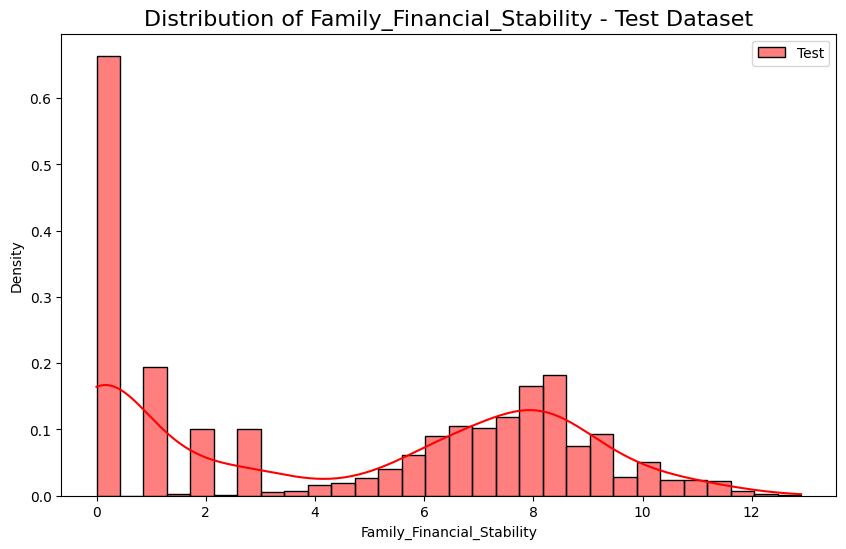

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


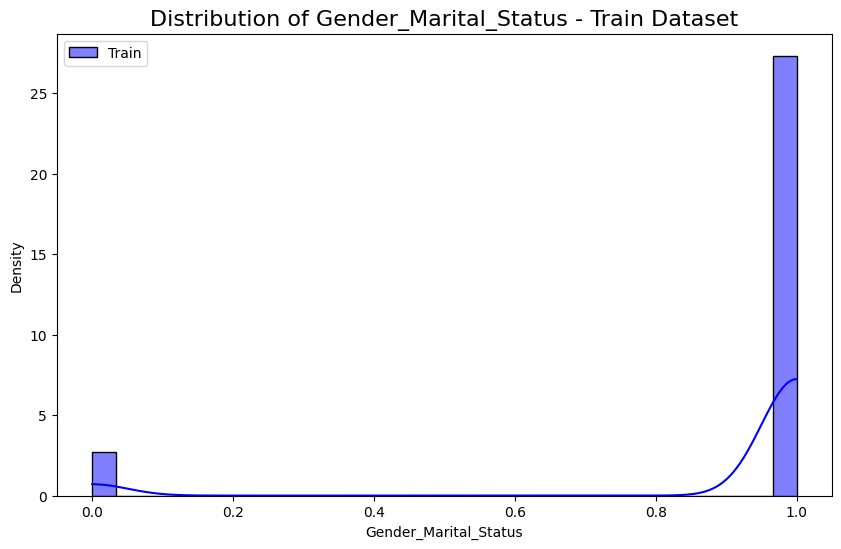

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


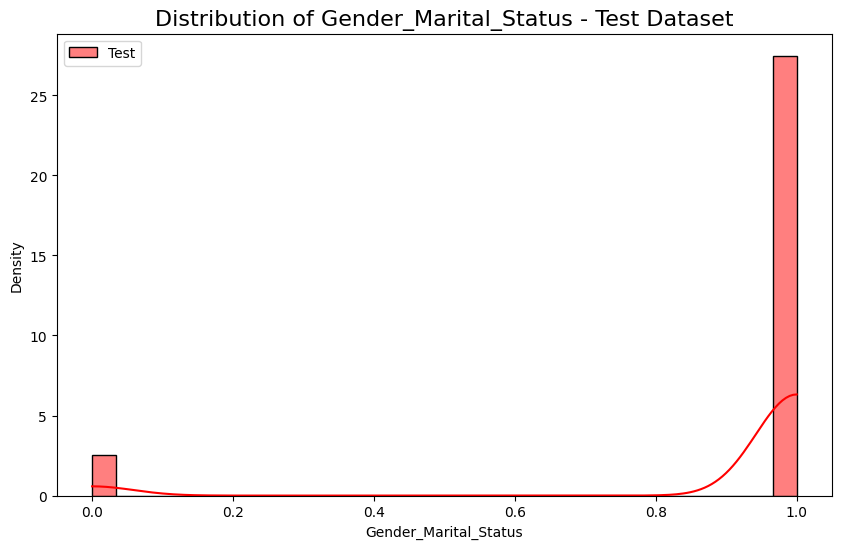

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


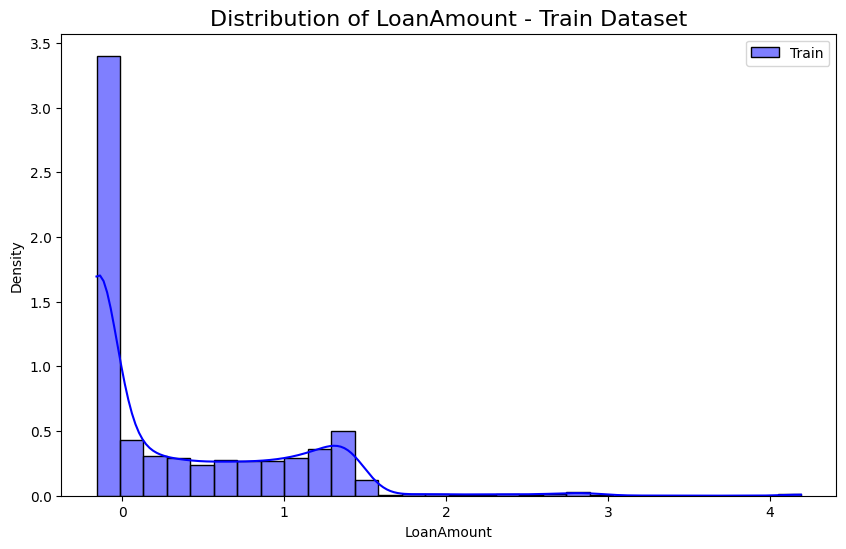

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


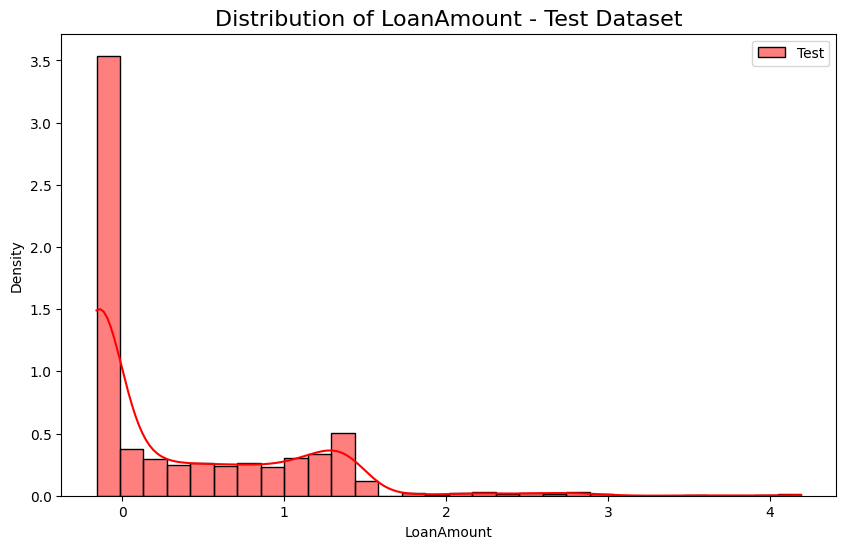

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


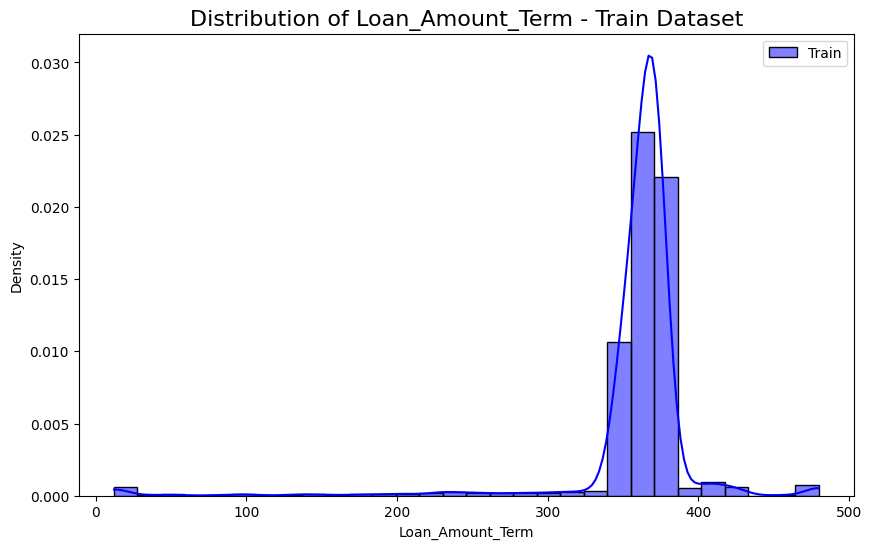

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


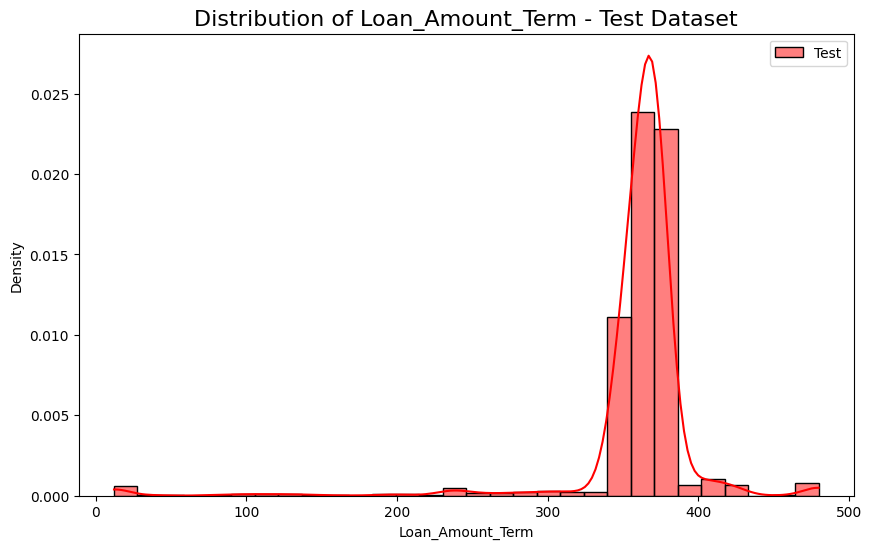

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


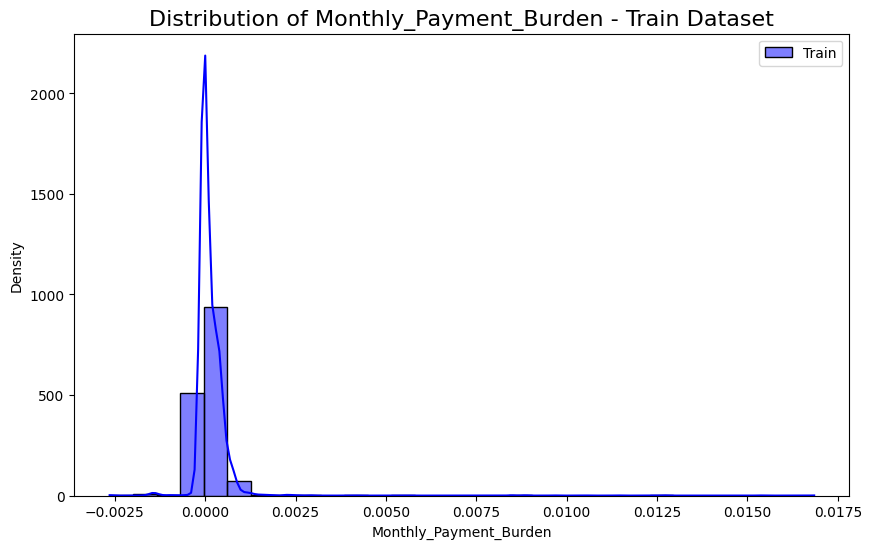

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


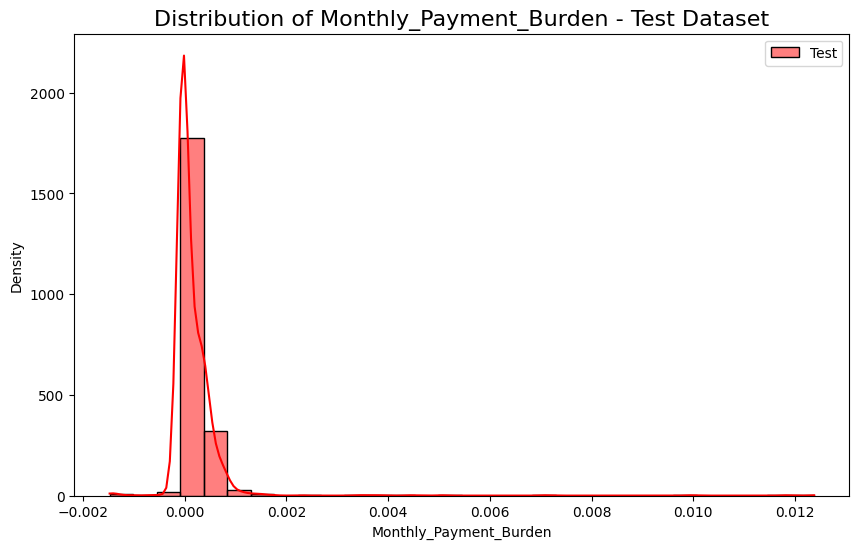

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


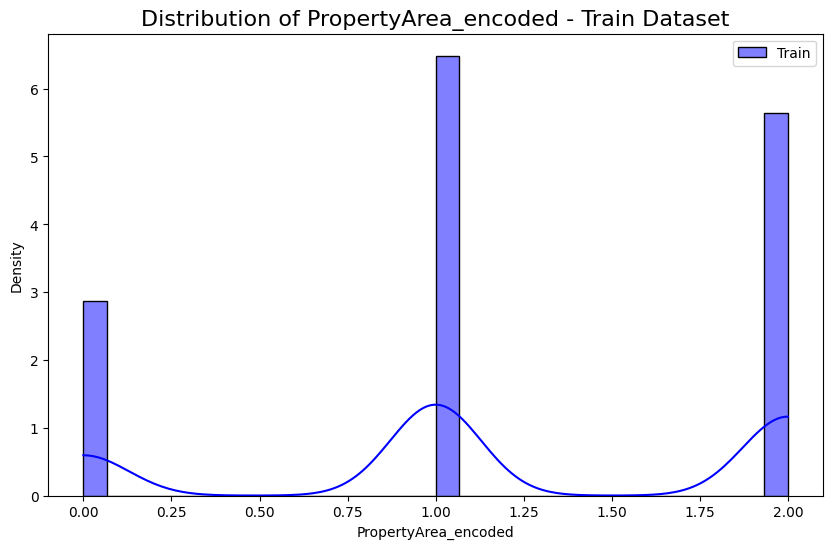

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


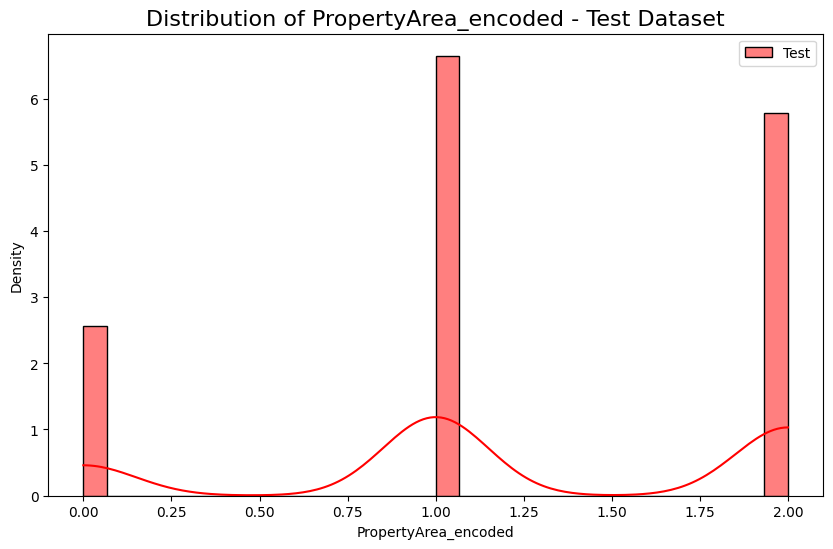

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


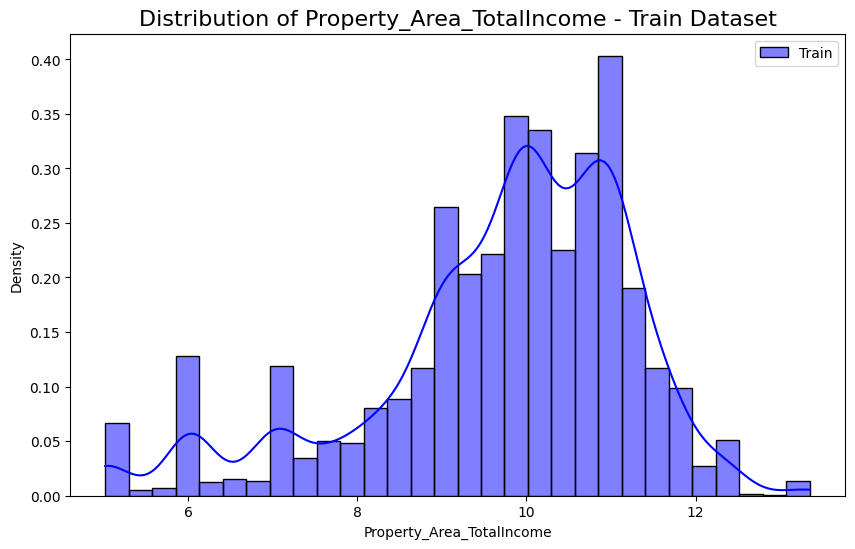

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


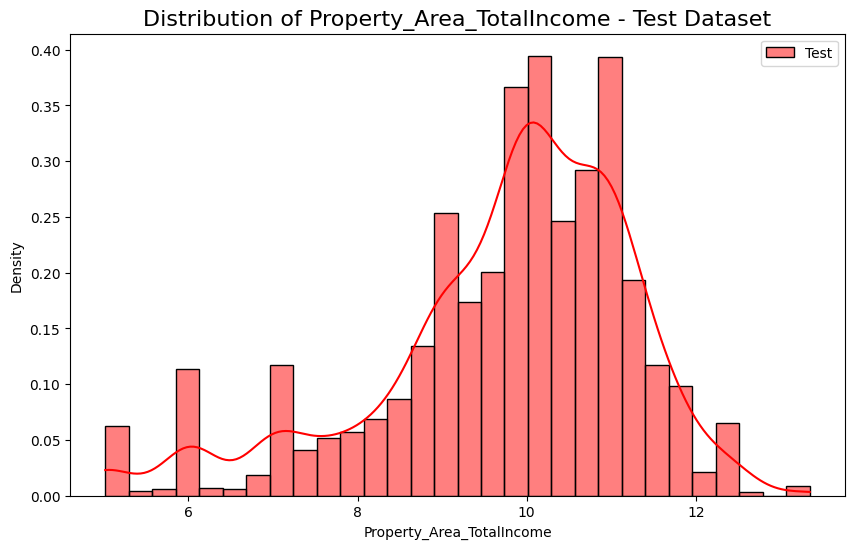

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


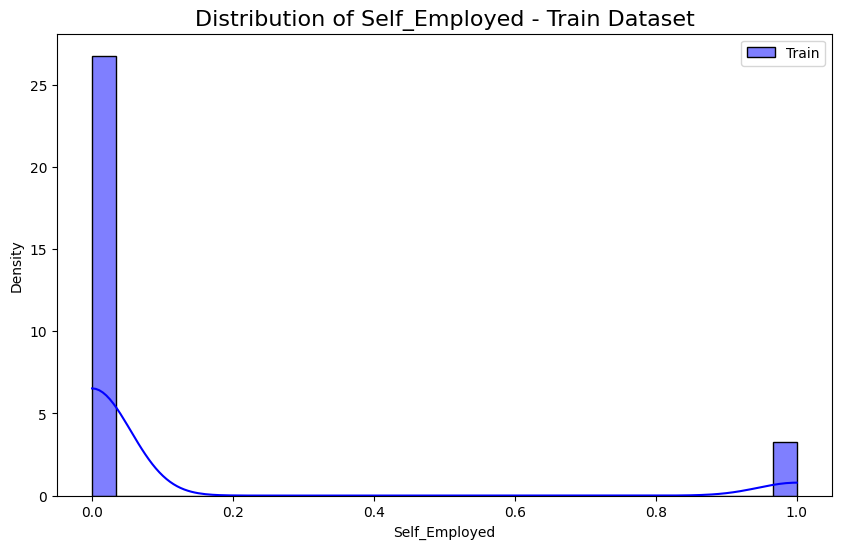

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


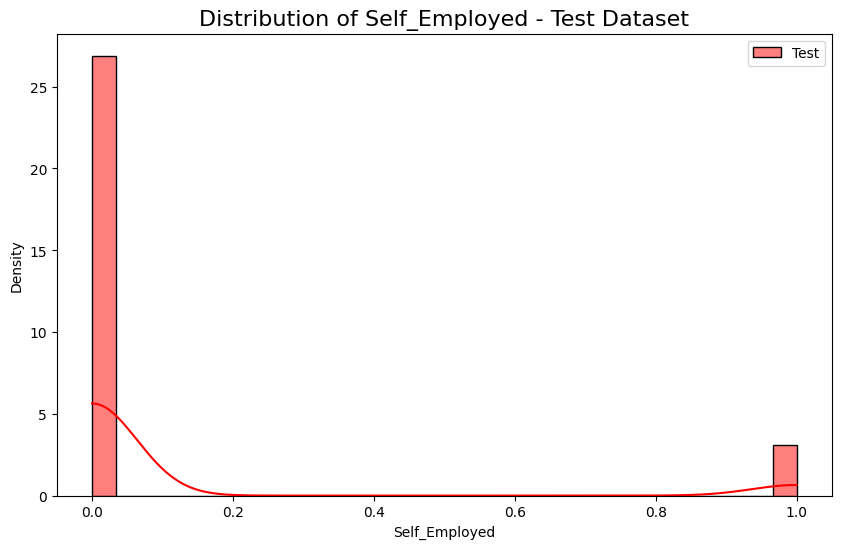

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


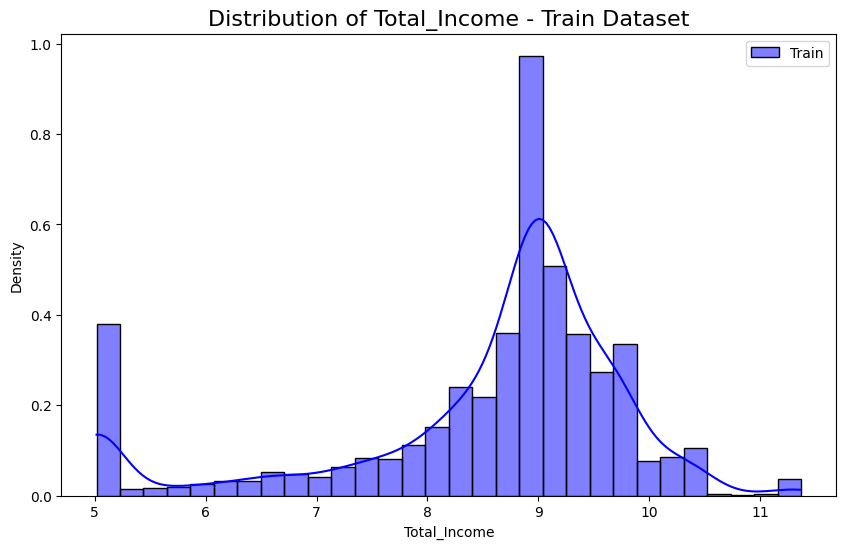

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


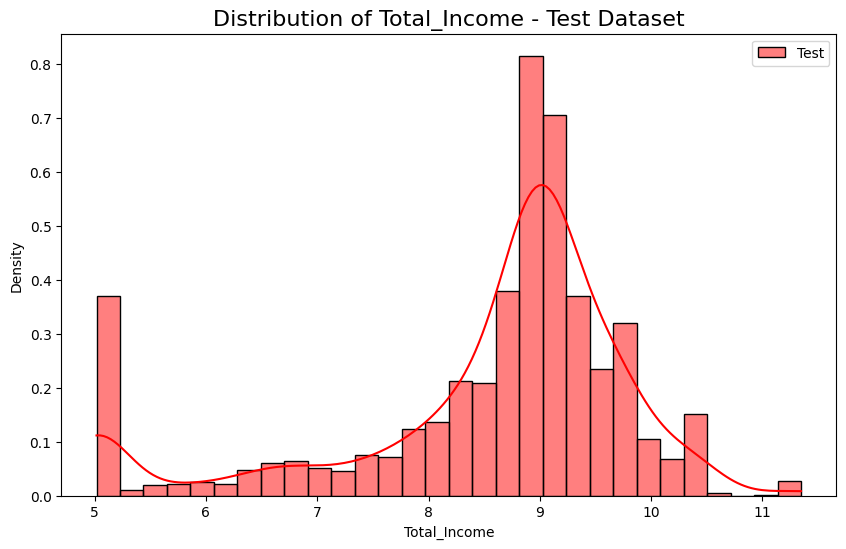

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


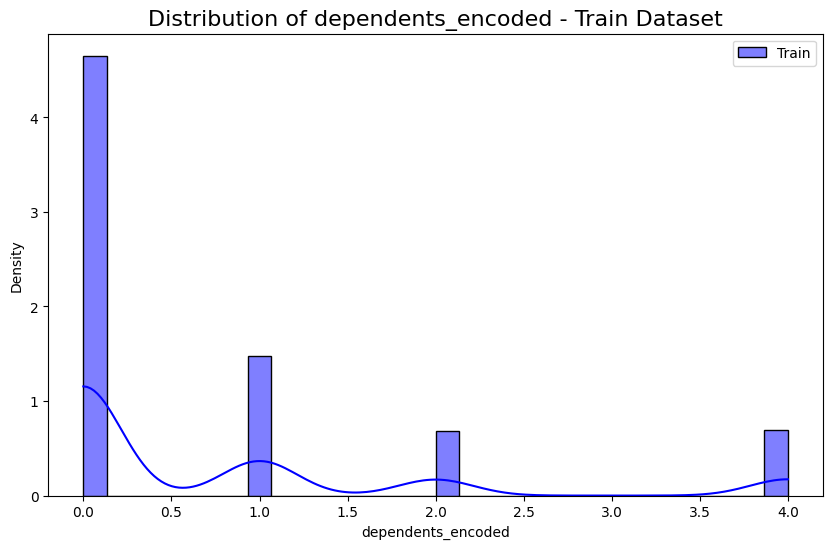

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


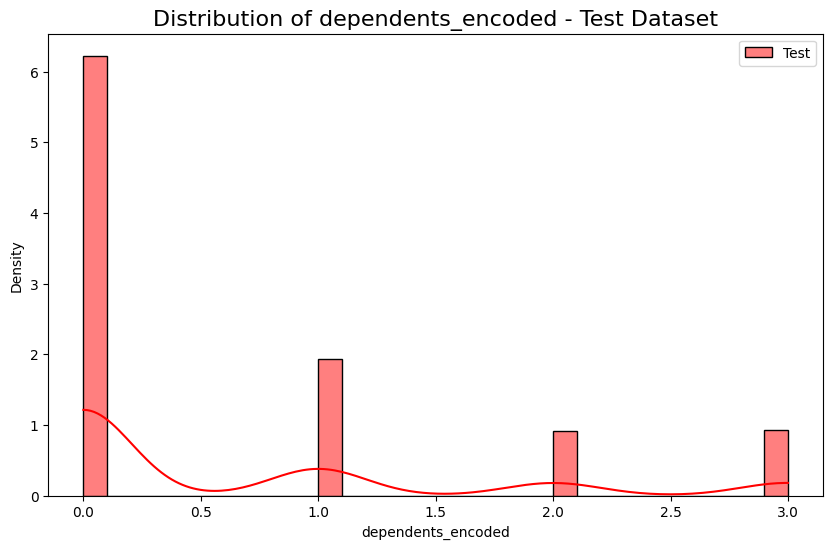

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


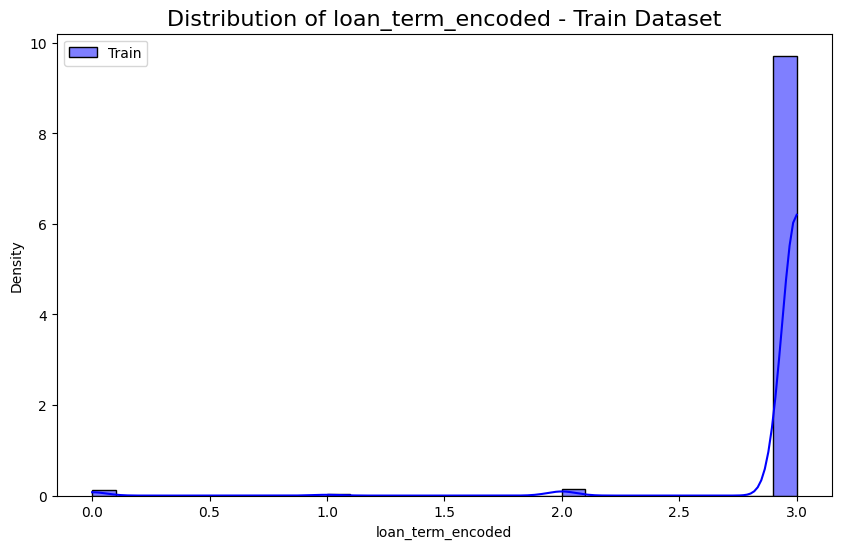

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


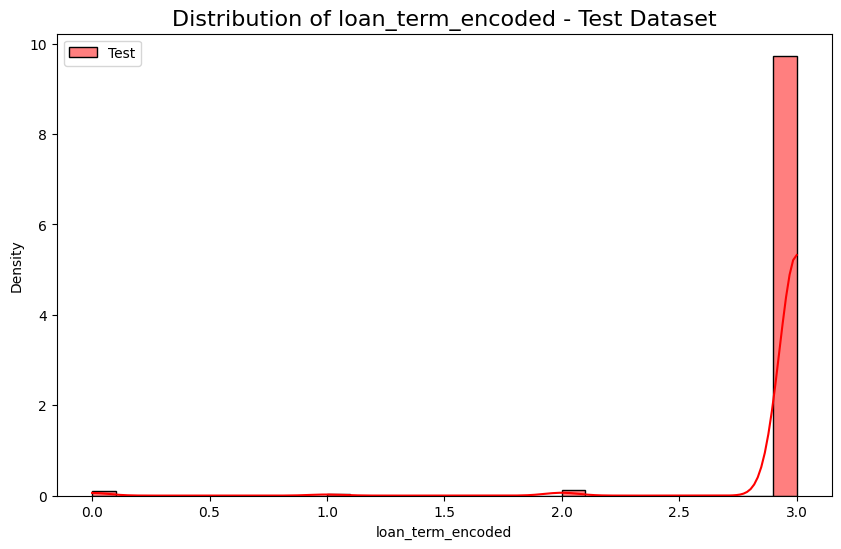

In [26]:

def plot_distributions(train, test, columns=None):

    """
    Plots the distribution of numerical features in both the train and test datasets.
    Parameters:
    - train: The training DataFrame.
    - test: The test DataFrame.
    - columns: A list of columns to visualize. If None, all numerical columns will be visualized.
    """
    if columns is None:
        # Exclude 'Loan_Status' from the columns to be plotted
        columns = train.select_dtypes(include=['float64', 'int64']).columns.difference(['Loan_Status'])
    # Iterate through each column and plot individually
    for col in columns:
        # Plot for Train data
        plt.figure(figsize=(10, 6))  # Set a larger size for individual plots
        sns.histplot(train[col], kde=True, color='blue', label='Train', stat='density', bins=30)
        plt.title(f'Distribution of {col} - Train Dataset', fontsize=16)
        plt.legend()
        plt.show()
        
        # Plot for Test data
        plt.figure(figsize=(10, 6))  # Set a larger size for individual plots
        sns.histplot(test[col], kde=True, color='red', label='Test', stat='density', bins=30)
        plt.title(f'Distribution of {col} - Test Dataset', fontsize=16)
        plt.legend()
        plt.show()


# Usage
plot_distributions(train, test)

## 5. Model Training 

In [27]:
from sklearn.metrics import make_scorer
# Step 1: Load and Select Data
X = train.drop(columns=['Loan_Status'])
y = train['Loan_Status']
# Stratified split ensures balanced class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step 3: Dimensionality Reduction using PCA
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


# Step 4: Define Models
lasso = LogisticRegression(penalty='l1', solver='saga', class_weight="balanced", random_state=42)
ridge = LogisticRegression(penalty='l2', solver='saga', class_weight="balanced", random_state=42)
elasticnet = LogisticRegression(penalty='elasticnet', solver='saga', class_weight="balanced", random_state=42)

# Step 5: Hyperparameter Tuning
param_grid = {
    'C': np.logspace(-3, 3, 7),  # Regularization strength
    'max_iter': [100, 300, 500],
    'l1_ratio': [0.2, 0.4, 0.6, 0.8, 1.0]  # For ElasticNet only
}

# Define a custom scorer for evaluation
def custom_scorer(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return 0.7 * f1 + 0.3 * accuracy  # Weighted scorer

scorer = make_scorer(custom_scorer, greater_is_better=True)

# Grid search for Lasso
lasso_grid = GridSearchCV(lasso, {'C': param_grid['C'], 'max_iter': param_grid['max_iter']},
                          scoring=scorer, cv=5, n_jobs=-1)
lasso_grid.fit(X_train_pca, y_train)

# Grid search for Ridge
ridge_grid = GridSearchCV(ridge, {'C': param_grid['C'], 'max_iter': param_grid['max_iter']},
                          scoring=scorer, cv=5, n_jobs=-1)
ridge_grid.fit(X_train_pca, y_train)

# Grid search for ElasticNet
elasticnet_grid = GridSearchCV(elasticnet, param_grid, scoring=scorer, cv=5, n_jobs=-1)
elasticnet_grid.fit(X_train_pca, y_train)

# Step 6: Evaluate Models
# Lasso Evaluation
lasso_pred = lasso_grid.best_estimator_.predict(X_val_pca)
print("LASSO Evaluation:")
print("Best Regularization Strength (C):", lasso_grid.best_params_['C'])
print(f"F1 Score: {f1_score(y_val, lasso_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_val, lasso_pred):.4f}")
print(classification_report(y_val, lasso_pred))

# Ridge Evaluation
ridge_pred = ridge_grid.best_estimator_.predict(X_val_pca)
print("\nRidge Evaluation:")
print("Best Regularization Strength (C):", ridge_grid.best_params_['C'])
print(f"F1 Score: {f1_score(y_val, ridge_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_val, ridge_pred):.4f}")
print(classification_report(y_val, ridge_pred))

# ElasticNet Evaluation
elasticnet_pred = elasticnet_grid.best_estimator_.predict(X_val_pca)
print("\nElasticNet Evaluation:")
print("Best Parameters:", elasticnet_grid.best_params_)
print(f"F1 Score: {f1_score(y_val, elasticnet_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_val, elasticnet_pred):.4f}")
print(classification_report(y_val, elasticnet_pred))

# Step 7: Threshold Tuning for ElasticNet
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_prob = elasticnet_grid.best_estimator_.predict_proba(X_val_pca)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_prob)

# Find threshold that maximizes F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nBest Threshold for ElasticNet: {best_threshold:.4f}")

# Apply best threshold
y_adjusted_pred = (y_prob >= best_threshold).astype(int)
print("\nElasticNet with Adjusted Threshold:")
print(f"F1 Score: {f1_score(y_val, y_adjusted_pred):.4f}")
print(classification_report(y_val, y_adjusted_pred))

# Step 8: Ensemble Voting Classifier
from sklearn.ensemble import VotingClassifier

# Combine the best Lasso, Ridge, and ElasticNet models
voting_clf = VotingClassifier(
    estimators=[
        ('lasso', lasso_grid.best_estimator_),
        ('ridge', ridge_grid.best_estimator_),
        ('elasticnet', elasticnet_grid.best_estimator_)
    ],
    voting='soft' # Soft voting for probabilities
)

voting_clf.fit(X_train_pca, y_train)
voting_pred = voting_clf.predict(X_val_pca)

print("\nEnsemble Voting Classifier Evaluation:")
print(f"F1 Score: {f1_score(y_val, voting_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_val, voting_pred):.4f}")
print(classification_report(y_val, voting_pred))

LASSO Evaluation:
Best Regularization Strength (C): 0.01
F1 Score: 0.6695
Accuracy: 0.5441
              precision    recall  f1-score   support

           0       0.18      0.49      0.27       197
           1       0.84      0.55      0.67       983

    accuracy                           0.54      1180
   macro avg       0.51      0.52      0.47      1180
weighted avg       0.73      0.54      0.60      1180


Ridge Evaluation:
Best Regularization Strength (C): 0.1
F1 Score: 0.6715
Accuracy: 0.5424
              precision    recall  f1-score   support

           0       0.17      0.45      0.25       197
           1       0.84      0.56      0.67       983

    accuracy                           0.54      1180
   macro avg       0.50      0.50      0.46      1180
weighted avg       0.72      0.54      0.60      1180


ElasticNet Evaluation:
Best Parameters: {'C': 0.001, 'l1_ratio': 0.2, 'max_iter': 100}
F1 Score: 0.9089
Accuracy: 0.8331
              precision    recall  f1-scor

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

In [28]:
# Assuming X_test has already been preprocessed (scaled and PCA applied)
X_test = test
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
test_pred = elasticnet_grid.best_estimator_.predict(X_test_pca)  # Use the transformed X_test data (after PCA)

# Optionally, you can print a classification report to evaluate performance (though you won't have y_test here)
# You will not be able to use y_test to calculate accuracy, F1, etc. because it's missing in the test dataset
print(f"Test Predictions: {test_pred[:10]}")  # Print first 10 predictions just as an example

# Assuming your predictions are stored in test_pred
sample_sub['Loan_Status'] = test_pred

print(sample_sub.head())
print(sample_sub.columns)

# Save the updated submission file
sample_sub.to_csv('first_submission_ElasticNet.csv', index=False)
print("submission file saved complete")

Test Predictions: [1 1 1 1 1 1 1 1 1 1]
      ID  Loan_Status
0  70607            1
1  58412            1
2  88755            1
3  97271            1
4  70478            1
Index(['ID', 'Loan_Status'], dtype='object')
submission file saved complete


In [29]:
'''# List files in the /kaggle/working/ directory
import
print(os.listdir('/kaggle/working/'))
from IPython.display import FileLink

# Generate download link for the sav
FileLink('/kaggle/working/first_submission_ElasticNet.csv')'''

"# List files in the /kaggle/working/ directory\nimport\nprint(os.listdir('/kaggle/working/'))\nfrom IPython.display import FileLink\n\n# Generate download link for the sav\nFileLink('/kaggle/working/first_submission_ElasticNet.csv')"